In [1]:
import os

os.chdir("./content")

lm_dir = "tf-levenberg-marquardt"
if not os.path.exists(lm_dir):
  !git clone https://github.com/fabiodimarco/$lm_dir

os.chdir(lm_dir)

In [2]:
!pip install --upgrade pip
!pip install tensorflow 
!pip install openpyxl
!pip install RegscorePy

/tmp/ipykernel_636254/1105938615.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


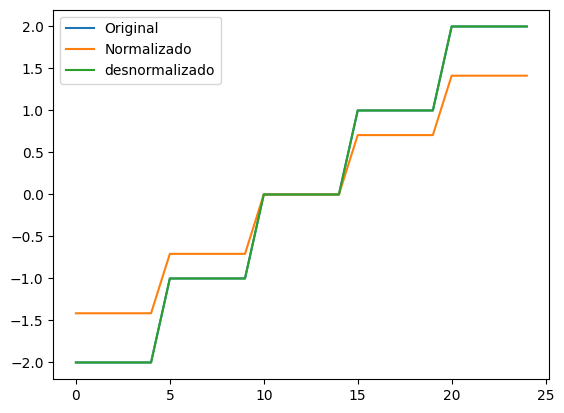

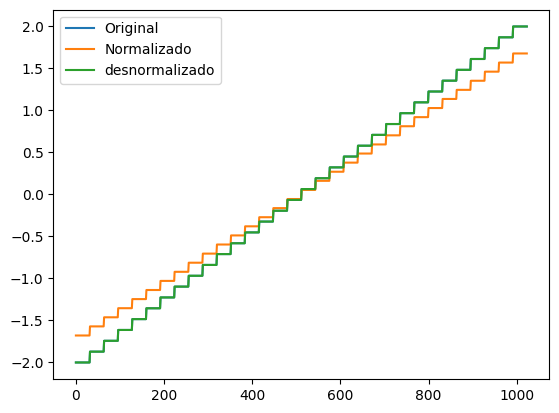

In [3]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

scaler = StandardScaler()
out_scaler = StandardScaler()

def peaks(grid):
    x = np.linspace(-2, 2, grid)
    y = np.linspace(-2, 2, grid)
    x, y = np.meshgrid(x, y)
    z = 3*(1-x)**2 * np.exp(-(x**2) - (y+1)**2) - 10*(x/5 - x**3 - y**5) * np.exp(-x**2 - y**2) - 1/3 * np.exp(-(x+1)**2 - y**2)
    return x, y, z

def create_dataframe(grid):
   x, y, z = peaks(grid)
   data = {'X': x.flatten(), 'Y': y.flatten(), 'Z': z.flatten()}
   df = pd.DataFrame(data)
   return df

def show_norm(df, label="Peaks", plot=False):
    df_norm = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)
    df_denorm = pd.DataFrame(scaler.inverse_transform(df_norm), columns=df_norm.columns)

    if (plot):
        df.plot(title=f"{label}: Original data")
        df_norm.plot(title=f"{label}: Normalized data")
        df_denorm.plot(title=f"{label}: Denormalized data")
    return (df_norm)


def test_out_scaler(df):
    out = df["Y"].values.reshape(-1, 1)  
    plt.plot(out, label='Original')
    out_scaler.fit(out)
    norm = out_scaler.transform(out)
    plt.plot(norm, label='Normalizado')
    plt.plot(out_scaler.inverse_transform(norm), label='desnormalizado')
    plt.legend()
    plt.show()


df_25 = create_dataframe(grid=5)
df_25_norm = show_norm(df_25)
test_out_scaler(df_25)

df_1000 = create_dataframe(grid=32)
df_1000_norm = show_norm(df_1000)
test_out_scaler(df_1000)



In [4]:
def split_df(df):
    _input = np.vstack([df['X'], df['Y']]).T
    _output = np.array(df['Z'])
    return (_input, _output)

In [5]:
import tensorflow as tf
import numpy as np
from keras import regularizers
from keras import initializers
import levenberg_marquardt as lm

# layers, neurons
class ShuffleArchitecture:
    def __init__(self, input_size, hidden_sizes, output_size, act_h, act_o, param_reg):
        self.input_size = input_size
        self.hidden_sizes = hidden_sizes
        self.output_size = output_size
        self.act_h = act_h
        self.act_o = act_o
        self.regularizer = regularizers.L2(param_reg)
        self.initializer = initializers.RandomUniform(minval=-0.5, maxval=0.5, seed=np.random.randint(1, 10000))

    def compute_k(self):
        total_parameters = 0
        for layer in self.model.layers:
            weights = layer.get_weights()
            if len(weights) > 0:  
                for w in weights:
                    total_parameters += np.prod(w.shape)
        return total_parameters
        
    def set_architecture(self):
        self.model = tf.keras.Sequential()
        self.model.add(tf.keras.layers.Dense(self.hidden_sizes[0],
                        input_shape=(self.input_size,),
                        activation=self.act_h,
                        kernel_regularizer=self.regularizer,
                        kernel_initializer=self.initializer,                        
                        ))  # input layer

        for size in self.hidden_sizes[1:]:  # hidden layers
            self.model.add(tf.keras.layers.Dense(size,
                            activation=self.act_h,
                            kernel_regularizer=self.regularizer,
                            kernel_initializer=self.initializer,  
                        ))

        self.model.add(tf.keras.layers.Dense(self.output_size,
                        activation=self.act_o,
                        kernel_regularizer=self.regularizer,
                        kernel_initializer=self.initializer,  
                        ))  # output layer

    def create_model(self, _learning_rate):
        self.model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=_learning_rate),
            loss=tf.keras.losses.MeanSquaredError())

        self.lm_model = lm.ModelWrapper(
            tf.keras.models.clone_model(self.model))

        self.lm_model.compile(
            optimizer=tf.keras.optimizers.SGD(learning_rate=_learning_rate),
            loss=lm.MeanSquaredError())
        return(self.lm_model)

2024-05-04 02:33:05.252415: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-04 02:33:05.285132: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-04 02:33:05.285171: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-04 02:33:05.286323: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-04 02:33:05.292223: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-04 02:33:05.293158: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [6]:
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from sklearn.metrics import r2_score, mean_squared_error, root_mean_squared_error, mean_absolute_percentage_error 

class TrainWithSmallDataset:
    def __init__(self, batch_size=1000):
        self.batch_size = batch_size
        self.betters = []
        self.k = 0

    def create_dataset(self, input, output):
      input = tf.expand_dims(tf.cast(input, tf.float32), axis=-1)
      output = tf.expand_dims(tf.cast(output, tf.float32), axis=-1)
      dataset = tf.data.Dataset.from_tensor_slices((input, output))
      dataset = dataset.shuffle(len(input))
      dataset = dataset.batch(self.batch_size).cache()
      dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
      return (dataset, input, output)

    def split_dataset(self, input, output, sup_input, sup_output):
      input_train, input_vt, output_train, output_vt = train_test_split(input, output, test_size=0.3, shuffle = True)
      input_val, input_test, output_val, output_test = train_test_split(input_vt, output_vt, test_size=0.5, shuffle = True)

      self.train_dataset, self.train_input, self.train_output = self.create_dataset(input_train, output_train)
      self.val_dataset, self.val_input, self.val_output = self.create_dataset(input_val, output_val)
      self.test_dataset, self.test_input, self.test_output = self.create_dataset(input_test, output_test)
      self.vt_dataset, self.vt_input, self.vt_output = self.create_dataset(input_vt, output_vt)
      self.sup_dataset, self.sup_input, self.sup_output = self.create_dataset(sup_input, sup_output)
      self.dataset, self.input, self.output = self.create_dataset(input, output)

      self._data = (input, output)
      self._train = (input_train, output_train)
      self._vt = (input_vt, output_vt)
      self._val = (input_val, output_val)
      self._test = (input_test, output_test)
      self._sup = (sup_input, sup_output)

    def train_using_lm(self, train_dataset, epochs=1000):
      early_stopping_monitor = EarlyStopping(monitor='val_loss',
                                              patience=6,
                                              restore_best_weights=True)

      self.results = self.lm_model.fit(train_dataset,
                                            epochs=epochs,
                                            validation_data=self.val_dataset,
                                            callbacks=[early_stopping_monitor],
                                            verbose=0)
      print ("Stopped at epoch: ", early_stopping_monitor.stopped_epoch)
    
    def get_new_metrics(self, orig, pred, r2, mse):
      n = len(orig) # N: quantidade de saidas
      k = self.k
      waste = (orig.flatten() - pred.flatten())

      mape = mean_absolute_percentage_error(orig, pred)  
      r2_adj = 1 - (((n - 1)/(n - k - 1)) * (1 - r2))
      rsd = np.sqrt(np.sum(waste ** 2) / (n - 2))
      rmse = root_mean_squared_error(orig, pred)          
      aic = (-2 * np.log(mse)) + (2 * k)
      bic = (-2 * np.log(mse)) + (k * np.log(n))
      return (mape, r2_adj, rsd, rmse, aic, bic)
      

    def get_metrics(self):
          # Calculando a saida com os dados normalizados
          pred = self.lm_model.predict(self.input).flatten()
          test_pred = self.lm_model.predict(self.test_input).flatten()
          val_pred = self.lm_model.predict(self.val_input).flatten()
          vt_pred = self.lm_model.predict(self.vt_input).flatten()
          sup_pred = self.lm_model.predict(self.sup_input).flatten()

          # Calculando as metricas com a saida desnormalizada
          pred_denorm = out_scaler.inverse_transform(pred.reshape(-1, 1))
          test_pred_denorm = out_scaler.inverse_transform(test_pred.reshape(-1, 1))
          val_pred_denorm = out_scaler.inverse_transform(val_pred.reshape(-1, 1))
          vt_pred_denorm = out_scaler.inverse_transform(vt_pred.reshape(-1, 1))
          sup_pred_denorm = out_scaler.inverse_transform(sup_pred.reshape(-1, 1))

          out_denorm = out_scaler.inverse_transform(self._data[1].reshape(-1, 1))
          test_denorm = out_scaler.inverse_transform(self._test[1].reshape(-1, 1))
          val_denorm = out_scaler.inverse_transform(self._val[1].reshape(-1, 1))
          vt_denorm = out_scaler.inverse_transform(self._vt[1].reshape(-1, 1))    
          sup_denorm = out_scaler.inverse_transform(self._sup[1].reshape(-1, 1))

          r2 = r2_score(out_denorm, pred_denorm)
          r2_test = r2_score(test_denorm, test_pred_denorm)
          r2_val = r2_score(val_denorm, val_pred_denorm)
          r2_vt = r2_score(vt_denorm,  vt_pred_denorm)
          r2_sup = r2_score(sup_denorm,  sup_pred_denorm)

          mse = mean_squared_error(out_denorm, pred_denorm)
          mse_test = mean_squared_error(test_denorm, test_pred_denorm)
          mse_val = mean_squared_error(val_denorm, val_pred_denorm)
          mse_vt = mean_squared_error(vt_denorm,  vt_pred_denorm)
          mse_sup = mean_squared_error(sup_denorm,  sup_pred_denorm)
          
          mape, r2_adj, rsd, rmse, aic, bic = self.get_new_metrics(out_denorm, pred_denorm, r2, mse)
          metrics = {
                          'r2': r2,
                          'r2_sup': r2_sup,
                          'r2_test': r2_test,
                          'r2_val': r2_val,
                          'r2_vt': r2_vt,
                          'mse': mse,
                          'mse_sup': mse_sup,
                          'mse_test': mse_test,
                          'mse_val': mse_val,
                          'mse_vt': mse_vt,
                          'mape': mape,
                          'rmse': rmse,
                          'r2_adj': r2_adj,
                          'rsd': rsd,
                          'aic': aic,
                          'bic': bic
                          }

          return metrics

In [7]:
import pickle
from itertools import product

class Tester:
  def __init__(self, run_times=500, dataset_run_times=10):
    self.run_times = run_times
    self.better_metrics = {}
    self.dataset_run_times = dataset_run_times
    self.input_25, self.output_25 = split_df(df_25_norm)
    self.input_1000, self.output_1000 = split_df(df_1000_norm)
  
  def setArchitecure(self, trainer, _hidden_sizes, _pg, _lr):
    shuffler = ShuffleArchitecture(input_size=2,
                                    hidden_sizes=_hidden_sizes,
                                    output_size=1,
                                    act_h='tanh',
                                    act_o='linear',
                                    param_reg=_pg)
    shuffler.set_architecture()    
    trainer.lm_model = shuffler.create_model(_lr)
    trainer.k = shuffler.compute_k()

  def Train(self, trainer, epochs=1000):
    trainer.train_using_lm(trainer.train_dataset, epochs=epochs)
    return(trainer.get_metrics(), trainer.lm_model)

  def SaveModelWeights(self, model, fileName):
    path = f"../models/{fileName}.keras"
    open(path,'w').close()
    model.save_weights(path)

  def SaveDataset(self, trainer, fileName):
    path = f"../dataset/{fileName}.pkl" 
    with open(path, 'wb') as f:
      pickle.dump((trainer._data, trainer._train, trainer._vt, trainer._val, trainer._test), f)
      
  def LoopWeights(self, sort_by, boundarie, trainer, idx):
    better_model = 0
    save = False

    for i in range(self.run_times):
      print (f"+++++++++++ [{idx}] | {i + 1} ++++++++++++++++++")
      metrics, model = self.Train(trainer)
      if (metrics[sort_by] <= boundarie): # should be >= to acsending metrics
        fileName = f"model_{idx}_{better_model}"
        self.SaveModelWeights(model, fileName)
        self.better_metrics[fileName] = metrics
        better_model += 1
        save = True
    return(save)

  def Loop(self, sort_by, boundarie, hidden_sizes, regularizers, learning_rate):
    trainer = TrainWithSmallDataset()

    for count, (hidden_size, reg, lr) in enumerate(product(hidden_sizes, regularizers, learning_rate), start=1):
      header =  f"Hidden Size={hidden_size}, regularizer={reg}, learning_rate={lr}"
      print(f"Testando combinacao{count}: {header}")
      self.setArchitecure(trainer, hidden_size, reg, lr)
      for j in range(self.dataset_run_times):
        trainer.split_dataset(self.input_25, self.output_25, self.input_1000, self.output_1000)
        if (self.LoopWeights(sort_by, boundarie, trainer, f"{count}_{j}") == True):
          self.SaveDataset(trainer, f"dataset_{count}_{j}")
          self.DisplayBetterResults('mse_sup', header, f"{count}_{j}")
        self.better_metrics = {}

  def DisplayBetterResults(self, sort_by, header, dataset=0):
    df = pd.DataFrame.from_dict(self.better_metrics, orient='index')
    df = df.sort_values([sort_by])
    display(df)
    path = f'../results/metrics_{dataset}'
    df.to_excel(f"{path}.xlsx", index=True)
    print(f"DataFrame salvo em {path}")
    with open(f"{path}.txt", 'w') as arquivo:
      arquivo.write(header)

# Treinando com 25 dados


In [8]:
tester = Tester(run_times=25, dataset_run_times=10)
tester.Loop(sort_by='mse_sup',
            boundarie = 0.25,
            hidden_sizes = [[40, 39], [20, 4], [15, 14], [26,18], [33, 21], [21, 12], [30, 21], [15, 2], [24, 7], [30, 16]],
            regularizers=[0.2, 0.0, 0.02, 0.5],
            learning_rate=[0.01, 0.1])

Testando combinacao1: Hidden Size=[40, 39], regularizer=0.2, learning_rate=0.01
+++++++++++ [1_0] | 1 ++++++++++++++++++
Stopped at epoch:  21
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_0] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_0] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_0] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_0] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_1_8_4  0.963413  0.824410  0.975035  0.926612  0.950796  0.051930   
model_1_8_3  0.962962  0.824306  0.976581  0.926572  0.951259  0.052569   
model_1_8_2  0.962495  0.824189  0.978059  0.926516  0.951692  0.053233   
model_1_8_1  0.962010  0.824058  0.979464  0.926444  0.952092  0.053921   
model_1_8_0  0.961507  0.823914  0.980795  0.926354  0.952459  0.054636   

              mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_1_8_4  0.249225  0.013919  0.073437  0.043678  1.385365  0.227882   
model_1_8_3  0.249373  0.013057  0.073477  0.043267  1.397746  0.229280   
model_1_8_2  0.249539  0.012233  0.073533  0.042883  1.410249  0.230723   
model_1_8_1  0.249724  0.011449  0.073605  0.042527  1.422877  0.232210   
model_1_8_0  0.249928  0.010707  0.073695  0.042201  1.435631  0.233743   

               r2_adj       rsd          aic          bic  
model_1_8_4  1.000506  0.237584  3523.915707  5667.918283  
model_1_8_3  1.000512  0.239041  3523.891242  5667.893818  
model_1_8_2  1.000519  0.240545  3523.866157  5667.868733  
model_1_8_1  1.000526  0.242095  3523.840456  5667.843032  
model_1_8_0  1.000532  0.243694  3523.814138  5667.816714

DataFrame salvo em ../results/metrics_1_8
+++++++++++ [1_9] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_9] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_9] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_9] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_9] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_9] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_9] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_9] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_9] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_1_9_7   0.967745  0.825032  0.948192  0.978189  0.967669  0.045781   
model_1_9_6   0.967303  0.825024  0.950982  0.977782  0.968433  0.046408   
model_1_9_8   0.968161  0.825022  0.945288  0.978498  0.966803  0.045190   
model_1_9_5   0.966834  0.824997  0.953657  0.977273  0.969091  0.047074   
model_1_9_9   0.968552  0.824994  0.942277  0.978709  0.965838  0.044636   
model_1_9_4   0.966337  0.824950  0.956211  0.976659  0.969641  0.047780   
model_1_9_10  0.968917  0.824950  0.939161  0.978827  0.964777  0.044118   
model_1_9_11  0.969258  0.824888  0.935944  0.978853  0.963623  0.043634   
model_1_9_3   0.965812  0.824884  0.958641  0.975939  0.970080  0.048525   
model_1_9_12  0.969575  0.824810  0.932630  0.978790  0.962378  0.043184   
model_1_9_2   0.965257  0.824797  0.960942  0.975110  0.970405  0.049312   
model_1_9_13  0.969869  0.824716  0.929222  0.978640  0.961045  0.042767   
model_1_9_1   0.964673  0.824690  0.963109  0.974170  0.970612  0.050141   
model_1_9_14  0.970141  0.824607  0.925724  0.978406  0.959628  0.042381   
model_1_9_0   0.964059  0.824561  0.965139  0.973115  0.970699  0.051014   
model_1_9_15  0.970390  0.824482  0.922138  0.978089  0.958128  0.042027   
model_1_9_16  0.970618  0.824343  0.918469  0.977694  0.956548  0.041703   
model_1_9_17  0.970826  0.824190  0.914719  0.977221  0.954892  0.041408   
model_1_9_18  0.971013  0.824024  0.910892  0.976672  0.953161  0.041142   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_1_9_7   0.248342  0.024997  0.017877  0.021437  1.238951  0.213964   
model_1_9_6   0.248353  0.023651  0.018211  0.020931  1.256602  0.215426   
model_1_9_8   0.248356  0.026398  0.017624  0.022011  1.221480  0.212580   
model_1_9_5   0.248392  0.022360  0.018628  0.020494  1.274436  0.216966   
model_1_9_9   0.248395  0.027851  0.017451  0.022651  1.204188  0.211273   
model_1_9_4   0.248458  0.021128  0.019131  0.020129  1.292451  0.218586   
model_1_9_10  0.248459  0.029354  0.017354  0.023354  1.187070  0.210043   
model_1_9_11  0.248546  0.030907  0.017333  0.024120  1.170130  0.208888   
model_1_9_3   0.248552  0.019955  0.019721  0.019838  1.310655  0.220284   
model_1_9_12  0.248657  0.032506  0.017385  0.024945  1.153358  0.207807   
model_1_9_2   0.248675  0.018845  0.020401  0.019623  1.329047  0.222063   
model_1_9_13  0.248790  0.034150  0.017508  0.025829  1.136763  0.206801   
model_1_9_1   0.248827  0.017799  0.021172  0.019486  1.347624  0.223922   
model_1_9_14  0.248946  0.035838  0.017700  0.026769  1.120329  0.205867   
model_1_9_0   0.249010  0.016820  0.022036  0.019428  1.366398  0.225862   
model_1_9_15  0.249122  0.037568  0.017959  0.027763  1.104073  0.205005   
model_1_9_16  0.249319  0.039338  0.018283  0.028811  1.087976  0.204213   
model_1_9_17  0.249536  0.041147  0.018671  0.029909  1.072436  0.203490   
model_1_9_18  0.249773  0.042994  0.019120  0.031057  1.058674  0.202836   

                r2_adj       rsd          aic          bic  
model_1_9_7   1.000446  0.223073  3524.167784  5668.170360  
model_1_9_6   1.000452  0.224597  3524.140549  5668.143125  
model_1_9_8   1.000440  0.221630  3524.193741  5668.196317  
model_1_9_5   1.000459  0.226203  3524.112050  5668.114626  
model_1_9_9   1.000435  0.220268  3524.218410  5668.220986  
model_1_9_4   1.000466  0.227891  3524.082307  5668.084883  
model_1_9_10  1.000430  0.218985  3524.241777  5668.244353  
model_1_9_11  1.000425  0.217781  3524.263831  5668.266406  
model_1_9_3   1.000473  0.229662  3524.051342  5668.053918  
model_1_9_12  1.000421  0.216654  3524.284573  5668.287149  
model_1_9_2   1.000481  0.231517  3524.019170  5668.021746  
model_1_9_13  1.000417  0.215605  3524.303994  5668.306570  
model_1_9_1   1.000489  0.233455  3523.985827  5667.988403  
model_1_9_14  1.000413  0.214631  3524.322104  5668.324680  
model_1_9_0   1.000497  0.235477  3523.951326  5667.953902  
mo

DataFrame salvo em ../results/metrics_1_9
Testando combinacao2: Hidden Size=[40, 39], regularizer=0.2, learning_rate=0.1
+++++++++++ [2_0] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_0] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_0] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_0] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_0] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [=====

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_2_2_15  0.957066  0.847035 -0.160008  0.673495  0.757508  0.060938   
model_2_2_14  0.957722  0.847029 -0.124408  0.672977  0.762303  0.060007   
model_2_2_16  0.956451  0.847010 -0.192570  0.674033  0.753138  0.061812   
model_2_2_13  0.958415  0.846979 -0.085579  0.672500  0.767555  0.059024   
model_2_2_17  0.955876  0.846963 -0.222284  0.674574  0.749163  0.062627   
model_2_2_12  0.959141  0.846870 -0.043362  0.672091  0.773293  0.057994   
model_2_2_11  0.959892  0.846683  0.002376  0.671789  0.779545  0.056928   
model_2_2_10  0.960657  0.846393  0.051717  0.671643  0.786334  0.055841   
model_2_2_9   0.961421  0.845968  0.104669  0.671713  0.793677  0.054757   
model_2_2_8   0.962162  0.845369  0.161149  0.672077  0.801583  0.053706   
model_2_2_7   0.962850  0.844548  0.220958  0.672835  0.810047  0.052729   
model_2_2_6   0.963448  0.843447  0.283751  0.674109  0.819055  0.051880   
model_2_2_5   0.963906  0.841996  0.349027  0.676044  0.828571  0.051230   
model_2_2_4   0.964162  0.840113  0.416108  0.678821  0.838549  0.050867   
model_2_2_3   0.964138  0.837705  0.484155  0.682645  0.848924  0.050900   
model_2_2_2   0.963739  0.834668  0.552183  0.687757  0.859619  0.051467   
model_2_2_1   0.962849  0.830884  0.619086  0.694417  0.870548  0.052731   
model_2_2_0   0.961325  0.826223  0.683666  0.702900  0.881613  0.054893   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_2_2_15  0.217111  0.247601  0.126527  0.187064  1.010847  0.246856   
model_2_2_14  0.217120  0.240003  0.126728  0.183365  1.005389  0.244964   
model_2_2_16  0.217147  0.254552  0.126319  0.190435  1.015721  0.248620   
model_2_2_13  0.217191  0.231715  0.126913  0.179314  0.999291  0.242948   
model_2_2_17  0.217214  0.260894  0.126109  0.193502  1.020073  0.250254   
model_2_2_12  0.217345  0.222704  0.127071  0.174887  0.992495  0.240819   
model_2_2_11  0.217611  0.212941  0.127188  0.170065  0.984938  0.238595   
model_2_2_10  0.218023  0.202409  0.127245  0.164827  0.976569  0.236307   
model_2_2_9   0.218626  0.191107  0.127218  0.159162  0.967341  0.234002   
model_2_2_8   0.219476  0.179051  0.127077  0.153064  0.957220  0.231745   
model_2_2_7   0.220641  0.166285  0.126783  0.146534  0.946190  0.229627   
model_2_2_6   0.222204  0.152882  0.126289  0.139586  0.934251  0.227772   
model_2_2_5   0.224264  0.138949  0.125539  0.132244  0.921417  0.226340   
model_2_2_4   0.226937  0.124631  0.124463  0.124547  0.907714  0.225536   
model_2_2_3   0.230354  0.110106  0.122981  0.116544  0.893223  0.225611   
model_2_2_2   0.234665  0.095586  0.121000  0.108293  0.877903  0.226863   
model_2_2_1   0.240036  0.081305  0.118420  0.099863  0.861643  0.229632   
model_2_2_0   0.246651  0.067521  0.115132  0.091327  0.844208  0.234293   

                r2_adj       rsd          aic          bic  
model_2_2_15  1.000594  0.257365  3523.595796  5667.598372  
model_2_2_14  1.000585  0.255393  3523.626572  5667.629148  
model_2_2_16  1.000602  0.259204  3523.567322  5667.569898  
model_2_2_13  1.000575  0.253291  3523.659631  5667.662207  
model_2_2_17  1.000610  0.260908  3523.541116  5667.543692  
model_2_2_12  1.000565  0.251071  3523.694846  5667.697422  
model_2_2_11  1.000555  0.248752  3523.731952  5667.734528  
model_2_2_10  1.000544  0.246367  3523.770487  5667.773063  
model_2_2_9   1.000534  0.243964  3523.809702  5667.812278  
model_2_2_8   1.000523  0.241611  3523.848471  5667.851047  
model_2_2_7   1.000514  0.239403  3523.885192  5667.887768  
model_2_2_6   1.000506  0.237469  3523.917642  5667.920218  
model_2_2_5   1.000499  0.235976  3523.942866  5667.945442  
model_2_2_4   1.000496  0.235138  3523.957099  5667.959675  
model_2_2_3   1.000496  0.235216  3523.955770  5667.958346  
model_2_2_2   1.000502  0.236521  3523.933639  5667.936215  
model_2_2_1   1.000514  0.239408  3523.885111  5667.887687  
model_2_2_0   1.000535  0.244267

DataFrame salvo em ../results/metrics_2_2
+++++++++++ [2_3] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_3] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_3] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_3] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_3] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_3] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_3] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_3] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_3] | 9 ++++++++++++++++

2024-05-04 02:37:46.946304: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_3] | 24 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_3] | 25 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step


r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_2_3_6   0.979800  0.861657  0.948015  0.941502  0.945567  0.028671   
model_2_3_5   0.978703  0.861558  0.956181  0.941243  0.947793  0.030228   
model_2_3_7   0.980528  0.861472  0.940062  0.941312  0.943104  0.027638   
model_2_3_8   0.980973  0.861081  0.932413  0.940796  0.940511  0.027007   
model_2_3_4   0.977130  0.861071  0.964422  0.940381  0.949637  0.032461   
model_2_3_9   0.981201  0.860547  0.925126  0.940051  0.937871  0.026682   
model_2_3_3   0.974943  0.860071  0.972534  0.938722  0.950910  0.035565   
model_2_3_10  0.981268  0.859918  0.918235  0.939152  0.935245  0.026587   
model_2_3_11  0.981216  0.859231  0.911759  0.938158  0.932677  0.026662   
model_2_3_12  0.981076  0.858515  0.905704  0.937114  0.930199  0.026860   
model_2_3_2   0.971971  0.858394  0.980219  0.936029  0.951365  0.039784   
model_2_3_13  0.980876  0.857790  0.900066  0.936053  0.927833  0.027144   
model_2_3_14  0.980635  0.857074  0.894836  0.935001  0.925592  0.027486   
model_2_3_15  0.980369  0.856377  0.890000  0.933974  0.923484  0.027864   
model_2_3_1   0.967997  0.855837  0.987048  0.932006  0.950678  0.045424   
model_2_3_16  0.980089  0.855707  0.885542  0.932986  0.921513  0.028261   
model_2_3_17  0.979805  0.855070  0.881441  0.932046  0.919678  0.028664   
model_2_3_18  0.979522  0.854468  0.877679  0.931158  0.917978  0.029065   
model_2_3_19  0.979247  0.853904  0.874232  0.930325  0.916408  0.029456   
model_2_3_20  0.978982  0.853377  0.871082  0.929548  0.914963  0.029833   
model_2_3_21  0.978728  0.852889  0.868206  0.928827  0.913635  0.030192   
model_2_3_22  0.978489  0.852437  0.865585  0.928161  0.912419  0.030531   
model_2_3_0   0.962748  0.852137  0.992404  0.926294  0.948428  0.052874   
model_2_3_23  0.978265  0.852021  0.863198  0.927547  0.911307  0.030850   
model_2_3_24  0.978055  0.851638  0.861029  0.926982  0.910292  0.031148   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_2_3_6   0.196357  0.032905  0.084371  0.058638  0.771553  0.169324   
model_2_3_5   0.196499  0.027737  0.084745  0.056241  0.795543  0.173861   
model_2_3_7   0.196620  0.037939  0.084645  0.061292  0.750251  0.166246   
model_2_3_8   0.197175  0.042781  0.085389  0.064085  0.731306  0.164337   
model_2_3_4   0.197189  0.022520  0.085988  0.054254  0.822591  0.180170   
model_2_3_9   0.197933  0.047393  0.086464  0.066929  0.714445  0.163346   
model_2_3_3   0.198609  0.017386  0.088380  0.052883  0.853123  0.188588   
model_2_3_10  0.198826  0.051755  0.087760  0.069758  0.699409  0.163054   
model_2_3_11  0.199801  0.055854  0.089194  0.072524  0.685989  0.163284   
model_2_3_12  0.200818  0.059687  0.090700  0.075193  0.674000  0.163889   
model_2_3_2   0.200989  0.012521  0.092265  0.052393  0.887605  0.199458   
model_2_3_13  0.201846  0.063256  0.092230  0.077743  0.663278  0.164754   
model_2_3_14  0.202862  0.066566  0.093748  0.080157  0.653684  0.165789   
model_2_3_15  0.203852  0.069627  0.095229  0.082428  0.645089  0.166924   
model_2_3_1   0.204619  0.008198  0.098067  0.053133  0.926558  0.213128   
model_2_3_16  0.204803  0.072449  0.096653  0.084551  0.637384  0.168109   
model_2_3_17  0.205708  0.075045  0.098010  0.086527  0.630474  0.169305   
model_2_3_18  0.206562  0.077426  0.099291  0.088359  0.624274  0.170484   
model_2_3_19  0.207363  0.079608  0.100492  0.090050  0.618713  0.171628   
model_2_3_20  0.208110  0.081602  0.101612  0.091607  0.613717  0.172721   
model_2_3_21  0.208803  0.083422  0.102652  0.093037  0.609228  0.173758   
model_2_3_22  0.209444  0.085081  0.103613  0.094347  0.605194  0.174732   
model_2_3_0   0.209870  0.004808  0.106306  0.055557  0.970511  0.229944   
model_2_3_23  0.210035  0.086592  0.104499  0.095546  0.601572  0.175642   
model_2_3_24  0.210578  0.087965  0.105313  0.096639  0.598317  0.176487   

                r2_adj       rsd          aic          bic  
model

DataFrame salvo em ../results/metrics_2_3
+++++++++++ [2_4] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_4] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_4] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_4] | 4 ++++++++++++++++++


2024-05-04 02:37:53.593781: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_4] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_4] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_4] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_4] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_4] | 9 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_4] | 10 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_4] | 11 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_4] | 12 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_2_4_1   0.985709  0.854286  0.950102  0.869778  0.950229  0.020284   
model_2_4_2   0.987858  0.854192  0.910331  0.907882  0.946652  0.017234   
model_2_4_0   0.982514  0.853521  0.977340  0.800932  0.941806  0.024819   
model_2_4_3   0.989160  0.853456  0.861471  0.919934  0.933415  0.015386   
model_2_4_4   0.989796  0.852261  0.806485  0.911089  0.912819  0.014484   
model_2_4_5   0.989921  0.850756  0.747861  0.886368  0.886971  0.014306   
model_2_4_6   0.989667  0.849058  0.687621  0.850280  0.857693  0.014667   
model_2_4_7   0.989141  0.847257  0.627350  0.806638  0.826483  0.015412   
model_2_4_8   0.988431  0.845422  0.568240  0.758513  0.794520  0.016421   
model_2_4_9   0.987602  0.843602  0.511157  0.708277  0.762697  0.017598   
model_2_4_10  0.986706  0.841833  0.456693  0.657695  0.731659  0.018870   
model_2_4_11  0.985780  0.840138  0.405220  0.608037  0.701854  0.020183   
model_2_4_12  0.984854  0.838531  0.356947  0.560169  0.673573  0.021497   
model_2_4_13  0.983947  0.837023  0.311952  0.514653  0.646984  0.022785   
model_2_4_14  0.983072  0.835616  0.270230  0.471827  0.622170  0.024027   
model_2_4_15  0.982238  0.834311  0.231698  0.431853  0.599146  0.025211   
model_2_4_16  0.981451  0.833105  0.196244  0.394780  0.577888  0.026327   
model_2_4_17  0.980714  0.831997  0.163712  0.360572  0.558333  0.027374   
model_2_4_18  0.980028  0.830980  0.133938  0.329133  0.540402  0.028348   
model_2_4_19  0.979391  0.830049  0.106742  0.300335  0.524003  0.029251   
model_2_4_20  0.978804  0.829200  0.081949  0.274026  0.509039  0.030084   
model_2_4_21  0.978264  0.828426  0.059375  0.250046  0.495408  0.030851   
model_2_4_22  0.977769  0.827721  0.038859  0.228226  0.483013  0.031554   
model_2_4_23  0.977316  0.827081  0.020225  0.208402  0.471753  0.032197   
model_2_4_24  0.976902  0.826501  0.003320  0.190417  0.461539  0.032785   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_2_4_1   0.206819  0.006309  0.012552  0.009431  0.699156  0.142421   
model_2_4_2   0.206954  0.011338  0.008879  0.010108  0.797078  0.131279   
model_2_4_0   0.207906  0.002865  0.019188  0.011027  0.592409  0.157540   
model_2_4_3   0.207998  0.017516  0.007718  0.012617  0.886727  0.124039   
model_2_4_4   0.209694  0.024468  0.008570  0.016519  0.968595  0.120348   
model_2_4_5   0.211830  0.031881  0.010953  0.021417  1.044355  0.119609   
model_2_4_6   0.214240  0.039497  0.014431  0.026964  1.127125  0.121107   
model_2_4_7   0.216796  0.047118  0.018638  0.032878  1.201934  0.124147   
model_2_4_8   0.219401  0.054592  0.023277  0.038934  1.269376  0.128145   
model_2_4_9   0.221984  0.061809  0.028119  0.044964  1.330065  0.132656   
model_2_4_10  0.224495  0.068696  0.032995  0.050845  1.384600  0.137366   
model_2_4_11  0.226901  0.075204  0.037781  0.056493  1.433556  0.142065   
model_2_4_12  0.229181  0.081308  0.042395  0.061851  1.477469  0.146619   
model_2_4_13  0.231322  0.086997  0.046782  0.066890  1.516854  0.150948   
model_2_4_14  0.233320  0.092272  0.050910  0.071591  1.552164  0.155007   
model_2_4_15  0.235172  0.097144  0.054763  0.075954  1.583825  0.158778   
model_2_4_16  0.236883  0.101627  0.058337  0.079982  1.612207  0.162257   
model_2_4_17  0.238456  0.105741  0.061634  0.083687  1.637662  0.165450   
model_2_4_18  0.239900  0.109505  0.064664  0.087085  1.660494  0.168369   
model_2_4_19  0.241221  0.112944  0.067440  0.090192  1.680973  0.171029   
model_2_4_20  0.242426  0.116079  0.069976  0.093027  1.699349  0.173448   
model_2_4_21  0.243525  0.118933  0.072287  0.095610  1.715841  0.175644   
model_2_4_22  0.244524  0.121527  0.074391  0.097959  1.730647  0.177634   
model_2_4_23  0.245433  0.123883  0.076301  0.100092  1.743940  0.179435   
model_2_4_24  0.246257  0.126021  0.078035  0.102028  1.755877  0.181065   

                r2_adj       rsd          aic          bic  
model

DataFrame salvo em ../results/metrics_2_4
+++++++++++ [2_5] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_5] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_5] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_5] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_5] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_5] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_5] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_5] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_5] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_2_5_2   0.984960  0.828007  0.987112 -2.921031  0.890583  0.021347   
model_2_5_3   0.986667  0.827959  0.987031 -2.843610  0.892456  0.018924   
model_2_5_1   0.982835  0.827834  0.986762 -3.011689  0.888009  0.024364   
model_2_5_4   0.988035  0.827750  0.986621 -2.777300  0.893770  0.016983   
model_2_5_5   0.989130  0.827426  0.985969 -2.720443  0.894639  0.015428   
model_2_5_0   0.980190  0.827364  0.985857 -3.118278  0.884560  0.028118   
model_2_5_6   0.990005  0.827024  0.985146 -2.671632  0.895160  0.014186   
model_2_5_7   0.990703  0.826571  0.984208 -2.629738  0.895409  0.013196   
model_2_5_8   0.991258  0.826089  0.983202 -2.593751  0.895451  0.012409   
model_2_5_9   0.991698  0.825596  0.982163 -2.562831  0.895338  0.011784   
model_2_5_10  0.992046  0.825102  0.981118 -2.536256  0.895111  0.011290   
model_2_5_11  0.992320  0.824617  0.980088 -2.513417  0.894804  0.010901   
model_2_5_12  0.992535  0.824149  0.979089 -2.493759  0.894443  0.010596   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_2_5_2   0.244119  0.005981  0.053381  0.029681  1.317698  0.146104   
model_2_5_3   0.244187  0.006018  0.052327  0.029173  1.199929  0.137566   
model_2_5_1   0.244365  0.006143  0.054615  0.030379  1.448421  0.156088   
model_2_5_4   0.244484  0.006209  0.051424  0.028816  1.093860  0.130317   
model_2_5_5   0.244944  0.006511  0.050650  0.028580  0.998342  0.124210   
model_2_5_0   0.245031  0.006563  0.056066  0.031314  1.593490  0.167683   
model_2_5_6   0.245515  0.006893  0.049985  0.028439  0.912341  0.119106   
model_2_5_7   0.246158  0.007328  0.049415  0.028372  0.834913  0.114875   
model_2_5_8   0.246841  0.007795  0.048925  0.028360  0.765210  0.111394   
model_2_5_9   0.247542  0.008278  0.048504  0.028391  0.702465  0.108554   
model_2_5_10  0.248242  0.008762  0.048142  0.028452  0.646040  0.106255   
model_2_5_11  0.248930  0.009240  0.047831  0.028536  0.595440  0.104408   
model_2_5_12  0.249595  0.009704  0.047564  0.028634  0.549918  0.102935   

                r2_adj       rsd          aic          bic  
model_2_5_2   1.000208  0.152324  3525.693733  5669.696309  
model_2_5_3   1.000184  0.143422  3525.934608  5669.937184  
model_2_5_1   1.000237  0.162733  3525.429331  5669.431907  
model_2_5_4   1.000166  0.135865  3526.151142  5670.153718  
model_2_5_5   1.000150  0.129498  3526.343118  5670.345694  
model_2_5_0   1.000274  0.174821  3525.142726  5669.145302  
model_2_5_6   1.000138  0.124177  3526.510955  5670.513531  
model_2_5_7   1.000129  0.119765  3526.655652  5670.658228  
model_2_5_8   1.000121  0.116137  3526.778715  5670.781290  
model_2_5_9   1.000115  0.113176  3526.882019  5670.884595  
model_2_5_10  1.000110  0.110779  3526.967653  5670.970229  
model_2_5_11  1.000106  0.108853  3527.037800  5671.040376  
model_2_5_12  1.000103  0.107318  3527.094611  5671.097187

DataFrame salvo em ../results/metrics_2_5
+++++++++++ [2_6] | 1 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_6] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_6] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_6] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_6] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_6] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_6] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_6] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_6] | 9 +++++++++++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_2_6_24  0.998974  0.841152  0.996221  0.996266  0.997340  0.001457   
model_2_6_23  0.998978  0.841071  0.996272  0.996280  0.997360  0.001451   
model_2_6_22  0.998982  0.840981  0.996328  0.996295  0.997381  0.001445   
model_2_6_21  0.998986  0.840881  0.996390  0.996311  0.997405  0.001439   
model_2_6_20  0.998990  0.840769  0.996458  0.996329  0.997431  0.001433   
model_2_6_19  0.998994  0.840643  0.996533  0.996349  0.997460  0.001428   
model_2_6_18  0.998996  0.840503  0.996614  0.996370  0.997491  0.001424   
model_2_6_17  0.998998  0.840346  0.996703  0.996394  0.997525  0.001422   
model_2_6_16  0.998998  0.840170  0.996800  0.996419  0.997563  0.001422   
model_2_6_15  0.998996  0.839973  0.996905  0.996447  0.997603  0.001425   
model_2_6_14  0.998992  0.839752  0.997019  0.996477  0.997647  0.001431   
model_2_6_13  0.998983  0.839504  0.997142  0.996510  0.997694  0.001443   
model_2_6_12  0.998970  0.839224  0.997274  0.996545  0.997745  0.001462   
model_2_6_11  0.998950  0.838910  0.997415  0.996583  0.997800  0.001490   
model_2_6_10  0.998923  0.838556  0.997565  0.996623  0.997858  0.001529   
model_2_6_9   0.998885  0.838156  0.997724  0.996665  0.997919  0.001583   
model_2_6_8   0.998833  0.837704  0.997891  0.996710  0.997984  0.001656   
model_2_6_7   0.998765  0.837193  0.998064  0.996756  0.998050  0.001753   
model_2_6_6   0.998676  0.836612  0.998241  0.996804  0.998119  0.001879   
model_2_6_5   0.998560  0.835951  0.998420  0.996852  0.998188  0.002044   
model_2_6_4   0.998410  0.835199  0.998598  0.996899  0.998257  0.002257   
model_2_6_3   0.998218  0.834339  0.998769  0.996945  0.998323  0.002529   
model_2_6_2   0.997973  0.833354  0.998929  0.996986  0.998384  0.002876   
model_2_6_1   0.997663  0.832222  0.999072  0.997021  0.998438  0.003317   
model_2_6_0   0.997271  0.830916  0.999188  0.997046  0.998480  0.003873   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_2_6_24  0.225462  0.003426  0.005557  0.004492  0.042270  0.038167   
model_2_6_23  0.225576  0.003379  0.005537  0.004458  0.043397  0.038088   
model_2_6_22  0.225704  0.003328  0.005515  0.004422  0.044650  0.038008   
model_2_6_21  0.225846  0.003272  0.005491  0.004381  0.046037  0.037930   
model_2_6_20  0.226006  0.003211  0.005464  0.004337  0.047578  0.037857   
model_2_6_19  0.226184  0.003143  0.005435  0.004289  0.049294  0.037793   
model_2_6_18  0.226383  0.003069  0.005403  0.004236  0.051201  0.037742   
model_2_6_17  0.226606  0.002989  0.005368  0.004178  0.053318  0.037711   
model_2_6_16  0.226855  0.002901  0.005330  0.004115  0.055670  0.037709   
model_2_6_15  0.227135  0.002806  0.005288  0.004047  0.058284  0.037745   
model_2_6_14  0.227449  0.002703  0.005243  0.003973  0.061186  0.037834   
model_2_6_13  0.227801  0.002591  0.005195  0.003893  0.064414  0.037991   
model_2_6_12  0.228198  0.002471  0.005142  0.003807  0.067997  0.038238   
model_2_6_11  0.228644  0.002343  0.005086  0.003715  0.071980  0.038599   
model_2_6_10  0.229146  0.002207  0.005027  0.003617  0.076404  0.039104   
model_2_6_9   0.229714  0.002063  0.004964  0.003513  0.081315  0.039788   
model_2_6_8   0.230355  0.001912  0.004897  0.003405  0.086777  0.040693   
model_2_6_7   0.231082  0.001755  0.004828  0.003292  0.092840  0.041864   
model_2_6_6   0.231906  0.001595  0.004757  0.003176  0.099576  0.043352   
model_2_6_5   0.232843  0.001432  0.004686  0.003059  0.107406  0.045213   
model_2_6_4   0.233912  0.001271  0.004615  0.002943  0.116194  0.047506   
model_2_6_3   0.235132  0.001116  0.004547  0.002831  0.125956  0.050291   
model_2_6_2   0.236530  0.000970  0.004485  0.002728  0.136945  0.053632   
model_2_6_1   0.238137  0.000842  0.004433  0.002637  0.149233  0.057592   
model_2_6_0   0.239990  0.000736  0.004396  0.002566  0.162851  0.062236   

                r2_adj       rsd          aic          bic  
model

DataFrame salvo em ../results/metrics_2_6
+++++++++++ [2_7] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_7] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_7] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_7] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_7] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_7] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_7] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_7] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_7] | 9 ++++++++++++++++

2024-05-04 02:39:14.775365: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_7] | 12 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_7] | 13 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_7] | 14 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_7] | 15 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_7] | 16 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_7] | 17 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_7] | 18 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_7] | 19 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/ste

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_2_7_0   0.999115  0.840986  0.998767  0.998457  0.999263  0.001256   
model_2_7_1   0.999224  0.840817  0.998752  0.998567  0.999275  0.001101   
model_2_7_2   0.999308  0.840649  0.998732  0.998615  0.999275  0.000982   
model_2_7_3   0.999372  0.840485  0.998707  0.998617  0.999266  0.000892   
model_2_7_4   0.999420  0.840326  0.998680  0.998586  0.999250  0.000824   
model_2_7_5   0.999455  0.840175  0.998651  0.998531  0.999230  0.000773   
model_2_7_6   0.999481  0.840031  0.998621  0.998460  0.999206  0.000737   
model_2_7_7   0.999498  0.839896  0.998591  0.998378  0.999181  0.000712   
model_2_7_8   0.999510  0.839769  0.998562  0.998291  0.999155  0.000695   
model_2_7_9   0.999518  0.839651  0.998534  0.998200  0.999129  0.000684   
model_2_7_10  0.999522  0.839542  0.998507  0.998110  0.999104  0.000679   
model_2_7_11  0.999523  0.839440  0.998481  0.998022  0.999079  0.000677   
model_2_7_12  0.999523  0.839347  0.998457  0.997936  0.999056  0.000678   
model_2_7_13  0.999521  0.839262  0.998434  0.997855  0.999033  0.000681   
model_2_7_14  0.999518  0.839183  0.998413  0.997777  0.999012  0.000685   
model_2_7_15  0.999514  0.839112  0.998393  0.997704  0.998993  0.000690   
model_2_7_16  0.999510  0.839046  0.998375  0.997636  0.998974  0.000695   
model_2_7_17  0.999506  0.838987  0.998358  0.997573  0.998957  0.000701   
model_2_7_18  0.999501  0.838932  0.998343  0.997515  0.998942  0.000708   
model_2_7_19  0.999497  0.838883  0.998328  0.997460  0.998927  0.000714   
model_2_7_20  0.999493  0.838838  0.998315  0.997411  0.998914  0.000720   
model_2_7_21  0.999489  0.838797  0.998303  0.997365  0.998902  0.000725   
model_2_7_22  0.999485  0.838760  0.998293  0.997323  0.998891  0.000731   
model_2_7_23  0.999481  0.838727  0.998283  0.997285  0.998881  0.000736   
model_2_7_24  0.999478  0.838697  0.998274  0.997251  0.998871  0.000741   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_2_7_0   0.225697  0.001971  0.001033  0.001502  0.043485  0.035445   
model_2_7_1   0.225937  0.001994  0.000959  0.001477  0.044592  0.033184   
model_2_7_2   0.226175  0.002026  0.000927  0.001477  0.045685  0.031338   
model_2_7_3   0.226409  0.002066  0.000926  0.001496  0.046915  0.029859   
model_2_7_4   0.226634  0.002110  0.000947  0.001528  0.048024  0.028698   
model_2_7_5   0.226849  0.002156  0.000984  0.001570  0.049023  0.027811   
model_2_7_6   0.227053  0.002203  0.001031  0.001617  0.049924  0.027152   
model_2_7_7   0.227245  0.002251  0.001086  0.001668  0.050737  0.026681   
model_2_7_8   0.227425  0.002297  0.001145  0.001721  0.051472  0.026361   
model_2_7_9   0.227592  0.002342  0.001205  0.001774  0.052132  0.026161   
model_2_7_10  0.227747  0.002386  0.001265  0.001826  0.052726  0.026054   
model_2_7_11  0.227891  0.002427  0.001324  0.001876  0.053265  0.026017   
model_2_7_12  0.228023  0.002466  0.001382  0.001924  0.053749  0.026033   
model_2_7_13  0.228144  0.002502  0.001436  0.001969  0.054180  0.026086   
model_2_7_14  0.228256  0.002536  0.001488  0.002012  0.054573  0.026166   
model_2_7_15  0.228358  0.002568  0.001537  0.002052  0.054923  0.026263   
model_2_7_16  0.228450  0.002597  0.001583  0.002090  0.055243  0.026371   
model_2_7_17  0.228535  0.002624  0.001625  0.002124  0.055527  0.026485   
model_2_7_18  0.228612  0.002648  0.001664  0.002156  0.055782  0.026600   
model_2_7_19  0.228682  0.002671  0.001700  0.002186  0.056014  0.026714   
model_2_7_20  0.228746  0.002692  0.001734  0.002213  0.056223  0.026825   
model_2_7_21  0.228804  0.002711  0.001764  0.002237  0.056409  0.026932   
model_2_7_22  0.228856  0.002728  0.001792  0.002260  0.056576  0.027033   
model_2_7_23  0.228904  0.002744  0.001818  0.002281  0.056728  0.027128   
model_2_7_24  0.228947  0.002758  0.001841  0.002299  0.056865  0.027218   

                r2_adj       rsd          aic          bic  
model

DataFrame salvo em ../results/metrics_2_7
+++++++++++ [2_8] | 1 ++++++++++++++++++
Stopped at epoch:  20
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_8] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_8] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_8] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_8] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_8] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_8] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_8] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_8] | 9 +++++++++++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_2_8_24  0.999689  0.841785  0.999297  0.999440  0.999336  0.000442   
model_2_8_23  0.999690  0.841781  0.999298  0.999442  0.999338  0.000441   
model_2_8_22  0.999691  0.841777  0.999300  0.999445  0.999340  0.000439   
model_2_8_21  0.999692  0.841772  0.999303  0.999447  0.999343  0.000438   
model_2_8_20  0.999693  0.841766  0.999305  0.999450  0.999345  0.000436   
model_2_8_19  0.999694  0.841760  0.999308  0.999453  0.999348  0.000434   
model_2_8_18  0.999695  0.841753  0.999311  0.999457  0.999351  0.000432   
model_2_8_17  0.999697  0.841745  0.999314  0.999461  0.999354  0.000430   
model_2_8_16  0.999699  0.841736  0.999318  0.999465  0.999358  0.000428   
model_2_8_15  0.999700  0.841726  0.999322  0.999470  0.999362  0.000425   
model_2_8_14  0.999702  0.841715  0.999327  0.999476  0.999367  0.000422   
model_2_8_13  0.999705  0.841703  0.999332  0.999482  0.999372  0.000419   
model_2_8_12  0.999707  0.841690  0.999337  0.999488  0.999378  0.000416   
model_2_8_11  0.999710  0.841674  0.999343  0.999496  0.999384  0.000412   
model_2_8_10  0.999712  0.841658  0.999350  0.999504  0.999391  0.000408   
model_2_8_9   0.999715  0.841639  0.999357  0.999513  0.999399  0.000404   
model_2_8_8   0.999719  0.841618  0.999365  0.999522  0.999407  0.000399   
model_2_8_7   0.999722  0.841594  0.999374  0.999533  0.999416  0.000394   
model_2_8_6   0.999726  0.841567  0.999384  0.999545  0.999426  0.000389   
model_2_8_5   0.999730  0.841538  0.999394  0.999558  0.999437  0.000383   
model_2_8_4   0.999734  0.841504  0.999406  0.999572  0.999449  0.000378   
model_2_8_3   0.999738  0.841467  0.999419  0.999587  0.999462  0.000372   
model_2_8_2   0.999743  0.841425  0.999432  0.999604  0.999476  0.000365   
model_2_8_1   0.999747  0.841377  0.999447  0.999622  0.999492  0.000359   
model_2_8_0   0.999751  0.841324  0.999463  0.999641  0.999508  0.000353   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_2_8_24  0.224563  0.002259  0.000501  0.001380  0.013569  0.021018   
model_2_8_23  0.224568  0.002253  0.000499  0.001376  0.013649  0.020989   
model_2_8_22  0.224575  0.002247  0.000497  0.001372  0.013735  0.020957   
model_2_8_21  0.224582  0.002240  0.000494  0.001367  0.013835  0.020923   
model_2_8_20  0.224590  0.002232  0.000492  0.001362  0.013943  0.020884   
model_2_8_19  0.224599  0.002223  0.000489  0.001356  0.014061  0.020841   
model_2_8_18  0.224609  0.002213  0.000485  0.001349  0.014196  0.020794   
model_2_8_17  0.224620  0.002203  0.000482  0.001342  0.014343  0.020742   
model_2_8_16  0.224633  0.002191  0.000478  0.001334  0.014511  0.020685   
model_2_8_15  0.224647  0.002178  0.000473  0.001326  0.014693  0.020622   
model_2_8_14  0.224662  0.002163  0.000469  0.001316  0.014894  0.020553   
model_2_8_13  0.224679  0.002147  0.000463  0.001305  0.015124  0.020477   
model_2_8_12  0.224699  0.002129  0.000457  0.001293  0.015375  0.020394   
model_2_8_11  0.224720  0.002110  0.000451  0.001280  0.015653  0.020304   
model_2_8_10  0.224744  0.002088  0.000444  0.001266  0.015966  0.020205   
model_2_8_9   0.224771  0.002065  0.000436  0.001250  0.016315  0.020099   
model_2_8_8   0.224801  0.002039  0.000427  0.001233  0.016696  0.019983   
model_2_8_7   0.224835  0.002010  0.000418  0.001214  0.017124  0.019858   
model_2_8_6   0.224872  0.001979  0.000407  0.001193  0.017599  0.019725   
model_2_8_5   0.224914  0.001945  0.000396  0.001170  0.018126  0.019583   
model_2_8_4   0.224962  0.001908  0.000383  0.001145  0.018714  0.019433   
model_2_8_3   0.225015  0.001867  0.000369  0.001118  0.019365  0.019276   
model_2_8_2   0.225075  0.001823  0.000354  0.001089  0.020090  0.019115   
model_2_8_1   0.225142  0.001775  0.000338  0.001057  0.020898  0.018951   
model_2_8_0   0.225218  0.001724  0.000321  0.001022  0.021797  0.018789   

                r2_adj       rsd          aic          bic  
model

DataFrame salvo em ../results/metrics_2_8
+++++++++++ [2_9] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_9] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_9] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_9] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_9] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_9] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_9] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_9] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_9] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_2_9_0   0.999743  0.841627  0.999873  0.999885  0.999877  0.000364   
model_2_9_1   0.999786  0.841476  0.999878  0.999889  0.999882  0.000303   
model_2_9_2   0.999820  0.841335  0.999879  0.999889  0.999883  0.000256   
model_2_9_3   0.999846  0.841203  0.999876  0.999886  0.999880  0.000218   
model_2_9_4   0.999867  0.841080  0.999870  0.999881  0.999875  0.000189   
model_2_9_5   0.999882  0.840966  0.999863  0.999875  0.999868  0.000167   
model_2_9_6   0.999894  0.840861  0.999855  0.999867  0.999860  0.000150   
model_2_9_7   0.999903  0.840764  0.999846  0.999859  0.999851  0.000138   
model_2_9_8   0.999910  0.840675  0.999837  0.999851  0.999842  0.000128   
model_2_9_9   0.999915  0.840593  0.999827  0.999843  0.999833  0.000121   
model_2_9_10  0.999918  0.840519  0.999818  0.999835  0.999824  0.000116   
model_2_9_11  0.999920  0.840451  0.999809  0.999827  0.999816  0.000113   
model_2_9_12  0.999922  0.840389  0.999800  0.999819  0.999807  0.000111   
model_2_9_13  0.999923  0.840332  0.999792  0.999812  0.999799  0.000110   
model_2_9_14  0.999923  0.840281  0.999784  0.999805  0.999792  0.000109   
model_2_9_15  0.999923  0.840234  0.999777  0.999799  0.999785  0.000109   
model_2_9_16  0.999923  0.840192  0.999770  0.999793  0.999778  0.000110   
model_2_9_17  0.999922  0.840153  0.999764  0.999787  0.999772  0.000111   
model_2_9_18  0.999921  0.840119  0.999758  0.999782  0.999767  0.000111   
model_2_9_19  0.999921  0.840087  0.999753  0.999777  0.999762  0.000112   
model_2_9_20  0.999920  0.840059  0.999748  0.999773  0.999757  0.000113   
model_2_9_21  0.999919  0.840033  0.999743  0.999769  0.999752  0.000115   
model_2_9_22  0.999919  0.840010  0.999739  0.999765  0.999749  0.000116   
model_2_9_23  0.999918  0.839989  0.999735  0.999762  0.999745  0.000117   
model_2_9_24  0.999917  0.839970  0.999732  0.999759  0.999742  0.000118   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_2_9_0   0.224788  0.000273  0.000071  0.000172  0.013878  0.019088   
model_2_9_1   0.225001  0.000261  0.000068  0.000165  0.014159  0.017418   
model_2_9_2   0.225202  0.000260  0.000068  0.000164  0.014409  0.015987   
model_2_9_3   0.225389  0.000266  0.000070  0.000168  0.014635  0.014775   
model_2_9_4   0.225564  0.000278  0.000073  0.000175  0.014837  0.013762   
model_2_9_5   0.225726  0.000293  0.000077  0.000185  0.015015  0.012930   
model_2_9_6   0.225875  0.000311  0.000081  0.000196  0.015176  0.012258   
model_2_9_7   0.226013  0.000331  0.000086  0.000208  0.015321  0.011727   
model_2_9_8   0.226139  0.000351  0.000091  0.000221  0.015450  0.011318   
model_2_9_9   0.226255  0.000371  0.000096  0.000234  0.015566  0.011011   
model_2_9_10  0.226360  0.000391  0.000101  0.000246  0.015671  0.010789   
model_2_9_11  0.226457  0.000410  0.000106  0.000258  0.015760  0.010636   
model_2_9_12  0.226545  0.000429  0.000111  0.000270  0.015847  0.010538   
model_2_9_13  0.226625  0.000447  0.000115  0.000281  0.015923  0.010483   
model_2_9_14  0.226698  0.000463  0.000119  0.000291  0.015989  0.010461   
model_2_9_15  0.226765  0.000479  0.000123  0.000301  0.016050  0.010463   
model_2_9_16  0.226825  0.000493  0.000127  0.000310  0.016102  0.010484   
model_2_9_17  0.226879  0.000507  0.000130  0.000319  0.016154  0.010516   
model_2_9_18  0.226928  0.000519  0.000134  0.000326  0.016199  0.010558   
model_2_9_19  0.226973  0.000531  0.000136  0.000334  0.016240  0.010604   
model_2_9_20  0.227013  0.000542  0.000139  0.000340  0.016276  0.010653   
model_2_9_21  0.227050  0.000551  0.000142  0.000346  0.016307  0.010704   
model_2_9_22  0.227083  0.000560  0.000144  0.000352  0.016336  0.010754   
model_2_9_23  0.227113  0.000568  0.000146  0.000357  0.016361  0.010803   
model_2_9_24  0.227140  0.000576  0.000148  0.000362  0.016386  0.010850   

                r2_adj       rsd          aic          bic  
model

DataFrame salvo em ../results/metrics_2_9
Testando combinacao3: Hidden Size=[40, 39], regularizer=0.0, learning_rate=0.01
+++++++++++ [3_0] | 1 ++++++++++++++++++


2024-05-04 02:40:26.038900: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


Stopped at epoch:  0
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_0] | 2 ++++++++++++++++++
Stopped at epoch:  157
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_0] | 3 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_0] | 4 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_0] | 5 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_0] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_0] | 7 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_0] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_0] | 9 ++++++++++++++++++
Stopped at epoch:  58
32/32 [==============================] - 0s 3ms/step
+

2024-05-04 02:43:12.252915: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_4] | 14 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_4] | 15 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_4] | 16 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_4] | 17 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_4] | 18 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_4] | 19 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_4] | 20 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_4] | 21 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/ste

2024-05-04 02:43:32.855502: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_5] | 11 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_5] | 12 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_5] | 13 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_5] | 14 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_5] | 15 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_5] | 16 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_5] | 17 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_5] | 18 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/ste

2024-05-04 02:44:50.696189: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_8] | 18 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_8] | 19 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_8] | 20 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_8] | 21 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_8] | 22 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_8] | 23 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_8] | 24 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_8] | 25 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_9] |

2024-05-04 02:45:38.418890: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_0] | 16 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_0] | 17 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_0] | 18 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_0] | 19 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_0] | 20 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_0] | 21 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_0] | 22 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_0] | 23 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/ste

2024-05-04 02:52:32.077388: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_4] | 15 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_4] | 16 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_4] | 17 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_4] | 18 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_4] | 19 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_4] | 20 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_4] | 21 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_4] | 22 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_4] |

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_5_6_6  0.957132  0.828427  0.844441  0.935350  0.948279  0.060845   
model_5_6_5  0.956696  0.827763  0.844480  0.937029  0.948961  0.061464   
model_5_6_4  0.956245  0.827080  0.844492  0.938695  0.949634  0.062103   
model_5_6_3  0.955780  0.826377  0.844474  0.940351  0.950298  0.062764   
model_5_6_2  0.955300  0.825656  0.844429  0.941993  0.950951  0.063446   
model_5_6_1  0.954803  0.824914  0.844354  0.943621  0.951595  0.064150   
model_5_6_0  0.954291  0.824152  0.844249  0.945236  0.952227  0.064877   

              mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_5_6_6  0.243523  0.057110  0.057838  0.057474  0.726029  0.246669   
model_5_6_5  0.244466  0.057096  0.056337  0.056716  0.727784  0.247919   
model_5_6_4  0.245435  0.057092  0.054846  0.055969  0.729525  0.249205   
model_5_6_3  0.246432  0.057098  0.053365  0.055231  0.731256  0.250527   
model_5_6_2  0.247456  0.057115  0.051896  0.054505  0.732977  0.251885   
model_5_6_1  0.248509  0.057142  0.050439  0.053790  0.734674  0.253279   
model_5_6_0  0.249590  0.057181  0.048994  0.053088  0.736361  0.254710   

               r2_adj       rsd          aic          bic  
model_5_6_6  1.000593  0.257170  3523.598837  5667.601413  
model_5_6_5  1.000599  0.258474  3523.578606  5667.581182  
model_5_6_4  1.000605  0.259815  3523.557911  5667.560487  
model_5_6_3  1.000612  0.261192  3523.536756  5667.539332  
model_5_6_2  1.000618  0.262608  3523.515137  5667.517713  
model_5_6_1  1.000625  0.264061  3523.493057  5667.495633  
model_5_6_0  1.000632  0.265554  3523.470518  5667.473094

DataFrame salvo em ../results/metrics_5_6
+++++++++++ [5_7] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_7] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_7] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_7] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_7] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [5_7] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_7] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_7] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_7] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_5_7_23  0.968163  0.830656  0.700538  0.922636  0.913412  0.045188   
model_5_7_24  0.968478  0.830655  0.701837  0.921836  0.912772  0.044741   
model_5_7_22  0.967839  0.830650  0.699211  0.923427  0.914042  0.045649   
model_5_7_21  0.967504  0.830638  0.697856  0.924207  0.914661  0.046123   
model_5_7_20  0.967160  0.830620  0.696472  0.924976  0.915268  0.046612   
model_5_7_19  0.966805  0.830595  0.695058  0.925733  0.915862  0.047115   
model_5_7_18  0.966440  0.830564  0.693614  0.926478  0.916444  0.047633   
model_5_7_17  0.966064  0.830526  0.692138  0.927210  0.917013  0.048167   
model_5_7_16  0.965677  0.830481  0.690629  0.927929  0.917568  0.048716   
model_5_7_15  0.965279  0.830428  0.689088  0.928634  0.918109  0.049282   
model_5_7_14  0.964869  0.830368  0.687512  0.929325  0.918635  0.049863   
model_5_7_13  0.964447  0.830300  0.685900  0.930001  0.919146  0.050462   
model_5_7_12  0.964013  0.830225  0.684254  0.930661  0.919640  0.051078   
model_5_7_11  0.963567  0.830141  0.682569  0.931306  0.920118  0.051711   
model_5_7_10  0.963108  0.830050  0.680846  0.931933  0.920579  0.052362   
model_5_7_9   0.962636  0.829949  0.679084  0.932543  0.921022  0.053032   
model_5_7_8   0.962151  0.829840  0.677281  0.933135  0.921446  0.053721   
model_5_7_7   0.961652  0.829722  0.675436  0.933708  0.921852  0.054429   
model_5_7_6   0.961140  0.829595  0.673550  0.934262  0.922237  0.055157   
model_5_7_5   0.960613  0.829459  0.671620  0.934795  0.922601  0.055905   
model_5_7_4   0.960071  0.829312  0.669643  0.935307  0.922945  0.056673   
model_5_7_3   0.959514  0.829156  0.667618  0.935798  0.923265  0.057463   
model_5_7_2   0.958943  0.828990  0.665548  0.936266  0.923563  0.058275   
model_5_7_1   0.958355  0.828813  0.663427  0.936710  0.923837  0.059109   
model_5_7_0   0.957752  0.828626  0.661256  0.937130  0.924086  0.059965   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_5_7_23  0.240360  0.020821  0.082696  0.051759  0.582082  0.212575   
model_5_7_24  0.240360  0.020731  0.083552  0.052142  0.576964  0.211521   
model_5_7_22  0.240368  0.020914  0.081851  0.051383  0.587244  0.213655   
model_5_7_21  0.240385  0.021008  0.081017  0.051013  0.592454  0.214763   
model_5_7_20  0.240410  0.021104  0.080196  0.050650  0.597711  0.215897   
model_5_7_19  0.240445  0.021203  0.079386  0.050294  0.603020  0.217060   
model_5_7_18  0.240490  0.021303  0.078590  0.049947  0.608379  0.218251   
model_5_7_17  0.240544  0.021406  0.077807  0.049606  0.613789  0.219470   
model_5_7_16  0.240608  0.021510  0.077039  0.049275  0.619252  0.220718   
model_5_7_15  0.240683  0.021618  0.076285  0.048951  0.624768  0.221995   
model_5_7_14  0.240768  0.021727  0.075547  0.048637  0.630339  0.223301   
model_5_7_13  0.240864  0.021839  0.074824  0.048332  0.635969  0.224637   
model_5_7_12  0.240971  0.021954  0.074118  0.048036  0.641660  0.226004   
model_5_7_11  0.241090  0.022071  0.073430  0.047750  0.647411  0.227401   
model_5_7_10  0.241220  0.022191  0.072759  0.047475  0.653225  0.228828   
model_5_7_9   0.241362  0.022313  0.072107  0.047210  0.659101  0.230287   
model_5_7_8   0.241517  0.022439  0.071474  0.046956  0.665047  0.231778   
model_5_7_7   0.241684  0.022567  0.070862  0.046714  0.671062  0.233300   
model_5_7_6   0.241865  0.022698  0.070270  0.046484  0.677149  0.234855   
model_5_7_5   0.242059  0.022832  0.069700  0.046266  0.683310  0.236442   
model_5_7_4   0.242266  0.022970  0.069152  0.046061  0.690070  0.238062   
model_5_7_3   0.242488  0.023110  0.068628  0.045869  0.697061  0.239715   
model_5_7_2   0.242724  0.023254  0.068128  0.045691  0.704143  0.241402   
model_5_7_1   0.242975  0.023402  0.067653  0.045527  0.711322  0.243123   
model_5_7_0   0.243241  0.023553  0.067204  0.045378  0.718602  0.244879   

                r2_adj       rsd          aic          bic  
model

DataFrame salvo em ../results/metrics_5_7
+++++++++++ [5_8] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_8] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_8] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_8] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_8] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_8] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_8] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_8] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_8] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_5_8_24  0.974653  0.838688  0.941130  0.949504  0.944947  0.035976   
model_5_8_23  0.974513  0.838480  0.942280  0.950273  0.945925  0.036176   
model_5_8_22  0.974365  0.838265  0.943423  0.951039  0.946897  0.036385   
model_5_8_21  0.974210  0.838041  0.944562  0.951800  0.947865  0.036606   
model_5_8_20  0.974047  0.837809  0.945694  0.952557  0.948828  0.036837   
model_5_8_19  0.973876  0.837569  0.946820  0.953309  0.949784  0.037079   
model_5_8_18  0.973698  0.837319  0.947939  0.954055  0.950735  0.037333   
model_5_8_17  0.973511  0.837061  0.949052  0.954796  0.951679  0.037598   
model_5_8_16  0.973315  0.836793  0.950157  0.955530  0.952617  0.037875   
model_5_8_15  0.973112  0.836517  0.951254  0.956258  0.953547  0.038164   
model_5_8_14  0.972899  0.836230  0.952344  0.956979  0.954470  0.038466   
model_5_8_13  0.972677  0.835934  0.953425  0.957692  0.955385  0.038781   
model_5_8_12  0.972446  0.835628  0.954497  0.958397  0.956291  0.039109   
model_5_8_11  0.972205  0.835312  0.955561  0.959094  0.957188  0.039451   
model_5_8_10  0.971955  0.834986  0.956614  0.959781  0.958076  0.039806   
model_5_8_9   0.971694  0.834649  0.957658  0.960459  0.958954  0.040176   
model_5_8_8   0.971423  0.834301  0.958691  0.961126  0.959822  0.040560   
model_5_8_7   0.971142  0.833943  0.959714  0.961782  0.960679  0.040960   
model_5_8_6   0.970850  0.833573  0.960726  0.962426  0.961525  0.041374   
model_5_8_5   0.970547  0.833192  0.961726  0.963059  0.962359  0.041805   
model_5_8_4   0.970232  0.832800  0.962714  0.963678  0.963180  0.042251   
model_5_8_3   0.969906  0.832395  0.963690  0.964283  0.963989  0.042715   
model_5_8_2   0.969567  0.831979  0.964653  0.964874  0.964784  0.043195   
model_5_8_1   0.969217  0.831550  0.965603  0.965450  0.965565  0.043692   
model_5_8_0   0.968854  0.831109  0.966540  0.966009  0.966331  0.044208   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_5_8_24  0.228959  0.051189  0.035929  0.043559  0.475049  0.189673   
model_5_8_23  0.229254  0.050190  0.035381  0.042786  0.478494  0.190199   
model_5_8_22  0.229559  0.049195  0.034837  0.042016  0.481970  0.190749   
model_5_8_21  0.229877  0.048206  0.034295  0.041250  0.485480  0.191326   
model_5_8_20  0.230206  0.047221  0.033757  0.040489  0.489023  0.191929   
model_5_8_19  0.230548  0.046242  0.033222  0.039732  0.492598  0.192559   
model_5_8_18  0.230902  0.045269  0.032690  0.038980  0.496208  0.193216   
model_5_8_17  0.231268  0.044301  0.032163  0.038232  0.499847  0.193901   
model_5_8_16  0.231648  0.043341  0.031641  0.037491  0.503522  0.194615   
model_5_8_15  0.232041  0.042386  0.031123  0.036755  0.507331  0.195357   
model_5_8_14  0.232447  0.041439  0.030610  0.036024  0.511370  0.196128   
model_5_8_13  0.232867  0.040499  0.030103  0.035301  0.515449  0.196929   
model_5_8_12  0.233302  0.039566  0.029601  0.034584  0.519567  0.197760   
model_5_8_11  0.233750  0.038642  0.029105  0.033874  0.523724  0.198622   
model_5_8_10  0.234214  0.037726  0.028616  0.033171  0.527922  0.199515   
model_5_8_9   0.234692  0.036818  0.028134  0.032476  0.532164  0.200439   
model_5_8_8   0.235185  0.035919  0.027660  0.031789  0.536448  0.201396   
model_5_8_7   0.235694  0.035030  0.027193  0.031111  0.540772  0.202385   
model_5_8_6   0.236219  0.034150  0.026734  0.030442  0.545140  0.203407   
model_5_8_5   0.236759  0.033281  0.026284  0.029782  0.549552  0.204462   
model_5_8_4   0.237317  0.032421  0.025844  0.029132  0.554008  0.205551   
model_5_8_3   0.237891  0.031573  0.025413  0.028493  0.558510  0.206675   
model_5_8_2   0.238482  0.030735  0.024992  0.027864  0.563052  0.207833   
model_5_8_1   0.239090  0.029909  0.024583  0.027246  0.567643  0.209027   
model_5_8_0   0.239716  0.029095  0.024185  0.026640  0.572280  0.210256   

                r2_adj       rsd          aic          bic  
model

DataFrame salvo em ../results/metrics_5_8
+++++++++++ [5_9] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_9] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [5_9] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_9] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_9] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_9] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_9] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_9] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_9] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_5_9_0   0.975053  0.838440  0.967274  0.984650  0.977827  0.035408   
model_5_9_1   0.975442  0.838188  0.967203  0.983503  0.977659  0.034857   
model_5_9_2   0.975819  0.837930  0.967117  0.982296  0.977474  0.034321   
model_5_9_3   0.976186  0.837669  0.967016  0.981031  0.977273  0.033801   
model_5_9_4   0.976542  0.837403  0.966901  0.979712  0.977059  0.033295   
model_5_9_5   0.976888  0.837134  0.966774  0.978342  0.976830  0.032805   
model_5_9_6   0.977223  0.836860  0.966634  0.976922  0.976588  0.032328   
model_5_9_7   0.977549  0.836584  0.966482  0.975457  0.976334  0.031866   
model_5_9_8   0.977866  0.836304  0.966318  0.973948  0.976068  0.031416   
model_5_9_9   0.978173  0.836021  0.966144  0.972398  0.975791  0.030980   
model_5_9_10  0.978471  0.835735  0.965960  0.970810  0.975503  0.030557   
model_5_9_11  0.978761  0.835446  0.965766  0.969185  0.975205  0.030146   
model_5_9_12  0.979042  0.835155  0.965563  0.967526  0.974898  0.029747   
model_5_9_13  0.979315  0.834861  0.965351  0.965834  0.974582  0.029359   
model_5_9_14  0.979580  0.834565  0.965131  0.964113  0.974258  0.028983   
model_5_9_15  0.979837  0.834268  0.964903  0.962362  0.973925  0.028619   
model_5_9_16  0.980086  0.833968  0.964668  0.960585  0.973585  0.028265   
model_5_9_17  0.980328  0.833666  0.964426  0.958783  0.973238  0.027921   
model_5_9_18  0.980563  0.833363  0.964178  0.956957  0.972884  0.027588   
model_5_9_19  0.980791  0.833059  0.963923  0.955109  0.972524  0.027265   
model_5_9_20  0.981012  0.832753  0.963662  0.953241  0.972158  0.026951   
model_5_9_21  0.981226  0.832446  0.963396  0.951353  0.971787  0.026647   
model_5_9_22  0.981434  0.832138  0.963125  0.949448  0.971410  0.026352   
model_5_9_23  0.981635  0.831828  0.962849  0.947526  0.971029  0.026066   
model_5_9_24  0.981831  0.831518  0.962569  0.945588  0.970643  0.025789   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_5_9_0   0.229311  0.032147  0.002609  0.017378  0.473160  0.188170   
model_5_9_1   0.229669  0.032216  0.002804  0.017510  0.471273  0.186699   
model_5_9_2   0.230034  0.032301  0.003009  0.017655  0.469507  0.185259   
model_5_9_3   0.230405  0.032400  0.003224  0.017812  0.467786  0.183850   
model_5_9_4   0.230783  0.032513  0.003449  0.017981  0.466063  0.182470   
model_5_9_5   0.231165  0.032638  0.003682  0.018160  0.464338  0.181121   
model_5_9_6   0.231553  0.032775  0.003923  0.018349  0.462608  0.179800   
model_5_9_7   0.231946  0.032925  0.004172  0.018548  0.460878  0.178509   
model_5_9_8   0.232343  0.033085  0.004429  0.018757  0.459500  0.177246   
model_5_9_9   0.232745  0.033256  0.004692  0.018974  0.458495  0.176012   
model_5_9_10  0.233151  0.033437  0.004962  0.019200  0.457468  0.174805   
model_5_9_11  0.233561  0.033628  0.005238  0.019433  0.456418  0.173625   
model_5_9_12  0.233974  0.033827  0.005520  0.019674  0.455350  0.172472   
model_5_9_13  0.234391  0.034035  0.005808  0.019922  0.454255  0.171346   
model_5_9_14  0.234810  0.034252  0.006100  0.020176  0.453143  0.170245   
model_5_9_15  0.235233  0.034475  0.006398  0.020437  0.452011  0.169171   
model_5_9_16  0.235658  0.034706  0.006700  0.020703  0.450856  0.168121   
model_5_9_17  0.236086  0.034944  0.007006  0.020975  0.449680  0.167096   
model_5_9_18  0.236516  0.035188  0.007317  0.021252  0.448483  0.166096   
model_5_9_19  0.236949  0.035438  0.007631  0.021535  0.447265  0.165120   
model_5_9_20  0.237383  0.035694  0.007948  0.021821  0.446026  0.164168   
model_5_9_21  0.237819  0.035956  0.008269  0.022112  0.444767  0.163239   
model_5_9_22  0.238256  0.036222  0.008593  0.022408  0.443489  0.162333   
model_5_9_23  0.238695  0.036493  0.008920  0.022706  0.442193  0.161450   
model_5_9_24  0.239135  0.036768  0.009249  0.023009  0.440875  0.160589   

                r2_adj       rsd          aic          bic  
model

DataFrame salvo em ../results/metrics_5_9
Testando combinacao6: Hidden Size=[40, 39], regularizer=0.02, learning_rate=0.1
+++++++++++ [6_0] | 1 ++++++++++++++++++
Stopped at epoch:  56
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_0] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [6_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_0] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_0] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_0] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [===

2024-05-04 02:56:58.844249: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_5] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_5] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_5] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_5] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_5] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_5] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_5] | 9 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [6_5] | 10 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_8_1_5   0.881422  0.846257  0.774799  0.935217  0.867253  0.168304   
model_8_1_6   0.876660  0.845848  0.757491  0.928540  0.856367  0.175064   
model_8_1_4   0.885760  0.845762  0.792958  0.942154  0.878647  0.162147   
model_8_1_7   0.871673  0.844773  0.741127  0.922173  0.846052  0.182142   
model_8_1_3   0.889413  0.844066  0.811830  0.949289  0.890458  0.156962   
model_8_1_8   0.866616  0.843224  0.725762  0.916150  0.836349  0.189319   
model_8_1_9   0.861606  0.841352  0.711417  0.910494  0.827278  0.196430   
model_8_1_2   0.892051  0.840797  0.831214  0.956539  0.902558  0.153218   
model_8_1_10  0.856727  0.839279  0.698096  0.905218  0.818844  0.203355   
model_8_1_11  0.852040  0.837097  0.685779  0.900324  0.811040  0.210007   
model_8_1_1   0.893249  0.835490  0.850833  0.963798  0.914773  0.151518   
model_8_1_12  0.847586  0.834878  0.674435  0.895805  0.803848  0.216329   
model_8_1_13  0.843390  0.832675  0.664023  0.891651  0.797243  0.222286   
model_8_1_14  0.839464  0.830526  0.654491  0.887846  0.791196  0.227858   
model_8_1_15  0.835812  0.828459  0.645788  0.884371  0.785675  0.233041   
model_8_1_0   0.892469  0.827565  0.870314  0.970930  0.926872  0.152624   
model_8_1_16  0.832433  0.826493  0.637859  0.881205  0.780645  0.237837   
model_8_1_17  0.829317  0.824638  0.630646  0.878327  0.776070  0.242260   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_8_1_5   0.218216  0.715044  0.174895  0.444970  0.526008  0.410248   
model_8_1_6   0.218797  0.769999  0.192921  0.481460  0.494027  0.418406   
model_8_1_4   0.218918  0.657387  0.156166  0.406777  0.561683  0.402675   
model_8_1_7   0.220322  0.821956  0.210111  0.516033  0.465360  0.426781   
model_8_1_3   0.221326  0.597465  0.136905  0.367185  0.601474  0.396184   
model_8_1_8   0.222521  0.870745  0.226371  0.548558  0.439663  0.435108   
model_8_1_9   0.225177  0.916290  0.241639  0.578965  0.416628  0.443205   
model_8_1_2   0.225966  0.535917  0.117333  0.326625  0.645820  0.391431   
model_8_1_10  0.228120  0.958588  0.255883  0.607235  0.395974  0.450949   
model_8_1_11  0.231217  0.997694  0.269097  0.633395  0.377455  0.458265   
model_8_1_1   0.233498  0.473625  0.097736  0.285680  0.695166  0.389253   
model_8_1_12  0.234367  1.033712  0.281296  0.657504  0.360856  0.465112   
model_8_1_13  0.237494  1.066775  0.292510  0.679643  0.345972  0.471472   
model_8_1_14  0.240544  1.097038  0.302783  0.699911  0.332626  0.477345   
model_8_1_15  0.243477  1.124671  0.312165  0.718418  0.320662  0.482743   
model_8_1_0   0.244747  0.411770  0.078482  0.245126  0.749978  0.390672   
model_8_1_16  0.246268  1.149848  0.320712  0.735280  0.309933  0.487686   
model_8_1_17  0.248901  1.172750  0.328483  0.750616  0.300312  0.492199   

                r2_adj       rsd          aic          bic  
model_8_1_5   1.001640  0.427713  3521.563971  5665.566547  
model_8_1_6   1.001706  0.436219  3521.485210  5665.487785  
model_8_1_4   1.001580  0.419818  3521.638500  5665.641076  
model_8_1_7   1.001775  0.444950  3521.405941  5665.408517  
model_8_1_3   1.001530  0.413050  3521.703509  5665.706085  
model_8_1_8   1.001845  0.453631  3521.328646  5665.331222  
model_8_1_9   1.001914  0.462073  3521.254894  5665.257470  
model_8_1_2   1.001493  0.408095  3521.751786  5665.754362  
model_8_1_10  1.001982  0.470147  3521.185603  5665.188179  
model_8_1_11  1.002047  0.477775  3521.121227  5665.123803  
model_8_1_1   1.001477  0.405825  3521.774101  5665.776677  
model_8_1_12  1.002108  0.484913  3521.061906  5665.064482  
model_8_1_13  1.002166  0.491543  3521.007585  5665.010161  
model_8_1_14  1.002221  0.497666  3520.958066  5664.960642  
model_8_1_15  1.002271  0.503294  3520.913086  5664.915662  
model_8_1_0   1.001487  0.407303  3521.759552  5665.762128  
model_8_1_16  1.002318  0.508448  3520.872336  5664.874912  
model_8_1_17  1.002361  0.513153

DataFrame salvo em ../results/metrics_8_1
+++++++++++ [8_2] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_2] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_2] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_2] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_2] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_2] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_2] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_2] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_2] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_8_2_1  0.843036  0.844887  0.305960  0.015603  0.396977  0.222788   
model_8_2_2  0.843918  0.842295  0.204384 -0.499393  0.150028  0.221536   
model_8_2_0  0.839427  0.840055  0.447183  0.593741  0.681330  0.227909   
model_8_2_3  0.844072  0.836680  0.118048 -0.918673 -0.051978  0.221317   
model_8_2_4  0.843399  0.829496  0.036564 -1.268485 -0.222991  0.222273   

              mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_8_2_1  0.220161  0.132832  0.307611  0.220222  1.244772  0.472004   
model_8_2_2  0.223839  0.152273  0.468540  0.310407  1.499523  0.470676   
model_8_2_0  0.227019  0.105804  0.126950  0.116377  0.818942  0.477399   
model_8_2_3  0.231808  0.168797  0.599560  0.384178  1.666348  0.470443   
model_8_2_4  0.242006  0.184392  0.708871  0.446632  1.786939  0.471458   

               r2_adj       rsd          aic          bic  
model_8_2_1  1.002171  0.492099  3521.003068  5665.005644  
model_8_2_2  1.002159  0.490713  3521.014345  5665.016920  
model_8_2_0  1.002221  0.497722  3520.957614  5664.960190  
model_8_2_3  1.002157  0.490471  3521.016319  5665.018895  
model_8_2_4  1.002166  0.491529  3521.007700  5665.010276

DataFrame salvo em ../results/metrics_8_2
+++++++++++ [8_3] | 1 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_3] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_3] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_3] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_3] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_3] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_3] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_3] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_3] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_8_6_1   0.979593  0.840863  0.981656  0.971040  0.980004  0.028964   
model_8_6_0   0.978104  0.840692  0.984666  0.975398  0.983199  0.031078   
model_8_6_2   0.980571  0.840676  0.978704  0.966647  0.976844  0.027577   
model_8_6_3   0.981152  0.840217  0.975849  0.962271  0.973760  0.026752   
model_8_6_4   0.981429  0.839556  0.973119  0.957955  0.970783  0.026359   
model_8_6_5   0.981477  0.838751  0.970533  0.953738  0.967935  0.026291   
model_8_6_6   0.981353  0.837852  0.968102  0.949653  0.965230  0.026466   
model_8_6_7   0.981107  0.836896  0.965830  0.945726  0.962680  0.026816   
model_8_6_8   0.980773  0.835914  0.963719  0.941975  0.960287  0.027289   
model_8_6_9   0.980382  0.834929  0.961766  0.938415  0.958054  0.027844   
model_8_6_10  0.979956  0.833961  0.959966  0.935055  0.955978  0.028449   
model_8_6_11  0.979512  0.833021  0.958312  0.931899  0.954055  0.029080   
model_8_6_12  0.979062  0.832119  0.956795  0.928947  0.952280  0.029718   
model_8_6_13  0.978617  0.831262  0.955409  0.926198  0.950646  0.030349   
model_8_6_14  0.978184  0.830454  0.954144  0.923647  0.949145  0.030965   
model_8_6_15  0.977767  0.829695  0.952991  0.921286  0.947770  0.031556   
model_8_6_16  0.977370  0.828988  0.951942  0.919108  0.946512  0.032120   
model_8_6_17  0.976995  0.828331  0.950989  0.917103  0.945364  0.032652   
model_8_6_18  0.976643  0.827724  0.950124  0.915262  0.944317  0.033152   
model_8_6_19  0.976315  0.827163  0.949340  0.913576  0.943364  0.033618   
model_8_6_20  0.976009  0.826648  0.948629  0.912033  0.942497  0.034051   
model_8_6_21  0.975727  0.826176  0.947985  0.910624  0.941709  0.034452   
model_8_6_22  0.975466  0.825743  0.947403  0.909340  0.940995  0.034822   
model_8_6_23  0.975227  0.825348  0.946877  0.908170  0.940347  0.035162   
model_8_6_24  0.975007  0.824988  0.946401  0.907106  0.939759  0.035474   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_8_6_1   0.225872  0.050051  0.023258  0.036654  0.544171  0.170189   
model_8_6_0   0.226115  0.041838  0.019758  0.030798  0.524034  0.176288   
model_8_6_2   0.226137  0.058107  0.026785  0.042446  0.561456  0.166063   
model_8_6_3   0.226789  0.065897  0.030300  0.048099  0.576297  0.163561   
model_8_6_4   0.227727  0.073346  0.033766  0.053556  0.589066  0.162354   
model_8_6_5   0.228869  0.080402  0.037152  0.058777  0.600080  0.162146   
model_8_6_6   0.230146  0.087035  0.040433  0.063734  0.609617  0.162684   
model_8_6_7   0.231503  0.093233  0.043587  0.068410  0.617906  0.163757   
model_8_6_8   0.232897  0.098992  0.046600  0.072796  0.625136  0.165195   
model_8_6_9   0.234294  0.104321  0.049458  0.076890  0.631471  0.166866   
model_8_6_10  0.235669  0.109233  0.052157  0.080695  0.637050  0.168669   
model_8_6_11  0.237002  0.113747  0.054691  0.084219  0.641974  0.170528   
model_8_6_12  0.238282  0.117885  0.057062  0.087473  0.646337  0.172389   
model_8_6_13  0.239499  0.121667  0.059270  0.090468  0.650217  0.174211   
model_8_6_14  0.240646  0.125120  0.061319  0.093219  0.653672  0.175968   
model_8_6_15  0.241723  0.128266  0.063215  0.095740  0.656756  0.177641   
model_8_6_16  0.242727  0.131127  0.064964  0.098046  0.659513  0.179220   
model_8_6_17  0.243659  0.133728  0.066574  0.100151  0.661986  0.180699   
model_8_6_18  0.244521  0.136088  0.068052  0.102070  0.664201  0.182076   
model_8_6_19  0.245317  0.138228  0.069406  0.103817  0.666189  0.183352   
model_8_6_20  0.246048  0.140167  0.070645  0.105406  0.667978  0.184530   
model_8_6_21  0.246718  0.141922  0.071777  0.106850  0.669580  0.185613   
model_8_6_22  0.247332  0.143511  0.072808  0.108160  0.671026  0.186606   
model_8_6_23  0.247893  0.144947  0.073748  0.109347  0.672324  0.187515   
model_8_6_24  0.248404  0.146245  0.074602  0.110424  0.673493  0.188345   

                r2_adj       rsd          aic          bic  
model

DataFrame salvo em ../results/metrics_8_6
+++++++++++ [8_7] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_7] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_7] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_7] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_7] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_7] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_7] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_7] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_7] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_8_7_24  0.980259  0.849689  0.929352  0.939972  0.944279  0.028020   
model_8_7_23  0.980295  0.849566  0.929580  0.939654  0.944406  0.027969   
model_8_7_22  0.980333  0.849429  0.929833  0.939295  0.944547  0.027914   
model_8_7_21  0.980374  0.849273  0.930113  0.938887  0.944702  0.027857   
model_8_7_20  0.980416  0.849098  0.930423  0.938424  0.944872  0.027796   
model_8_7_19  0.980461  0.848900  0.930767  0.937897  0.945059  0.027733   
model_8_7_18  0.980507  0.848675  0.931146  0.937295  0.945264  0.027668   
model_8_7_17  0.980553  0.848420  0.931566  0.936607  0.945488  0.027602   
model_8_7_16  0.980599  0.848130  0.932029  0.935817  0.945732  0.027537   
model_8_7_15  0.980643  0.847799  0.932540  0.934909  0.945998  0.027475   
model_8_7_14  0.980683  0.847422  0.933104  0.933862  0.946287  0.027418   
model_8_7_13  0.980717  0.846990  0.933726  0.932649  0.946598  0.027370   
model_8_7_12  0.980741  0.846495  0.934410  0.931240  0.946934  0.027336   
model_8_7_11  0.980751  0.845926  0.935161  0.929598  0.947294  0.027321   
model_8_7_10  0.980743  0.845271  0.935986  0.927677  0.947676  0.027333   
model_8_7_9   0.980708  0.844514  0.936890  0.925420  0.948079  0.027382   
model_8_7_8   0.980637  0.843638  0.937879  0.922758  0.948500  0.027482   
model_8_7_7   0.980520  0.842621  0.938957  0.919605  0.948934  0.027649   
model_8_7_6   0.980342  0.841438  0.940131  0.915854  0.949374  0.027902   
model_8_7_5   0.980083  0.840058  0.941405  0.911373  0.949809  0.028270   
model_8_7_4   0.979720  0.838444  0.942782  0.905994  0.950225  0.028784   
model_8_7_3   0.979225  0.836552  0.944265  0.899509  0.950602  0.029487   
model_8_7_2   0.978559  0.834331  0.945855  0.891658  0.950914  0.030433   
model_8_7_1   0.977675  0.831715  0.947551  0.882109  0.951127  0.031687   
model_8_7_0   0.976516  0.828631  0.949349  0.870448  0.951194  0.033332   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_8_7_24  0.213345  0.155499  0.019274  0.087386  0.347590  0.167391   
model_8_7_23  0.213519  0.154996  0.019376  0.087186  0.350130  0.167239   
model_8_7_22  0.213714  0.154439  0.019491  0.086965  0.352957  0.167076   
model_8_7_21  0.213934  0.153823  0.019622  0.086722  0.356105  0.166904   
model_8_7_20  0.214183  0.153140  0.019771  0.086455  0.359609  0.166722   
model_8_7_19  0.214465  0.152385  0.019940  0.086162  0.363508  0.166533   
model_8_7_18  0.214784  0.151549  0.020133  0.085841  0.367852  0.166337   
model_8_7_17  0.215146  0.150626  0.020354  0.085490  0.372693  0.166140   
model_8_7_16  0.215558  0.149606  0.020608  0.085107  0.378089  0.165944   
model_8_7_15  0.216027  0.148480  0.020899  0.084690  0.384106  0.165756   
model_8_7_14  0.216563  0.147239  0.021235  0.084237  0.390819  0.165584   
model_8_7_13  0.217175  0.145871  0.021625  0.083748  0.398309  0.165439   
model_8_7_12  0.217878  0.144366  0.022077  0.083222  0.406675  0.165335   
model_8_7_11  0.218685  0.142712  0.022604  0.082658  0.416020  0.165289   
model_8_7_10  0.219615  0.140896  0.023221  0.082059  0.426470  0.165326   
model_8_7_9   0.220690  0.138906  0.023946  0.081426  0.438160  0.165476   
model_8_7_8   0.221933  0.136731  0.024801  0.080766  0.451252  0.165778   
model_8_7_7   0.223377  0.134357  0.025813  0.080085  0.465925  0.166279   
model_8_7_6   0.225056  0.131773  0.027017  0.079395  0.482387  0.167040   
model_8_7_5   0.227015  0.128970  0.028456  0.078713  0.500880  0.168136   
model_8_7_4   0.229306  0.125939  0.030183  0.078061  0.521672  0.169659   
model_8_7_3   0.231990  0.122674  0.032265  0.077470  0.545082  0.171719   
model_8_7_2   0.235144  0.119175  0.034786  0.076980  0.571465  0.174450   
model_8_7_1   0.238856  0.115442  0.037852  0.076647  0.601253  0.178008   
model_8_7_0   0.243233  0.111485  0.041596  0.076541  0.634929  0.182572   

                r2_adj       rsd          aic          bic  
model

DataFrame salvo em ../results/metrics_8_7
+++++++++++ [8_8] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_8] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [8_8] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_8] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_8] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_8] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_8] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_8] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_8] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_8_8_3   0.990057  0.853277  0.925226  0.999445  0.995646  0.014113   
model_8_8_2   0.988669  0.853226  0.953942  0.999648  0.997308  0.016083   
model_8_8_4   0.990971  0.853030  0.891882  0.999228  0.993732  0.012816   
model_8_8_1   0.986679  0.852743  0.976524  0.999822  0.998629  0.018907   
model_8_8_5   0.991515  0.852581  0.855328  0.999006  0.991651  0.012044   
model_8_8_6   0.991774  0.852000  0.816826  0.998786  0.989471  0.011675   
model_8_8_0   0.983937  0.851646  0.991409  0.999946  0.999509  0.022799   
model_8_8_7   0.991819  0.851338  0.777448  0.998574  0.987254  0.011611   
model_8_8_8   0.991706  0.850633  0.738071  0.998372  0.985047  0.011772   
model_8_8_9   0.991478  0.849910  0.699377  0.998182  0.982885  0.012095   
model_8_8_10  0.991171  0.849191  0.661879  0.998003  0.980796  0.012531   
model_8_8_11  0.990812  0.848488  0.625944  0.997838  0.978800  0.013041   
model_8_8_12  0.990422  0.847812  0.591820  0.997685  0.976907  0.013595   
model_8_8_13  0.990016  0.847167  0.559661  0.997544  0.975127  0.014171   
model_8_8_14  0.989607  0.846559  0.529541  0.997415  0.973463  0.014751   
model_8_8_15  0.989203  0.845988  0.501481  0.997297  0.971914  0.015324   
model_8_8_16  0.988811  0.845456  0.475457  0.997189  0.970479  0.015881   
model_8_8_17  0.988435  0.844963  0.451410  0.997090  0.969155  0.016415   
model_8_8_18  0.988077  0.844507  0.429265  0.997001  0.967936  0.016923   
model_8_8_19  0.987740  0.844087  0.408925  0.996919  0.966817  0.017401   
model_8_8_20  0.987424  0.843702  0.390290  0.996845  0.965793  0.017849   
model_8_8_21  0.987130  0.843348  0.373253  0.996778  0.964858  0.018267   
model_8_8_22  0.986858  0.843025  0.357702  0.996718  0.964004  0.018654   
model_8_8_23  0.986606  0.842730  0.343533  0.996663  0.963226  0.019011   
model_8_8_24  0.986374  0.842462  0.330640  0.996613  0.962519  0.019341   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_8_8_3   0.208252  0.012258  0.001683  0.006970  0.363451  0.118797   
model_8_8_2   0.208325  0.007550  0.001067  0.004309  0.362268  0.126820   
model_8_8_4   0.208602  0.017723  0.002343  0.010033  0.363759  0.113206   
model_8_8_1   0.209010  0.003848  0.000541  0.002195  0.359743  0.137502   
model_8_8_5   0.209239  0.023716  0.003017  0.013366  0.363499  0.109744   
model_8_8_6   0.210064  0.030027  0.003682  0.016855  0.362871  0.108052   
model_8_8_0   0.210566  0.001408  0.000163  0.000786  0.355169  0.150992   
model_8_8_7   0.211004  0.036482  0.004325  0.020404  0.362011  0.107756   
model_8_8_8   0.212005  0.042937  0.004939  0.023938  0.361012  0.108500   
model_8_8_9   0.213030  0.049280  0.005517  0.027399  0.359941  0.109979   
model_8_8_10  0.214051  0.055427  0.006057  0.030742  0.358848  0.111942   
model_8_8_11  0.215049  0.061318  0.006559  0.033938  0.357752  0.114196   
model_8_8_12  0.216009  0.066912  0.007023  0.036967  0.356685  0.116597   
model_8_8_13  0.216924  0.072184  0.007450  0.039817  0.355663  0.119040   
model_8_8_14  0.217788  0.077121  0.007842  0.042482  0.354701  0.121455   
model_8_8_15  0.218597  0.081721  0.008201  0.044961  0.353791  0.123792   
model_8_8_16  0.219352  0.085987  0.008529  0.047258  0.352944  0.126021   
model_8_8_17  0.220052  0.089929  0.008828  0.049378  0.352153  0.128123   
model_8_8_18  0.220699  0.093559  0.009099  0.051329  0.351421  0.130088   
model_8_8_19  0.221296  0.096893  0.009346  0.053120  0.350743  0.131914   
model_8_8_20  0.221843  0.099948  0.009571  0.054759  0.350123  0.133601   
model_8_8_21  0.222345  0.102741  0.009774  0.056257  0.349549  0.135154   
model_8_8_22  0.222803  0.105290  0.009958  0.057624  0.349029  0.136579   
model_8_8_23  0.223222  0.107613  0.010125  0.058869  0.348553  0.137882   
model_8_8_24  0.223603  0.109726  0.010276  0.060001  0.348116  0.139071   

                r2_adj       rsd          aic          bic  
model

DataFrame salvo em ../results/metrics_8_8
+++++++++++ [8_9] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_9] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_9] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_9] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_9] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_9] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_9] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_9] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_9] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_8_9_0   0.988902  0.842507  0.998081  0.998276  0.998209  0.015752   
model_8_9_1   0.990880  0.842269  0.995153  0.997656  0.996232  0.012945   
model_8_9_2   0.992412  0.841817  0.991154  0.996557  0.993435  0.010770   
model_8_9_3   0.993587  0.841211  0.986321  0.995152  0.990027  0.009103   
model_8_9_4   0.994474  0.840499  0.980885  0.993568  0.986192  0.007843   
model_8_9_5   0.995135  0.839722  0.975060  0.991897  0.982092  0.006905   
model_8_9_6   0.995616  0.838909  0.969033  0.990202  0.977864  0.006222   
model_8_9_7   0.995957  0.838086  0.962960  0.988528  0.973616  0.005738   
model_8_9_8   0.996190  0.837272  0.956965  0.986905  0.969432  0.005408   
model_8_9_9   0.996339  0.836479  0.951138  0.985353  0.965377  0.005197   
model_8_9_10  0.996424  0.835717  0.945549  0.983885  0.961494  0.005076   
model_8_9_11  0.996462  0.834992  0.940241  0.982506  0.957813  0.005022   
model_8_9_12  0.996464  0.834309  0.935244  0.981219  0.954351  0.005019   
model_8_9_13  0.996440  0.833669  0.930570  0.980025  0.951116  0.005053   
model_8_9_14  0.996399  0.833074  0.926223  0.978921  0.948111  0.005112   
model_8_9_15  0.996344  0.832521  0.922199  0.977904  0.945331  0.005189   
model_8_9_16  0.996282  0.832011  0.918489  0.976971  0.942768  0.005277   
model_8_9_17  0.996216  0.831542  0.915078  0.976115  0.940414  0.005371   
model_8_9_18  0.996147  0.831111  0.911953  0.975332  0.938257  0.005468   
model_8_9_19  0.996079  0.830716  0.909094  0.974619  0.936286  0.005566   
model_8_9_20  0.996011  0.830356  0.906486  0.973968  0.934487  0.005661   
model_8_9_21  0.995946  0.830027  0.904110  0.973376  0.932848  0.005754   
model_8_9_22  0.995884  0.829727  0.901948  0.972838  0.931358  0.005843   
model_8_9_23  0.995824  0.829455  0.899984  0.972350  0.930004  0.005927   
model_8_9_24  0.995769  0.829207  0.898202  0.971908  0.928775  0.006005   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_8_9_0   0.223538  0.000593  0.000335  0.000464  0.350976  0.125507   
model_8_9_1   0.223876  0.001498  0.000456  0.000977  0.355124  0.113775   
model_8_9_2   0.224517  0.002734  0.000669  0.001702  0.360091  0.103777   
model_8_9_3   0.225378  0.004228  0.000942  0.002585  0.365478  0.095409   
model_8_9_4   0.226388  0.005908  0.001250  0.003579  0.371443  0.088559   
model_8_9_5   0.227492  0.007708  0.001575  0.004642  0.378087  0.083098   
model_8_9_6   0.228645  0.009570  0.001905  0.005738  0.384329  0.078880   
model_8_9_7   0.229813  0.011447  0.002230  0.006839  0.390103  0.075749   
model_8_9_8   0.230969  0.013300  0.002545  0.007923  0.395372  0.073539   
model_8_9_9   0.232095  0.015101  0.002847  0.008974  0.400144  0.072087   
model_8_9_10  0.233176  0.016829  0.003132  0.009981  0.404439  0.071243   
model_8_9_11  0.234204  0.018469  0.003400  0.010935  0.408289  0.070868   
model_8_9_12  0.235174  0.020013  0.003651  0.011832  0.411721  0.070846   
model_8_9_13  0.236082  0.021458  0.003883  0.012670  0.414776  0.071081   
model_8_9_14  0.236928  0.022801  0.004097  0.013449  0.417499  0.071497   
model_8_9_15  0.237712  0.024045  0.004295  0.014170  0.419918  0.072032   
model_8_9_16  0.238436  0.025192  0.004476  0.014834  0.422066  0.072640   
model_8_9_17  0.239102  0.026246  0.004643  0.015444  0.423979  0.073287   
model_8_9_18  0.239714  0.027212  0.004795  0.016003  0.425678  0.073948   
model_8_9_19  0.240274  0.028095  0.004934  0.016514  0.427190  0.074604   
model_8_9_20  0.240786  0.028901  0.005060  0.016981  0.428535  0.075243   
model_8_9_21  0.241252  0.029636  0.005175  0.017405  0.429732  0.075856   
model_8_9_22  0.241677  0.030304  0.005280  0.017792  0.430798  0.076437   
model_8_9_23  0.242064  0.030911  0.005375  0.018143  0.431752  0.076984   
model_8_9_24  0.242415  0.031462  0.005461  0.018461  0.432606  0.077495   

                r2_adj       rsd          aic          bic  
model

DataFrame salvo em ../results/metrics_8_9
Testando combinacao9: Hidden Size=[20, 4], regularizer=0.2, learning_rate=0.01
+++++++++++ [9_0] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_0] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_0] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_0] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_0] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [=====

2024-05-04 03:08:38.819518: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_3] | 17 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_3] | 18 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_3] | 19 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_3] | 20 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_3] | 21 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_3] | 22 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_3] | 23 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_3] | 24 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/ste

2024-05-04 03:11:18.909873: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_0] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_0] | 9 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_0] | 10 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_0] | 11 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_0] | 12 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_0] | 13 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_0] | 14 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_0] | 15 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_11_2_6  0.909456  0.829044  0.179612  0.488845  0.691313  0.128515   
model_11_2_5  0.908538  0.828341  0.181104  0.490311  0.691980  0.129816   
model_11_2_4  0.907599  0.827620  0.182596  0.491728  0.692637  0.131149   
model_11_2_3  0.906638  0.826880  0.184089  0.493096  0.693285  0.132513   
model_11_2_2  0.905655  0.826121  0.185581  0.494413  0.693923  0.133909   
model_11_2_1  0.904648  0.825343  0.187070  0.495678  0.694550  0.135338   
model_11_2_0  0.903618  0.824544  0.188558  0.496888  0.695165  0.136801   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_11_2_6  0.242647  0.245129  0.118636  0.181883  1.431714  0.358489   
model_11_2_5  0.243645  0.244684  0.118296  0.181490  1.427557  0.360301   
model_11_2_4  0.244668  0.244238  0.117967  0.181102  1.423330  0.362145   
model_11_2_3  0.245718  0.243792  0.117649  0.180720  1.419032  0.364024   
model_11_2_2  0.246796  0.243346  0.117344  0.180345  1.414667  0.365936   
model_11_2_1  0.247901  0.242901  0.117050  0.179975  1.410221  0.367884   
model_11_2_0  0.249034  0.242456  0.116769  0.179613  1.405701  0.369866   

                r2_adj       rsd         aic         bic  
model_11_2_6  1.017385  0.373751  302.103427  483.715925  
model_11_2_5  1.017561  0.375639  302.083267  483.695765  
model_11_2_4  1.017741  0.377563  302.062840  483.675338  
model_11_2_3  1.017925  0.379521  302.042146  483.654644  
model_11_2_2  1.018114  0.381515  302.021184  483.633682  
model_11_2_1  1.018308  0.383545  301.999953  483.612451  
model_11_2_0  1.018505  0.385612  301.978457  483.590954

DataFrame salvo em ../results/metrics_11_2
+++++++++++ [11_3] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [11_3] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [11_3] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [11_3] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [11_3] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [11_3] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [11_3] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [11_3] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [11_3] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_11_3_0   0.910129  0.828793  0.894168 -0.147817  0.894027  0.127559   
model_11_3_1   0.910752  0.828512  0.893503 -0.158567  0.893245  0.126675   
model_11_3_2   0.911325  0.828203  0.892746 -0.169887  0.892386  0.125862   
model_11_3_3   0.911848  0.827864  0.891898 -0.181765  0.891448  0.125119   
model_11_3_4   0.912322  0.827497  0.890956 -0.194184  0.890433  0.124446   
model_11_3_5   0.912748  0.827102  0.889922 -0.207135  0.889340  0.123842   
model_11_3_6   0.913125  0.826679  0.888795 -0.220607  0.888171  0.123306   
model_11_3_7   0.913455  0.826229  0.887574 -0.234584  0.886924  0.122838   
model_11_3_8   0.913737  0.825751  0.886260 -0.249056  0.885601  0.122438   
model_11_3_9   0.913972  0.825247  0.884852 -0.264013  0.884202  0.122104   
model_11_3_10  0.914161  0.824717  0.883351 -0.279439  0.882726  0.121835   
model_11_3_11  0.914304  0.824161  0.881755 -0.295328  0.881175  0.121633   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_11_3_0   0.243003  0.243794  0.134461  0.189128  1.426320  0.357154   
model_11_3_1   0.243402  0.245325  0.135720  0.190523  1.421205  0.355914   
model_11_3_2   0.243841  0.247068  0.137046  0.192057  1.416176  0.354770   
model_11_3_3   0.244322  0.249024  0.138438  0.193731  1.411224  0.353722   
model_11_3_4   0.244843  0.251192  0.139893  0.195543  1.406348  0.352769   
model_11_3_5   0.245404  0.253575  0.141410  0.197492  1.401550  0.351912   
model_11_3_6   0.246004  0.256171  0.142988  0.199580  1.396834  0.351150   
model_11_3_7   0.246643  0.258983  0.144625  0.201804  1.392195  0.350483   
model_11_3_8   0.247321  0.262010  0.146321  0.204165  1.387630  0.349911   
model_11_3_9   0.248036  0.265253  0.148073  0.206663  1.383143  0.349433   
model_11_3_10  0.248789  0.268712  0.149880  0.209296  1.378734  0.349049   
model_11_3_11  0.249579  0.272388  0.151741  0.212065  1.374402  0.348759   

                 r2_adj       rsd         aic         bic  
model_11_3_0   1.017255  0.372359  302.118356  483.730854  
model_11_3_1   1.017136  0.371066  302.132267  483.744764  
model_11_3_2   1.017026  0.369873  302.145145  483.757643  
model_11_3_3   1.016925  0.368780  302.156981  483.769478  
model_11_3_4   1.016834  0.367787  302.167769  483.780267  
model_11_3_5   1.016752  0.366893  302.177501  483.789998  
model_11_3_6   1.016680  0.366099  302.186169  483.798667  
model_11_3_7   1.016617  0.365404  302.193772  483.806270  
model_11_3_8   1.016562  0.364807  302.200306  483.812804  
model_11_3_9   1.016517  0.364309  302.205771  483.818269  
model_11_3_10  1.016481  0.363909  302.210169  483.822667  
model_11_3_11  1.016454  0.363606  302.213501  483.825999

DataFrame salvo em ../results/metrics_11_3
+++++++++++ [11_4] | 1 ++++++++++++++++++
Stopped at epoch:  41
32/32 [==============================] - 0s 4ms/step
+++++++++++ [11_4] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [11_4] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [11_4] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [11_4] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [11_4] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [11_4] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [11_4] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [11_4] | 9 +++++

2024-05-04 03:18:32.319290: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [11_7] | 12 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [11_7] | 13 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [11_7] | 14 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [11_7] | 15 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [11_7] | 16 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [11_7] | 17 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [11_7] | 18 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [11_7] | 19 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s

2024-05-04 03:24:04.194133: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


Stopped at epoch:  0
32/32 [==============================] - 0s 3ms/step
+++++++++++ [13_0] | 2 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 4ms/step
+++++++++++ [13_0] | 3 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 4ms/step
+++++++++++ [13_0] | 4 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 3ms/step
+++++++++++ [13_0] | 5 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 3ms/step
+++++++++++ [13_0] | 6 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 3ms/step
+++++++++++ [13_0] | 7 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [13_0] | 8 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 4ms/step
+++++++++++ [13_0] | 9 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 3ms/ste

2024-05-04 03:31:27.171842: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [14_9] | 18 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [14_9] | 19 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [14_9] | 20 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [14_9] | 21 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [14_9] | 22 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [14_9] | 23 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [14_9] | 24 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [14_9] | 25 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s

2024-05-04 03:32:37.998010: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


32/32 [==============================] - 0s 3ms/step
+++++++++++ [15_2] | 14 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [15_2] | 15 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [15_2] | 16 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [15_2] | 17 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [15_2] | 18 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [15_2] | 19 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [15_2] | 20 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [15_2] | 21 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_15_5_11  0.934438  0.830660  0.896247  0.884021  0.895043  0.093056   
model_15_5_10  0.933568  0.830189  0.895663  0.884614  0.894579  0.094291   
model_15_5_9   0.932675  0.829700  0.895060  0.885135  0.894090  0.095558   
model_15_5_8   0.931760  0.829194  0.894437  0.885584  0.893575  0.096856   
model_15_5_7   0.930823  0.828668  0.893793  0.885959  0.893035  0.098187   
model_15_5_6   0.929862  0.828124  0.893129  0.886259  0.892469  0.099551   
model_15_5_5   0.928877  0.827561  0.892444  0.886483  0.891876  0.100949   
model_15_5_4   0.927868  0.826978  0.891737  0.886630  0.891255  0.102381   
model_15_5_3   0.926835  0.826374  0.891008  0.886700  0.890608  0.103848   
model_15_5_2   0.925776  0.825750  0.890257  0.886691  0.889932  0.105350   
model_15_5_1   0.924692  0.825105  0.889483  0.886602  0.889228  0.106889   
model_15_5_0   0.923582  0.824438  0.888686  0.886434  0.888494  0.108465   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_15_5_11  0.240354  0.228733  0.028834  0.128784  1.763937  0.305050   
model_15_5_10  0.241022  0.230020  0.028687  0.129353  1.771241  0.307069   
model_15_5_9   0.241716  0.231350  0.028557  0.129953  1.778910  0.309124   
model_15_5_8   0.242435  0.232724  0.028446  0.130585  1.786817  0.311218   
model_15_5_7   0.243180  0.234143  0.028352  0.131247  1.794794  0.313349   
model_15_5_6   0.243953  0.235607  0.028278  0.131942  1.802839  0.315517   
model_15_5_5   0.244752  0.237118  0.028222  0.132670  1.810957  0.317724   
model_15_5_4   0.245580  0.238677  0.028185  0.133431  1.819142  0.319970   
model_15_5_3   0.246437  0.240284  0.028168  0.134226  1.827401  0.322254   
model_15_5_2   0.247322  0.241940  0.028170  0.135055  1.835729  0.324577   
model_15_5_1   0.248238  0.243646  0.028192  0.135919  1.844128  0.326939   
model_15_5_0   0.249184  0.245403  0.028234  0.136819  1.852604  0.329340   

                 r2_adj       rsd         aic         bic  
model_15_5_11  1.012588  0.318037  302.749116  484.361614  
model_15_5_10  1.012755  0.320141  302.722735  484.335233  
model_15_5_9   1.012926  0.322284  302.696047  484.308545  
model_15_5_8   1.013102  0.324467  302.669051  484.281549  
model_15_5_7   1.013282  0.326688  302.641757  484.254254  
model_15_5_6   1.013467  0.328950  302.614166  484.226664  
model_15_5_5   1.013656  0.331251  302.586283  484.198781  
model_15_5_4   1.013849  0.333592  302.558113  484.170611  
model_15_5_3   1.014048  0.335973  302.529661  484.142159  
model_15_5_2   1.014251  0.338395  302.500932  484.113430  
model_15_5_1   1.014459  0.340857  302.471929  484.084427  
model_15_5_0   1.014672  0.343361  302.442659  484.055157

DataFrame salvo em ../results/metrics_15_5
+++++++++++ [15_6] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [15_6] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [15_6] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [15_6] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [15_6] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [15_6] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [15_6] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [15_6] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [15_6] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_15_6_0   0.935606  0.830583  0.949257  0.796646  0.930447  0.091398   
model_15_6_1   0.936745  0.830485  0.950877  0.793284  0.931248  0.089782   
model_15_6_2   0.937854  0.830365  0.952456  0.789859  0.932008  0.088207   
model_15_6_3   0.938936  0.830225  0.953996  0.786375  0.932728  0.086671   
model_15_6_4   0.939990  0.830064  0.955496  0.782832  0.933408  0.085175   
model_15_6_5   0.941017  0.829884  0.956957  0.779234  0.934049  0.083717   
model_15_6_6   0.942018  0.829685  0.958381  0.775581  0.934652  0.082297   
model_15_6_7   0.942993  0.829468  0.959766  0.771875  0.935218  0.080914   
model_15_6_8   0.943942  0.829233  0.961115  0.768118  0.935747  0.079567   
model_15_6_9   0.944866  0.828980  0.962428  0.764313  0.936240  0.078255   
model_15_6_10  0.945765  0.828711  0.963704  0.760459  0.936698  0.076978   
model_15_6_11  0.946641  0.828425  0.964946  0.756561  0.937122  0.075735   
model_15_6_12  0.947493  0.828124  0.966153  0.752619  0.937511  0.074526   
model_15_6_13  0.948322  0.827808  0.967326  0.748635  0.937868  0.073349   
model_15_6_14  0.949129  0.827477  0.968465  0.744611  0.938193  0.072205   
model_15_6_15  0.949913  0.827131  0.969572  0.740548  0.938486  0.071091   
model_15_6_16  0.950676  0.826772  0.970646  0.736449  0.938748  0.070009   
model_15_6_17  0.951417  0.826400  0.971689  0.732314  0.938979  0.068956   
model_15_6_18  0.952138  0.826015  0.972700  0.728147  0.939182  0.067933   
model_15_6_19  0.952839  0.825618  0.973681  0.723948  0.939355  0.066939   
model_15_6_20  0.953519  0.825209  0.974632  0.719720  0.939501  0.065972   
model_15_6_21  0.954181  0.824789  0.975554  0.715463  0.939619  0.065034   
model_15_6_22  0.954823  0.824358  0.976446  0.711180  0.939710  0.064122   
model_15_6_23  0.955446  0.823916  0.977311  0.706872  0.939775  0.063237   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_15_6_0   0.240463  0.086439  0.062883  0.074661  1.747268  0.302321   
model_15_6_1   0.240602  0.083680  0.063923  0.073801  1.730763  0.299636   
model_15_6_2   0.240772  0.080989  0.064982  0.072986  1.714425  0.296996   
model_15_6_3   0.240971  0.078366  0.066060  0.072213  1.698242  0.294400   
model_15_6_4   0.241199  0.075811  0.067155  0.071483  1.682222  0.291847   
model_15_6_5   0.241454  0.073322  0.068268  0.070795  1.666358  0.289339   
model_15_6_6   0.241737  0.070897  0.069398  0.070147  1.650652  0.286874   
model_15_6_7   0.242045  0.068537  0.070544  0.069540  1.635099  0.284453   
model_15_6_8   0.242379  0.066239  0.071705  0.068972  1.619699  0.282076   
model_15_6_9   0.242738  0.064003  0.072882  0.068443  1.604453  0.279741   
model_15_6_10  0.243120  0.061829  0.074074  0.067951  1.589357  0.277449   
model_15_6_11  0.243525  0.059714  0.075279  0.067496  1.574408  0.275201   
model_15_6_12  0.243953  0.057658  0.076498  0.067078  1.559609  0.272995   
model_15_6_13  0.244402  0.055660  0.077730  0.066695  1.544953  0.270831   
model_15_6_14  0.244872  0.053719  0.078974  0.066347  1.530442  0.268709   
model_15_6_15  0.245362  0.051834  0.080231  0.066032  1.516074  0.266629   
model_15_6_16  0.245872  0.050003  0.081498  0.065751  1.501847  0.264591   
model_15_6_17  0.246400  0.048227  0.082777  0.065502  1.487762  0.262595   
model_15_6_18  0.246946  0.046504  0.084066  0.065285  1.473814  0.260639   
model_15_6_19  0.247510  0.044833  0.085364  0.065099  1.460003  0.258725   
model_15_6_20  0.248090  0.043213  0.086672  0.064942  1.446330  0.256851   
model_15_6_21  0.248687  0.041644  0.087988  0.064816  1.432794  0.255017   
model_15_6_22  0.249299  0.040123  0.089312  0.064718  1.419386  0.253224   
model_15_6_23  0.249925  0.038651  0.090644  0.064648  1.406112  0.251470   

                 r2_adj       rsd         aic         bic  
model_15_6_0   1.012364  0.315191  302.785063  484.397561  
model_15_6_1   1.012145  0.312392  302.820744  48

DataFrame salvo em ../results/metrics_15_6
+++++++++++ [15_7] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [15_7] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [15_7] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [15_7] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [15_7] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [15_7] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [15_7] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [15_7] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [15_7] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_15_7_24  0.968410  0.842550  0.910108  0.970715  0.968889  0.044838   
model_15_7_23  0.968075  0.841947  0.912543  0.970514  0.969098  0.045313   
model_15_7_22  0.967729  0.841332  0.914972  0.970305  0.969303  0.045803   
model_15_7_21  0.967373  0.840705  0.917394  0.970089  0.969501  0.046309   
model_15_7_20  0.967006  0.840066  0.919807  0.969864  0.969693  0.046830   
model_15_7_19  0.966628  0.839415  0.922212  0.969630  0.969877  0.047367   
model_15_7_18  0.966238  0.838751  0.924608  0.969386  0.970055  0.047921   
model_15_7_17  0.965835  0.838074  0.926993  0.969132  0.970224  0.048492   
model_15_7_16  0.965421  0.837385  0.929366  0.968867  0.970385  0.049080   
model_15_7_15  0.964993  0.836682  0.931727  0.968591  0.970536  0.049688   
model_15_7_14  0.964552  0.835966  0.934074  0.968302  0.970678  0.050314   
model_15_7_13  0.964097  0.835236  0.936407  0.968000  0.970810  0.050959   
model_15_7_12  0.963628  0.834493  0.938724  0.967685  0.970930  0.051624   
model_15_7_11  0.963145  0.833735  0.941026  0.967355  0.971040  0.052311   
model_15_7_10  0.962647  0.832964  0.943309  0.967010  0.971137  0.053018   
model_15_7_9   0.962133  0.832178  0.945574  0.966650  0.971222  0.053747   
model_15_7_8   0.961603  0.831377  0.947820  0.966273  0.971293  0.054498   
model_15_7_7   0.961058  0.830562  0.950045  0.965879  0.971351  0.055273   
model_15_7_6   0.960495  0.829731  0.952248  0.965467  0.971395  0.056071   
model_15_7_5   0.959916  0.828885  0.954428  0.965036  0.971423  0.056894   
model_15_7_4   0.959318  0.828023  0.956584  0.964586  0.971436  0.057742   
model_15_7_3   0.958703  0.827145  0.958715  0.964117  0.971433  0.058615   
model_15_7_2   0.958069  0.826250  0.960819  0.963627  0.971413  0.059515   
model_15_7_1   0.957416  0.825339  0.962895  0.963115  0.971375  0.060441   
model_15_7_0   0.956744  0.824410  0.964941  0.962582  0.971320  0.061395   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_15_7_24  0.223478  0.040192  0.060072  0.050132  1.110016  0.211749   
model_15_7_23  0.224333  0.039104  0.060484  0.049794  1.120025  0.212869   
model_15_7_22  0.225206  0.038018  0.060912  0.049465  1.130135  0.214017   
model_15_7_21  0.226096  0.036935  0.061356  0.049145  1.140349  0.215195   
model_15_7_20  0.227003  0.035856  0.061817  0.048836  1.150666  0.216402   
model_15_7_19  0.227927  0.034780  0.062297  0.048539  1.161088  0.217639   
model_15_7_18  0.228870  0.033709  0.062797  0.048253  1.171617  0.218908   
model_15_7_17  0.229830  0.032643  0.063318  0.047980  1.182253  0.220208   
model_15_7_16  0.230809  0.031582  0.063861  0.047721  1.192995  0.221541   
model_15_7_15  0.231807  0.030526  0.064428  0.047477  1.203847  0.222907   
model_15_7_14  0.232823  0.029477  0.065021  0.047249  1.214808  0.224307   
model_15_7_13  0.233859  0.028434  0.065640  0.047037  1.225882  0.225741   
model_15_7_12  0.234914  0.027397  0.066286  0.046842  1.237066  0.227210   
model_15_7_11  0.235988  0.026369  0.066963  0.046666  1.248363  0.228715   
model_15_7_10  0.237083  0.025348  0.067670  0.046509  1.259771  0.230256   
model_15_7_9   0.238199  0.024335  0.068410  0.046372  1.271296  0.231834   
model_15_7_8   0.239335  0.023331  0.069183  0.046257  1.282934  0.233449   
model_15_7_7   0.240493  0.022336  0.069992  0.046164  1.294688  0.235102   
model_15_7_6   0.241672  0.021351  0.070837  0.046094  1.306559  0.236794   
model_15_7_5   0.242873  0.020376  0.071720  0.046048  1.318547  0.238525   
model_15_7_4   0.244097  0.019412  0.072643  0.046027  1.330653  0.240295   
model_15_7_3   0.245343  0.018459  0.073606  0.046033  1.342876  0.242105   
model_15_7_2   0.246613  0.017518  0.074611  0.046065  1.355219  0.243956   
model_15_7_1   0.247906  0.016590  0.075660  0.046125  1.367684  0.245848   
model_15_7_0   0.249224  0.015676  0.076753  0.046214  1.380266  0.247781   

               

DataFrame salvo em ../results/metrics_15_7
+++++++++++ [15_8] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [15_8] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [15_8] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [15_8] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [15_8] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [15_8] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [15_8] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [15_8] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [15_8] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_15_8_0   0.968757  0.842207  0.981253  0.527360  0.966513  0.044344   
model_15_8_1   0.969091  0.841856  0.981496  0.521859  0.966497  0.043871   
model_15_8_2   0.969412  0.841496  0.981728  0.516200  0.966466  0.043415   
model_15_8_3   0.969720  0.841128  0.981949  0.510384  0.966419  0.042979   
model_15_8_4   0.970014  0.840752  0.982158  0.504414  0.966358  0.042560   
model_15_8_5   0.970297  0.840369  0.982358  0.498295  0.966283  0.042159   
model_15_8_6   0.970567  0.839979  0.982546  0.492031  0.966193  0.041775   
model_15_8_7   0.970826  0.839581  0.982725  0.485624  0.966090  0.041409   
model_15_8_8   0.971073  0.839177  0.982894  0.479082  0.965973  0.041058   
model_15_8_9   0.971308  0.838765  0.983053  0.472404  0.965843  0.040724   
model_15_8_10  0.971532  0.838348  0.983202  0.465598  0.965701  0.040406   
model_15_8_11  0.971746  0.837924  0.983343  0.458666  0.965546  0.040102   
model_15_8_12  0.971949  0.837495  0.983474  0.451610  0.965380  0.039814   
model_15_8_13  0.972142  0.837059  0.983597  0.444436  0.965202  0.039541   
model_15_8_14  0.972324  0.836618  0.983712  0.437146  0.965012  0.039282   
model_15_8_15  0.972497  0.836172  0.983818  0.429747  0.964812  0.039037   
model_15_8_16  0.972660  0.835721  0.983916  0.422240  0.964600  0.038805   
model_15_8_17  0.972814  0.835265  0.984006  0.414629  0.964379  0.038587   
model_15_8_18  0.972958  0.834805  0.984089  0.406918  0.964147  0.038382   
model_15_8_19  0.973094  0.834340  0.984164  0.399115  0.963906  0.038189   
model_15_8_20  0.973221  0.833870  0.984232  0.391216  0.963656  0.038009   
model_15_8_21  0.973340  0.833397  0.984293  0.383231  0.963396  0.037840   
model_15_8_22  0.973450  0.832920  0.984348  0.375160  0.963127  0.037683   
model_15_8_23  0.973553  0.832439  0.984395  0.367009  0.962851  0.037538   
model_15_8_24  0.973647  0.831955  0.984437  0.358780  0.962566  0.037404   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_15_8_0   0.223964  0.056746  0.068369  0.062558  1.103575  0.210581   
model_15_8_1   0.224463  0.056010  0.069164  0.062587  1.097190  0.209453   
model_15_8_2   0.224974  0.055308  0.069983  0.062646  1.090858  0.208364   
model_15_8_3   0.225496  0.054640  0.070824  0.062732  1.084579  0.207313   
model_15_8_4   0.226029  0.054006  0.071688  0.062847  1.079088  0.206301   
model_15_8_5   0.226573  0.053403  0.072573  0.062988  1.074569  0.205327   
model_15_8_6   0.227127  0.052832  0.073479  0.063155  1.070089  0.204391   
model_15_8_7   0.227691  0.052291  0.074406  0.063348  1.065650  0.203491   
model_15_8_8   0.228265  0.051780  0.075352  0.063566  1.061246  0.202628   
model_15_8_9   0.228849  0.051299  0.076318  0.063809  1.056880  0.201802   
model_15_8_10  0.229442  0.050846  0.077303  0.064074  1.052551  0.201011   
model_15_8_11  0.230043  0.050421  0.078305  0.064363  1.048256  0.200256   
model_15_8_12  0.230653  0.050023  0.079326  0.064674  1.043995  0.199535   
model_15_8_13  0.231271  0.049651  0.080364  0.065007  1.039770  0.198849   
model_15_8_14  0.231896  0.049305  0.081418  0.065361  1.035577  0.198196   
model_15_8_15  0.232530  0.048983  0.082489  0.065736  1.031417  0.197577   
model_15_8_16  0.233170  0.048686  0.083574  0.066130  1.027285  0.196990   
model_15_8_17  0.233817  0.048413  0.084675  0.066544  1.023185  0.196435   
model_15_8_18  0.234471  0.048163  0.085791  0.066977  1.019114  0.195912   
model_15_8_19  0.235131  0.047935  0.086920  0.067427  1.015069  0.195420   
model_15_8_20  0.235797  0.047729  0.088062  0.067896  1.011056  0.194958   
model_15_8_21  0.236469  0.047544  0.089217  0.068381  1.007069  0.194525   
model_15_8_22  0.237146  0.047379  0.090385  0.068882  1.003107  0.194122   
model_15_8_23  0.237828  0.047235  0.091564  0.069399  0.999172  0.193747   
model_15_8_24  0.238515  0.047110  0.092754  0.069932  0.995265  0.193400   

               

DataFrame salvo em ../results/metrics_15_8
+++++++++++ [15_9] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [15_9] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [15_9] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [15_9] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [15_9] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [15_9] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [15_9] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [15_9] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [15_9] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_15_9_24  0.978518  0.841045  0.985804  0.936502  0.977799  0.030491   
model_15_9_23  0.978441  0.840848  0.985726  0.938812  0.978108  0.030599   
model_15_9_22  0.978357  0.840638  0.985645  0.941084  0.978410  0.030719   
model_15_9_21  0.978264  0.840417  0.985563  0.943316  0.978704  0.030851   
model_15_9_20  0.978163  0.840184  0.985479  0.945507  0.978990  0.030995   
model_15_9_19  0.978052  0.839938  0.985394  0.947655  0.979267  0.031152   
model_15_9_18  0.977933  0.839680  0.985307  0.949758  0.979535  0.031321   
model_15_9_17  0.977805  0.839409  0.985217  0.951816  0.979795  0.031503   
model_15_9_16  0.977667  0.839125  0.985126  0.953827  0.980045  0.031699   
model_15_9_15  0.977519  0.838827  0.985034  0.955788  0.980286  0.031909   
model_15_9_14  0.977361  0.838515  0.984939  0.957699  0.980517  0.032132   
model_15_9_13  0.977194  0.838189  0.984842  0.959559  0.980738  0.032370   
model_15_9_12  0.977016  0.837848  0.984744  0.961364  0.980949  0.032623   
model_15_9_11  0.976827  0.837493  0.984644  0.963115  0.981149  0.032891   
model_15_9_10  0.976627  0.837122  0.984542  0.964810  0.981339  0.033174   
model_15_9_9   0.976417  0.836737  0.984437  0.966446  0.981517  0.033473   
model_15_9_8   0.976195  0.836335  0.984331  0.968024  0.981685  0.033788   
model_15_9_7   0.975961  0.835917  0.984223  0.969540  0.981841  0.034120   
model_15_9_6   0.975716  0.835483  0.984113  0.970994  0.981985  0.034468   
model_15_9_5   0.975459  0.835032  0.984002  0.972385  0.982117  0.034833   
model_15_9_4   0.975189  0.834564  0.983888  0.973710  0.982237  0.035216   
model_15_9_3   0.974907  0.834078  0.983772  0.974969  0.982344  0.035616   
model_15_9_2   0.974612  0.833575  0.983654  0.976160  0.982439  0.036035   
model_15_9_1   0.974304  0.833054  0.983534  0.977281  0.982520  0.036472   
model_15_9_0   0.973982  0.832514  0.983412  0.978332  0.982589  0.036928   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_15_9_24  0.225613  0.049934  0.043312  0.046623  0.800924  0.174617   
model_15_9_23  0.225894  0.050210  0.041736  0.045973  0.807595  0.174927   
model_15_9_22  0.226191  0.050493  0.040186  0.045339  0.814335  0.175269   
model_15_9_21  0.226505  0.050781  0.038664  0.044722  0.821148  0.175645   
model_15_9_20  0.226836  0.051076  0.037170  0.044123  0.828034  0.176054   
model_15_9_19  0.227184  0.051377  0.035705  0.043541  0.834992  0.176498   
model_15_9_18  0.227551  0.051684  0.034270  0.042977  0.842025  0.176977   
model_15_9_17  0.227936  0.051998  0.032866  0.042432  0.849134  0.177491   
model_15_9_16  0.228339  0.052318  0.031495  0.041906  0.856320  0.178042   
model_15_9_15  0.228762  0.052644  0.030157  0.041400  0.863583  0.178630   
model_15_9_14  0.229205  0.052977  0.028853  0.040915  0.870922  0.179255   
model_15_9_13  0.229668  0.053316  0.027585  0.040451  0.878344  0.179917   
model_15_9_12  0.230151  0.053663  0.026353  0.040008  0.885847  0.180618   
model_15_9_11  0.230655  0.054015  0.025159  0.039587  0.893429  0.181358   
model_15_9_10  0.231181  0.054375  0.024003  0.039189  0.901094  0.182138   
model_15_9_9   0.231729  0.054741  0.022887  0.038814  0.908842  0.182956   
model_15_9_8   0.232299  0.055114  0.021811  0.038462  0.916912  0.183815   
model_15_9_7   0.232892  0.055494  0.020777  0.038135  0.925193  0.184715   
model_15_9_6   0.233508  0.055880  0.019785  0.037833  0.933567  0.185655   
model_15_9_5   0.234148  0.056274  0.018836  0.037555  0.942034  0.186636   
model_15_9_4   0.234813  0.056675  0.017932  0.037304  0.950591  0.187659   
model_15_9_3   0.235502  0.057082  0.017074  0.037078  0.959318  0.188723   
model_15_9_2   0.236216  0.057498  0.016262  0.036880  0.968161  0.189829   
model_15_9_1   0.236956  0.057920  0.015497  0.036708  0.977096  0.190977   
model_15_9_0   0.237722  0.058349  0.014780  0.036565  0.986132  0.192168   

               

DataFrame salvo em ../results/metrics_15_9
Testando combinacao16: Hidden Size=[20, 4], regularizer=0.5, learning_rate=0.1
+++++++++++ [16_0] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [16_0] | 2 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 4ms/step
+++++++++++ [16_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [16_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [16_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [16_0] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [16_0] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [16_0] | 8 ++++++++++++++++++
Stopped at epoch:  6
32

2024-05-04 03:43:20.767063: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [17_9] | 23 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [17_9] | 24 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [17_9] | 25 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
Testando combinacao18: Hidden Size=[15, 14], regularizer=0.2, learning_rate=0.1
+++++++++++ [18_0] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 4ms/step
+++++++++++ [18_0] | 2 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 4ms/step
+++++++++++ [18_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [18_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [18_0] | 5 ++++++++

2024-05-04 03:44:14.696946: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [18_1] | 24 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [18_1] | 25 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [18_2] | 1 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 3ms/step
+++++++++++ [18_2] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [18_2] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [18_2] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [18_2] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [18_2] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_19_3_24  0.933356  0.841144  0.659705  0.515503  0.716066  0.094592   
model_19_3_23  0.933334  0.841007  0.661482  0.516757  0.717435  0.094622   
model_19_3_22  0.933309  0.840864  0.663273  0.517980  0.718810  0.094659   
model_19_3_21  0.933278  0.840715  0.665076  0.519170  0.720191  0.094702   
model_19_3_20  0.933243  0.840561  0.666891  0.520326  0.721578  0.094752   
model_19_3_19  0.933203  0.840400  0.668720  0.521448  0.722971  0.094809   
model_19_3_18  0.933158  0.840232  0.670562  0.522531  0.724370  0.094873   
model_19_3_17  0.933108  0.840058  0.672416  0.523576  0.725774  0.094944   
model_19_3_16  0.933052  0.839877  0.674284  0.524582  0.727184  0.095023   
model_19_3_15  0.932991  0.839689  0.676164  0.525543  0.728599  0.095109   
model_19_3_14  0.932925  0.839495  0.678058  0.526461  0.730020  0.095204   
model_19_3_13  0.932852  0.839292  0.679964  0.527332  0.731446  0.095306   
model_19_3_12  0.932774  0.839083  0.681884  0.528155  0.732876  0.095418   
model_19_3_11  0.932689  0.838866  0.683816  0.528928  0.734312  0.095538   
model_19_3_10  0.932598  0.838641  0.685762  0.529647  0.735751  0.095667   
model_19_3_9   0.932501  0.838407  0.687720  0.530313  0.737195  0.095805   
model_19_3_8   0.932397  0.838166  0.689692  0.530922  0.738643  0.095953   
model_19_3_7   0.932286  0.837916  0.691677  0.531471  0.740095  0.096110   
model_19_3_6   0.932168  0.837658  0.693674  0.531958  0.741551  0.096278   
model_19_3_5   0.932043  0.837390  0.695685  0.532382  0.743010  0.096455   
model_19_3_4   0.931910  0.837114  0.697709  0.532739  0.744473  0.096644   
model_19_3_3   0.931770  0.836828  0.699746  0.533025  0.745938  0.096843   
model_19_3_2   0.931621  0.836533  0.701796  0.533239  0.747406  0.097054   
model_19_3_1   0.931465  0.836228  0.703858  0.533379  0.748877  0.097276   
model_19_3_0   0.931300  0.835913  0.705934  0.533440  0.750349  0.097510   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_19_3_24  0.225474  0.398371  0.071883  0.235127  0.671188  0.307558   
model_19_3_23  0.225668  0.396290  0.071697  0.233993  0.675683  0.307607   
model_19_3_22  0.225870  0.394195  0.071516  0.232855  0.680220  0.307667   
model_19_3_21  0.226081  0.392084  0.071339  0.231711  0.684804  0.307737   
model_19_3_20  0.226301  0.389958  0.071167  0.230563  0.689433  0.307818   
model_19_3_19  0.226530  0.387818  0.071001  0.229409  0.694108  0.307910   
model_19_3_18  0.226767  0.385661  0.070840  0.228251  0.698832  0.308014   
model_19_3_17  0.227014  0.383490  0.070685  0.227088  0.703603  0.308130   
model_19_3_16  0.227271  0.381304  0.070536  0.225920  0.708418  0.308257   
model_19_3_15  0.227538  0.379103  0.070394  0.224748  0.713286  0.308398   
model_19_3_14  0.227814  0.376886  0.070257  0.223572  0.718201  0.308551   
model_19_3_13  0.228101  0.374654  0.070128  0.222391  0.723167  0.308717   
model_19_3_12  0.228399  0.372407  0.070006  0.221207  0.728180  0.308898   
model_19_3_11  0.228707  0.370145  0.069891  0.220018  0.733247  0.309092   
model_19_3_10  0.229026  0.367867  0.069785  0.218826  0.738365  0.309300   
model_19_3_9   0.229357  0.365575  0.069686  0.217630  0.743533  0.309524   
model_19_3_8   0.229700  0.363266  0.069595  0.216431  0.748752  0.309762   
model_19_3_7   0.230054  0.360943  0.069514  0.215228  0.754026  0.310016   
model_19_3_6   0.230421  0.358604  0.069442  0.214023  0.759352  0.310286   
model_19_3_5   0.230801  0.356250  0.069379  0.212814  0.764731  0.310572   
model_19_3_4   0.231193  0.353881  0.069326  0.211603  0.770163  0.310876   
model_19_3_3   0.231599  0.351497  0.069283  0.210390  0.775652  0.311196   
model_19_3_2   0.232018  0.349097  0.069252  0.209174  0.781197  0.311534   
model_19_3_1   0.232451  0.346682  0.069231  0.207957  0.786796  0.311891   
model_19_3_0   0.232898  0.344252  0.069222  0.206737  0.792450  0.312265   

               

DataFrame salvo em ../results/metrics_19_3
+++++++++++ [19_4] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [19_4] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [19_4] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [19_4] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [19_4] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [19_4] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [19_4] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [19_4] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [19_4] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_19_4_0   0.933600  0.840992  0.871549  0.593043  0.884474  0.094245   
model_19_4_1   0.933829  0.840833  0.871143  0.586731  0.884003  0.093920   
model_19_4_2   0.934045  0.840667  0.870740  0.579654  0.883517  0.093614   
model_19_4_3   0.934247  0.840495  0.870339  0.571837  0.883017  0.093327   
model_19_4_4   0.934435  0.840316  0.869939  0.563308  0.882504  0.093060   
model_19_4_5   0.934611  0.840130  0.869543  0.554088  0.881978  0.092810   
model_19_4_6   0.934775  0.839939  0.869149  0.544201  0.881440  0.092578   
model_19_4_7   0.934926  0.839742  0.868757  0.533670  0.880891  0.092363   
model_19_4_8   0.935066  0.839539  0.868368  0.522515  0.880331  0.092164   
model_19_4_9   0.935195  0.839331  0.867983  0.510764  0.879761  0.091982   
model_19_4_10  0.935312  0.839117  0.867600  0.498432  0.879180  0.091815   
model_19_4_11  0.935420  0.838898  0.867220  0.485542  0.878591  0.091663   
model_19_4_12  0.935516  0.838675  0.866843  0.472118  0.877993  0.091525   
model_19_4_13  0.935604  0.838446  0.866470  0.458178  0.877386  0.091401   
model_19_4_14  0.935681  0.838213  0.866100  0.443738  0.876772  0.091291   
model_19_4_15  0.935749  0.837975  0.865733  0.428824  0.876150  0.091195   
model_19_4_16  0.935808  0.837733  0.865370  0.413451  0.875522  0.091111   
model_19_4_17  0.935859  0.837487  0.865010  0.397637  0.874887  0.091039   
model_19_4_18  0.935901  0.837237  0.864654  0.381403  0.874246  0.090979   
model_19_4_19  0.935935  0.836984  0.864301  0.364766  0.873599  0.090930   
model_19_4_20  0.935962  0.836727  0.863951  0.347742  0.872947  0.090893   
model_19_4_21  0.935980  0.836466  0.863606  0.330352  0.872290  0.090867   
model_19_4_22  0.935992  0.836202  0.863263  0.312609  0.871629  0.090851   
model_19_4_23  0.935996  0.835935  0.862924  0.294531  0.870963  0.090844   
model_19_4_24  0.935993  0.835665  0.862589  0.276136  0.870294  0.090848   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_19_4_0   0.225689  0.373849  0.030201  0.202025  0.673575  0.306994   
model_19_4_1   0.225915  0.375029  0.030669  0.202849  0.676084  0.306463   
model_19_4_2   0.226150  0.376203  0.031194  0.203699  0.678713  0.305964   
model_19_4_3   0.226395  0.377371  0.031775  0.204573  0.681454  0.305495   
model_19_4_4   0.226649  0.378533  0.032408  0.205470  0.684294  0.305057   
model_19_4_5   0.226912  0.379687  0.033092  0.206389  0.687222  0.304647   
model_19_4_6   0.227183  0.380834  0.033825  0.207330  0.690240  0.304266   
model_19_4_7   0.227463  0.381973  0.034607  0.208290  0.693333  0.303913   
model_19_4_8   0.227751  0.383105  0.035435  0.209270  0.696499  0.303586   
model_19_4_9   0.228047  0.384228  0.036307  0.210267  0.699724  0.303285   
model_19_4_10  0.228350  0.385342  0.037222  0.211282  0.703011  0.303009   
model_19_4_11  0.228660  0.386447  0.038179  0.212313  0.706344  0.302758   
model_19_4_12  0.228978  0.387543  0.039175  0.213359  0.709724  0.302531   
model_19_4_13  0.229303  0.388630  0.040209  0.214420  0.713142  0.302327   
model_19_4_14  0.229633  0.389707  0.041281  0.215494  0.716595  0.302145   
model_19_4_15  0.229971  0.390774  0.042388  0.216581  0.720079  0.301985   
model_19_4_16  0.230314  0.391831  0.043529  0.217680  0.723586  0.301845   
model_19_4_17  0.230663  0.392879  0.044702  0.218790  0.727112  0.301726   
model_19_4_18  0.231018  0.393916  0.045907  0.219911  0.730656  0.301627   
model_19_4_19  0.231378  0.394943  0.047142  0.221043  0.734212  0.301547   
model_19_4_20  0.231743  0.395961  0.048405  0.222183  0.737777  0.301485   
model_19_4_21  0.232113  0.396967  0.049696  0.223331  0.741346  0.301441   
model_19_4_22  0.232488  0.397964  0.051012  0.224488  0.744923  0.301414   
model_19_4_23  0.232867  0.398950  0.052354  0.225652  0.748490  0.301404   
model_19_4_24  0.233250  0.399926  0.053719  0.226823  0.752057  0.301410   

               

DataFrame salvo em ../results/metrics_19_4
+++++++++++ [19_5] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [19_5] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [19_5] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [19_5] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [19_5] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [19_5] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [19_5] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [19_5] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [19_5] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_19_5_23  0.952615  0.844611  0.309756  0.687099  0.639648  0.067256   
model_19_5_22  0.952258  0.844600  0.342837  0.694302  0.652250  0.067763   
model_19_5_24  0.952952  0.844600  0.276418  0.679702  0.626865  0.066777   
model_19_5_21  0.951879  0.844566  0.375590  0.701304  0.664650  0.068301   
model_19_5_20  0.951479  0.844508  0.407944  0.708101  0.676826  0.068869   
model_19_5_19  0.951055  0.844425  0.439812  0.714688  0.688756  0.069470   
model_19_5_18  0.950608  0.844316  0.471119  0.721059  0.700415  0.070105   
model_19_5_17  0.950136  0.844179  0.501783  0.727212  0.711782  0.070775   
model_19_5_16  0.949637  0.844014  0.531712  0.733139  0.722831  0.071483   
model_19_5_15  0.949111  0.843819  0.560816  0.738836  0.733535  0.072229   
model_19_5_14  0.948557  0.843593  0.589011  0.744301  0.743871  0.073015   
model_19_5_13  0.947974  0.843336  0.616191  0.749527  0.753811  0.073844   
model_19_5_12  0.947359  0.843045  0.642260  0.754510  0.763327  0.074716   
model_19_5_11  0.946713  0.842720  0.667118  0.759247  0.772392  0.075633   
model_19_5_10  0.946034  0.842360  0.690661  0.763733  0.780977  0.076597   
model_19_5_9   0.945320  0.841962  0.712781  0.767963  0.789052  0.077610   
model_19_5_8   0.944571  0.841527  0.733372  0.771936  0.796590  0.078674   
model_19_5_7   0.943784  0.841052  0.752321  0.775644  0.803559  0.079790   
model_19_5_6   0.942960  0.840536  0.769513  0.779088  0.809928  0.080961   
model_19_5_5   0.942095  0.839978  0.784834  0.782259  0.815666  0.082188   
model_19_5_4   0.941189  0.839376  0.798167  0.785157  0.820742  0.083473   
model_19_5_3   0.940241  0.838729  0.809391  0.787776  0.825123  0.084819   
model_19_5_2   0.939249  0.838036  0.818386  0.790116  0.828778  0.086228   
model_19_5_1   0.938211  0.837295  0.825029  0.792170  0.831672  0.087700   
model_19_5_0   0.937126  0.836506  0.829196  0.793935  0.833773  0.089240   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_19_5_23  0.220552  0.046453  0.050353  0.048403  1.001883  0.259338   
model_19_5_22  0.220567  0.044227  0.049194  0.046710  0.983578  0.260314   
model_19_5_24  0.220568  0.048697  0.051543  0.050120  1.019670  0.258413   
model_19_5_21  0.220615  0.042023  0.048067  0.045045  0.964756  0.261344   
model_19_5_20  0.220698  0.039845  0.046973  0.043409  0.945402  0.262429   
model_19_5_19  0.220816  0.037701  0.045913  0.041807  0.925522  0.263571   
model_19_5_18  0.220971  0.035594  0.044888  0.040241  0.905109  0.264773   
model_19_5_17  0.221165  0.033530  0.043898  0.038714  0.884159  0.266036   
model_19_5_16  0.221400  0.031516  0.042944  0.037230  0.862669  0.267363   
model_19_5_15  0.221676  0.029557  0.042027  0.035792  0.840866  0.268755   
model_19_5_14  0.221996  0.027660  0.041148  0.034404  0.820249  0.270214   
model_19_5_13  0.222362  0.025830  0.040307  0.033069  0.799159  0.271742   
model_19_5_12  0.222774  0.024076  0.039505  0.031790  0.777605  0.273341   
model_19_5_11  0.223235  0.022403  0.038743  0.030573  0.755575  0.275014   
model_19_5_10  0.223747  0.020818  0.038021  0.029420  0.733087  0.276761   
model_19_5_9   0.224311  0.019330  0.037340  0.028335  0.710224  0.278586   
model_19_5_8   0.224930  0.017944  0.036701  0.027322  0.687572  0.280488   
model_19_5_7   0.225604  0.016669  0.036104  0.026386  0.664482  0.282471   
model_19_5_6   0.226336  0.015512  0.035550  0.025531  0.640963  0.284536   
model_19_5_5   0.227129  0.014481  0.035040  0.024760  0.617015  0.286684   
model_19_5_4   0.227983  0.013583  0.034573  0.024078  0.592657  0.288918   
model_19_5_3   0.228900  0.012828  0.034152  0.023490  0.611920  0.291238   
model_19_5_2   0.229884  0.012223  0.033775  0.022999  0.646118  0.293645   
model_19_5_1   0.230936  0.011776  0.033445  0.022610  0.680879  0.296143   
model_19_5_0   0.232057  0.011495  0.033161  0.022328  0.716193  0.298731   

               

DataFrame salvo em ../results/metrics_19_5
+++++++++++ [19_6] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [19_6] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [19_6] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [19_6] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [19_6] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [19_6] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [19_6] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [19_6] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [19_6] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_19_6_0   0.953066  0.844550  0.994733 -0.243795  0.916210  0.066616   
model_19_6_1   0.953170  0.844492  0.994763 -0.254062  0.915577  0.066469   
model_19_6_2   0.953264  0.844426  0.994786 -0.264367  0.914937  0.066334   
model_19_6_3   0.953350  0.844351  0.994805 -0.274708  0.914290  0.066212   
model_19_6_4   0.953428  0.844269  0.994818 -0.285083  0.913638  0.066102   
model_19_6_5   0.953497  0.844179  0.994827 -0.295483  0.912980  0.066004   
model_19_6_6   0.953558  0.844082  0.994832 -0.305906  0.912317  0.065917   
model_19_6_7   0.953612  0.843978  0.994832 -0.316349  0.911649  0.065841   
model_19_6_8   0.953658  0.843868  0.994827 -0.326808  0.910976  0.065775   
model_19_6_9   0.953697  0.843751  0.994819 -0.337279  0.910300  0.065720   
model_19_6_10  0.953729  0.843628  0.994807 -0.347757  0.909620  0.065675   
model_19_6_11  0.953755  0.843499  0.994792 -0.358241  0.908937  0.065639   
model_19_6_12  0.953774  0.843364  0.994772 -0.368725  0.908251  0.065612   
model_19_6_13  0.953786  0.843224  0.994750 -0.379208  0.907562  0.065594   
model_19_6_14  0.953793  0.843078  0.994724 -0.389687  0.906872  0.065584   
model_19_6_15  0.953794  0.842928  0.994695 -0.400157  0.906179  0.065583   
model_19_6_16  0.953789  0.842773  0.994664 -0.410617  0.905484  0.065590   
model_19_6_17  0.953779  0.842613  0.994629 -0.421065  0.904788  0.065604   
model_19_6_18  0.953763  0.842448  0.994592 -0.431497  0.904091  0.065626   
model_19_6_19  0.953743  0.842280  0.994552 -0.441910  0.903393  0.065655   
model_19_6_20  0.953718  0.842107  0.994510 -0.452304  0.902694  0.065691   
model_19_6_21  0.953688  0.841930  0.994465 -0.462675  0.901995  0.065733   
model_19_6_22  0.953653  0.841750  0.994419 -0.473021  0.901296  0.065782   
model_19_6_23  0.953615  0.841566  0.994370 -0.483339  0.900597  0.065837   
model_19_6_24  0.953572  0.841379  0.994319 -0.493630  0.899898  0.065898   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_19_6_0   0.220638  0.013570  0.254627  0.134099  1.040276  0.258101   
model_19_6_1   0.220721  0.013495  0.256729  0.135112  1.060702  0.257816   
model_19_6_2   0.220815  0.013434  0.258839  0.136137  1.080950  0.257554   
model_19_6_3   0.220921  0.013386  0.260956  0.137171  1.101024  0.257317   
model_19_6_4   0.221038  0.013351  0.263080  0.138216  1.120923  0.257104   
model_19_6_5   0.221165  0.013329  0.265209  0.139269  1.140643  0.256913   
model_19_6_6   0.221303  0.013317  0.267343  0.140330  1.160189  0.256743   
model_19_6_7   0.221450  0.013317  0.269481  0.141399  1.179562  0.256595   
model_19_6_8   0.221607  0.013328  0.271622  0.142475  1.198762  0.256467   
model_19_6_9   0.221773  0.013349  0.273765  0.143557  1.217789  0.256359   
model_19_6_10  0.221948  0.013380  0.275910  0.144645  1.236644  0.256271   
model_19_6_11  0.222131  0.013421  0.278057  0.145738  1.255330  0.256200   
model_19_6_12  0.222322  0.013470  0.280203  0.146836  1.273843  0.256148   
model_19_6_13  0.222521  0.013528  0.282349  0.147939  1.292190  0.256113   
model_19_6_14  0.222727  0.013594  0.284494  0.149044  1.310370  0.256094   
model_19_6_15  0.222941  0.013669  0.286638  0.150153  1.328380  0.256092   
model_19_6_16  0.223161  0.013750  0.288779  0.151265  1.346229  0.256105   
model_19_6_17  0.223388  0.013839  0.290918  0.152379  1.363910  0.256133   
model_19_6_18  0.223622  0.013935  0.293053  0.153494  1.381428  0.256176   
model_19_6_19  0.223861  0.014038  0.295185  0.154611  1.399262  0.256232   
model_19_6_20  0.224106  0.014146  0.297313  0.155730  1.417260  0.256302   
model_19_6_21  0.224357  0.014261  0.299436  0.156849  1.435083  0.256385   
model_19_6_22  0.224613  0.014381  0.301554  0.157968  1.452739  0.256480   
model_19_6_23  0.224873  0.014507  0.303666  0.159087  1.470223  0.256587   
model_19_6_24  0.225139  0.014638  0.305773  0.160206  1.487540  0.256706   

               

DataFrame salvo em ../results/metrics_19_6
+++++++++++ [19_7] | 1 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 4ms/step
+++++++++++ [19_7] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [19_7] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [19_7] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [19_7] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [19_7] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [19_7] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [19_7] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [19_7] | 9 +++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_19_7_24  0.968694  0.850238  0.950365  0.993288  0.981995  0.044434   
model_19_7_23  0.968500  0.850190  0.952646  0.993403  0.982704  0.044710   
model_19_7_22  0.968291  0.850130  0.954891  0.993514  0.983401  0.045006   
model_19_7_21  0.968066  0.850058  0.957099  0.993621  0.984085  0.045325   
model_19_7_20  0.967826  0.849974  0.959268  0.993725  0.984756  0.045666   
model_19_7_19  0.967570  0.849877  0.961397  0.993825  0.985413  0.046030   
model_19_7_18  0.967296  0.849766  0.963484  0.993920  0.986056  0.046418   
model_19_7_17  0.967006  0.849642  0.965526  0.994011  0.986684  0.046830   
model_19_7_16  0.966698  0.849503  0.967524  0.994098  0.987296  0.047267   
model_19_7_15  0.966372  0.849351  0.969473  0.994181  0.987893  0.047730   
model_19_7_14  0.966027  0.849183  0.971374  0.994259  0.988472  0.048219   
model_19_7_13  0.965664  0.849000  0.973223  0.994332  0.989035  0.048735   
model_19_7_12  0.965281  0.848801  0.975019  0.994400  0.989580  0.049279   
model_19_7_11  0.964877  0.848586  0.976761  0.994464  0.990107  0.049852   
model_19_7_10  0.964454  0.848354  0.978445  0.994522  0.990614  0.050453   
model_19_7_9   0.964009  0.848105  0.980070  0.994576  0.991102  0.051084   
model_19_7_8   0.963543  0.847839  0.981634  0.994624  0.991570  0.051746   
model_19_7_7   0.963054  0.847554  0.983135  0.994667  0.992016  0.052439   
model_19_7_6   0.962543  0.847251  0.984571  0.994705  0.992442  0.053165   
model_19_7_5   0.962009  0.846929  0.985939  0.994737  0.992844  0.053923   
model_19_7_4   0.961451  0.846588  0.987238  0.994763  0.993224  0.054715   
model_19_7_3   0.960868  0.846226  0.988465  0.994783  0.993580  0.055542   
model_19_7_2   0.960261  0.845844  0.989619  0.994797  0.993912  0.056404   
model_19_7_1   0.959628  0.845440  0.990696  0.994806  0.994219  0.057302   
model_19_7_0   0.958969  0.845015  0.991694  0.994808  0.994500  0.058237   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_19_7_24  0.212566  0.050887  0.015019  0.032953  1.111193  0.210794   
model_19_7_23  0.212634  0.048549  0.014761  0.031655  1.121430  0.211447   
model_19_7_22  0.212718  0.046247  0.014512  0.030379  1.131764  0.212147   
model_19_7_21  0.212820  0.043983  0.014272  0.029127  1.142204  0.212897   
model_19_7_20  0.212940  0.041759  0.014040  0.027900  1.152746  0.213696   
model_19_7_19  0.213078  0.039577  0.013817  0.026697  1.163393  0.214546   
model_19_7_18  0.213235  0.037437  0.013604  0.025521  1.174150  0.215448   
model_19_7_17  0.213412  0.035343  0.013400  0.024371  1.185011  0.216403   
model_19_7_16  0.213608  0.033295  0.013205  0.023250  1.195977  0.217411   
model_19_7_15  0.213825  0.031297  0.013021  0.022159  1.207056  0.218473   
model_19_7_14  0.214063  0.029348  0.012846  0.021097  1.218245  0.219589   
model_19_7_13  0.214323  0.027452  0.012682  0.020067  1.229544  0.220761   
model_19_7_12  0.214605  0.025611  0.012529  0.019070  1.240950  0.221989   
model_19_7_11  0.214911  0.023826  0.012387  0.018106  1.252475  0.223275   
model_19_7_10  0.215239  0.022099  0.012256  0.017177  1.264111  0.224617   
model_19_7_9   0.215593  0.020433  0.012136  0.016284  1.276080  0.226018   
model_19_7_8   0.215971  0.018829  0.012028  0.015429  1.288211  0.227477   
model_19_7_7   0.216374  0.017290  0.011932  0.014611  1.300471  0.228996   
model_19_7_6   0.216804  0.015818  0.011848  0.013833  1.312863  0.230575   
model_19_7_5   0.217262  0.014415  0.011777  0.013096  1.325384  0.232213   
model_19_7_4   0.217746  0.013084  0.011718  0.012401  1.338038  0.233913   
model_19_7_3   0.218260  0.011826  0.011673  0.011749  1.350829  0.235673   
model_19_7_2   0.218802  0.010643  0.011640  0.011142  1.363754  0.237495   
model_19_7_1   0.219375  0.009539  0.011622  0.010581  1.376815  0.239379   
model_19_7_0   0.219979  0.008515  0.011617  0.010066  1.390012  0.241324   

               

DataFrame salvo em ../results/metrics_19_7
+++++++++++ [19_8] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [19_8] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [19_8] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [19_8] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [19_8] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [19_8] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [19_8] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [19_8] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [19_8] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_19_8_0   0.968992  0.850112  0.974953  0.970961  0.976827  0.044011   
model_19_8_1   0.969267  0.849967  0.974627  0.970206  0.976395  0.043621   
model_19_8_2   0.969520  0.849804  0.974265  0.969406  0.975928  0.043261   
model_19_8_3   0.969752  0.849623  0.973868  0.968564  0.975429  0.042932   
model_19_8_4   0.969963  0.849425  0.973437  0.967681  0.974897  0.042633   
model_19_8_5   0.970154  0.849211  0.972974  0.966759  0.974335  0.042361   
model_19_8_6   0.970326  0.848982  0.972478  0.965799  0.973743  0.042118   
model_19_8_7   0.970479  0.848737  0.971951  0.964805  0.973123  0.041901   
model_19_8_8   0.970613  0.848479  0.971394  0.963777  0.972476  0.041711   
model_19_8_9   0.970729  0.848206  0.970809  0.962716  0.971802  0.041545   
model_19_8_10  0.970829  0.847921  0.970195  0.961625  0.971103  0.041404   
model_19_8_11  0.970911  0.847623  0.969554  0.960504  0.970379  0.041287   
model_19_8_12  0.970978  0.847313  0.968887  0.959355  0.969632  0.041193   
model_19_8_13  0.971029  0.846992  0.968195  0.958180  0.968863  0.041121   
model_19_8_14  0.971064  0.846659  0.967478  0.956980  0.968072  0.041070   
model_19_8_15  0.971085  0.846316  0.966738  0.955755  0.967260  0.041041   
model_19_8_16  0.971092  0.845963  0.965975  0.954507  0.966429  0.041031   
model_19_8_17  0.971084  0.845600  0.965191  0.953238  0.965579  0.041041   
model_19_8_18  0.971064  0.845228  0.964385  0.951947  0.964710  0.041071   
model_19_8_19  0.971030  0.844847  0.963559  0.950637  0.963824  0.041118   
model_19_8_20  0.970984  0.844458  0.962714  0.949308  0.962921  0.041184   
model_19_8_21  0.970926  0.844060  0.961850  0.947962  0.962002  0.041266   
model_19_8_22  0.970856  0.843655  0.960967  0.946598  0.961068  0.041366   
model_19_8_23  0.970775  0.843242  0.960068  0.945218  0.960119  0.041481   
model_19_8_24  0.970682  0.842823  0.959152  0.943824  0.959157  0.041612   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_19_8_0   0.212745  0.044718  0.034217  0.039467  1.094317  0.209789   
model_19_8_1   0.212950  0.045299  0.035107  0.040203  1.077838  0.208856   
model_19_8_2   0.213182  0.045945  0.036049  0.040997  1.061521  0.207993   
model_19_8_3   0.213439  0.046654  0.037042  0.041848  1.045359  0.207201   
model_19_8_4   0.213719  0.047424  0.038083  0.042753  1.029347  0.206477   
model_19_8_5   0.214023  0.048252  0.039169  0.043711  1.013491  0.205819   
model_19_8_6   0.214349  0.049137  0.040300  0.044718  0.997784  0.205227   
model_19_8_7   0.214696  0.050078  0.041471  0.045775  0.982283  0.204698   
model_19_8_8   0.215063  0.051072  0.042683  0.046877  0.966965  0.204232   
model_19_8_9   0.215449  0.052117  0.043933  0.048025  0.951794  0.203827   
model_19_8_10  0.215854  0.053213  0.045219  0.049216  0.936770  0.203481   
model_19_8_11  0.216277  0.054357  0.046539  0.050448  0.921889  0.203192   
model_19_8_12  0.216717  0.055548  0.047893  0.051720  0.907151  0.202960   
model_19_8_13  0.217173  0.056783  0.049278  0.053031  0.892555  0.202782   
model_19_8_14  0.217645  0.058063  0.050692  0.054378  0.878099  0.202658   
model_19_8_15  0.218132  0.059384  0.052135  0.055760  0.863781  0.202585   
model_19_8_16  0.218633  0.060746  0.053605  0.057176  0.849602  0.202562   
model_19_8_17  0.219148  0.062147  0.055101  0.058624  0.835558  0.202587   
model_19_8_18  0.219677  0.063585  0.056622  0.060104  0.821647  0.202659   
model_19_8_19  0.220217  0.065060  0.058166  0.061613  0.807868  0.202776   
model_19_8_20  0.220770  0.066569  0.059731  0.063150  0.794219  0.202938   
model_19_8_21  0.221334  0.068112  0.061318  0.064715  0.780705  0.203141   
model_19_8_22  0.221909  0.069688  0.062925  0.066306  0.767316  0.203385   
model_19_8_23  0.222495  0.071293  0.064551  0.067922  0.754058  0.203669   
model_19_8_24  0.223090  0.072929  0.066194  0.069561  0.740921  0.203991   

               

DataFrame salvo em ../results/metrics_19_8
+++++++++++ [19_9] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [19_9] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [19_9] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [19_9] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [19_9] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [19_9] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [19_9] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [19_9] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [19_9] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_19_9_6   0.972751  0.844442  0.983186  0.987946  0.994172  0.038676   
model_19_9_7   0.972786  0.844434  0.981808  0.986240  0.993516  0.038627   
model_19_9_5   0.972657  0.844396  0.984370  0.989481  0.994752  0.038809   
model_19_9_8   0.972765  0.844377  0.980247  0.984375  0.992790  0.038657   
model_19_9_4   0.972501  0.844294  0.985352  0.990836  0.995254  0.039031   
model_19_9_9   0.972690  0.844273  0.978514  0.982360  0.991997  0.038762   
model_19_9_3   0.972279  0.844133  0.986120  0.991999  0.995672  0.039345   
model_19_9_10  0.972566  0.844124  0.976619  0.980205  0.991143  0.038938   
model_19_9_11  0.972395  0.843935  0.974570  0.977921  0.990230  0.039182   
model_19_9_2   0.971990  0.843908  0.986664  0.992961  0.996003  0.039757   
model_19_9_12  0.972179  0.843706  0.972379  0.975518  0.989264  0.039488   
model_19_9_1   0.971629  0.843617  0.986974  0.993711  0.996241  0.040269   
model_19_9_13  0.971922  0.843442  0.970053  0.973003  0.988248  0.039853   
model_19_9_0   0.971194  0.843256  0.987041  0.994240  0.996384  0.040886   
model_19_9_14  0.971625  0.843144  0.967601  0.970388  0.987185  0.040274   
model_19_9_15  0.971293  0.842815  0.965032  0.967680  0.986080  0.040746   
model_19_9_16  0.970926  0.842456  0.962354  0.964887  0.984935  0.041267   
model_19_9_17  0.970527  0.842070  0.959574  0.962019  0.983754  0.041832   
model_19_9_18  0.970099  0.841659  0.956700  0.959082  0.982540  0.042440   
model_19_9_19  0.969644  0.841224  0.953738  0.956083  0.981296  0.043086   
model_19_9_20  0.969163  0.840768  0.950695  0.953031  0.980025  0.043768   
model_19_9_21  0.968659  0.840291  0.947578  0.949930  0.978730  0.044484   
model_19_9_22  0.968134  0.839796  0.944391  0.946789  0.977413  0.045230   
model_19_9_23  0.967588  0.839284  0.941140  0.943611  0.976075  0.046004   
model_19_9_24  0.967024  0.838756  0.937831  0.940403  0.974721  0.046804   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_19_9_6   0.220792  0.016643  0.017543  0.017093  0.853832  0.196662   
model_19_9_7   0.220803  0.018007  0.020025  0.019016  0.873362  0.196536   
model_19_9_5   0.220857  0.015470  0.015309  0.015390  0.833947  0.197001   
model_19_9_8   0.220884  0.019552  0.022740  0.021146  0.892527  0.196613   
model_19_9_4   0.221002  0.014499  0.013337  0.013918  0.814286  0.197563   
model_19_9_9   0.221032  0.021267  0.025673  0.023470  0.911316  0.196880   
model_19_9_3   0.221231  0.013739  0.011645  0.012692  0.794526  0.198357   
model_19_9_10  0.221243  0.023143  0.028809  0.025976  0.929725  0.197328   
model_19_9_11  0.221512  0.025171  0.032133  0.028652  0.947747  0.197943   
model_19_9_2   0.221550  0.013201  0.010245  0.011723  0.774825  0.199391   
model_19_9_12  0.221836  0.027340  0.035631  0.031486  0.965381  0.198715   
model_19_9_1   0.221963  0.012893  0.009153  0.011023  0.754850  0.200671   
model_19_9_13  0.222211  0.029643  0.039290  0.034466  0.982623  0.199633   
model_19_9_0   0.222475  0.012827  0.008383  0.010605  0.734631  0.202203   
model_19_9_14  0.222634  0.032069  0.043097  0.037583  0.999479  0.200683   
model_19_9_15  0.223102  0.034612  0.047038  0.040825  1.015936  0.201857   
model_19_9_16  0.223611  0.037263  0.051102  0.044182  1.032012  0.203142   
model_19_9_17  0.224159  0.040014  0.055277  0.047646  1.047693  0.204529   
model_19_9_18  0.224742  0.042859  0.059552  0.051205  1.062998  0.206009   
model_19_9_19  0.225359  0.045791  0.063915  0.054853  1.077920  0.207572   
model_19_9_20  0.226007  0.048803  0.068358  0.058580  1.092467  0.209208   
model_19_9_21  0.226683  0.051889  0.072870  0.062380  1.106645  0.210911   
model_19_9_22  0.227386  0.055043  0.077443  0.066243  1.120456  0.212673   
model_19_9_23  0.228113  0.058261  0.082068  0.070164  1.133906  0.214485   
model_19_9_24  0.228862  0.061536  0.086736  0.074136  1.147002  0.216343   

               

DataFrame salvo em ../results/metrics_19_9
Testando combinacao20: Hidden Size=[15, 14], regularizer=0.0, learning_rate=0.1
+++++++++++ [20_0] | 1 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 4ms/step
+++++++++++ [20_0] | 2 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 3ms/step
+++++++++++ [20_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [20_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [20_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [20_0] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [20_0] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [20_0] | 8 ++++++++++++++++++
Stopped at epoch:  6
3

2024-05-04 03:56:55.893428: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [21_1] | 15 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [21_1] | 16 ++++++++++++++++++


2024-05-04 03:56:57.833121: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [21_1] | 17 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [21_1] | 18 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [21_1] | 19 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [21_1] | 20 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [21_1] | 21 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [21_1] | 22 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [21_1] | 23 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [21_1] | 24 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_21_7_13  0.975612  0.832682  0.976904  0.970812  0.981184  0.034616   
model_21_7_12  0.975400  0.832119  0.977107  0.971488  0.981417  0.034916   
model_21_7_11  0.975181  0.831545  0.977310  0.972156  0.981649  0.035227   
model_21_7_10  0.974955  0.830959  0.977512  0.972817  0.981880  0.035548   
model_21_7_9   0.974721  0.830361  0.977714  0.973470  0.982109  0.035880   
model_21_7_8   0.974480  0.829750  0.977916  0.974114  0.982336  0.036223   
model_21_7_7   0.974230  0.829127  0.978117  0.974750  0.982562  0.036576   
model_21_7_6   0.973973  0.828491  0.978318  0.975377  0.982786  0.036941   
model_21_7_5   0.973708  0.827842  0.978518  0.975994  0.983008  0.037318   
model_21_7_4   0.973435  0.827179  0.978718  0.976602  0.983228  0.037706   
model_21_7_3   0.973152  0.826503  0.978916  0.977200  0.983446  0.038106   
model_21_7_2   0.972861  0.825812  0.979115  0.977787  0.983662  0.038519   
model_21_7_1   0.972562  0.825108  0.979312  0.978363  0.983876  0.038945   
model_21_7_0   0.972253  0.824389  0.979508  0.978929  0.984088  0.039384   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_21_7_13  0.237483  0.057545  0.019321  0.038433  0.539191  0.186053   
model_21_7_12  0.238282  0.057039  0.018873  0.037956  0.542790  0.186859   
model_21_7_11  0.239097  0.056535  0.018431  0.037483  0.546428  0.187689   
model_21_7_10  0.239929  0.056030  0.017994  0.037012  0.550105  0.188543   
model_21_7_9   0.240778  0.055527  0.017561  0.036544  0.553825  0.189420   
model_21_7_8   0.241645  0.055025  0.017135  0.036080  0.557579  0.190322   
model_21_7_7   0.242530  0.054523  0.016714  0.035618  0.561376  0.191249   
model_21_7_6   0.243432  0.054023  0.016299  0.035161  0.565210  0.192200   
model_21_7_5   0.244354  0.053524  0.015890  0.034707  0.569088  0.193177   
model_21_7_4   0.245294  0.053027  0.015488  0.034257  0.573005  0.194180   
model_21_7_3   0.246254  0.052531  0.015092  0.033812  0.576964  0.195208   
model_21_7_2   0.247234  0.052037  0.014704  0.033371  0.580962  0.196263   
model_21_7_1   0.248234  0.051546  0.014322  0.032934  0.585007  0.197345   
model_21_7_0   0.249254  0.051056  0.013948  0.032502  0.589090  0.198453   

                 r2_adj       rsd         aic         bic  
model_21_7_13  1.002251  0.193973  574.726900  920.887634  
model_21_7_12  1.002271  0.194814  574.709596  920.870330  
model_21_7_11  1.002291  0.195680  574.691871  920.852605  
model_21_7_10  1.002312  0.196569  574.673720  920.834455  
model_21_7_9   1.002333  0.197484  574.655144  920.815878  
model_21_7_8   1.002356  0.198425  574.636143  920.796877  
model_21_7_7   1.002379  0.199391  574.616716  920.777450  
model_21_7_6   1.002402  0.200383  574.596866  920.757600  
model_21_7_5   1.002427  0.201401  574.576585  920.737319  
model_21_7_4   1.002452  0.202447  574.555880  920.716614  
model_21_7_3   1.002478  0.203519  574.534752  920.695487  
model_21_7_2   1.002505  0.204619  574.513195  920.673929  
model_21_7_1   1.002533  0.205746  574.491216  920.651951  
model_21_7_0   1.002561  0.206901  574.468816  920.629550

DataFrame salvo em ../results/metrics_21_7
+++++++++++ [21_8] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [21_8] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [21_8] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [21_8] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [21_8] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [21_8] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [21_8] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [21_8] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [21_8] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_21_8_0   0.975609  0.832419  0.767862  0.922022  0.895542  0.034620   
model_21_8_1   0.975604  0.832156  0.765070  0.922034  0.895068  0.034627   
model_21_8_2   0.975597  0.831892  0.762300  0.922042  0.894593  0.034636   
model_21_8_3   0.975589  0.831628  0.759551  0.922044  0.894118  0.034648   
model_21_8_4   0.975579  0.831363  0.756824  0.922042  0.893643  0.034662   
model_21_8_5   0.975568  0.831099  0.754119  0.922035  0.893169  0.034678   
model_21_8_6   0.975555  0.830834  0.751436  0.922024  0.892694  0.034697   
model_21_8_7   0.975540  0.830569  0.748776  0.922009  0.892220  0.034717   
model_21_8_8   0.975524  0.830305  0.746137  0.921989  0.891746  0.034740   
model_21_8_9   0.975506  0.830040  0.743521  0.921966  0.891273  0.034765   
model_21_8_10  0.975488  0.829776  0.740927  0.921939  0.890800  0.034792   
model_21_8_11  0.975468  0.829512  0.738356  0.921907  0.890328  0.034820   
model_21_8_12  0.975446  0.829248  0.735807  0.921873  0.889857  0.034850   
model_21_8_13  0.975424  0.828985  0.733281  0.921834  0.889387  0.034882   
model_21_8_14  0.975400  0.828722  0.730777  0.921792  0.888918  0.034916   
model_21_8_15  0.975376  0.828460  0.728296  0.921747  0.888451  0.034951   
model_21_8_16  0.975350  0.828198  0.725838  0.921699  0.887984  0.034987   
model_21_8_17  0.975323  0.827937  0.723401  0.921647  0.887519  0.035025   
model_21_8_18  0.975295  0.827677  0.720988  0.921593  0.887056  0.035065   
model_21_8_19  0.975267  0.827417  0.718596  0.921536  0.886593  0.035105   
model_21_8_20  0.975237  0.827158  0.716227  0.921475  0.886133  0.035147   
model_21_8_21  0.975207  0.826900  0.713880  0.921413  0.885674  0.035190   
model_21_8_22  0.975176  0.826642  0.711555  0.921347  0.885217  0.035235   
model_21_8_23  0.975144  0.826386  0.709252  0.921279  0.884761  0.035280   
model_21_8_24  0.975111  0.826130  0.706971  0.921209  0.884308  0.035327   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_21_8_0   0.237857  0.068606  0.109315  0.088961  0.541765  0.186064   
model_21_8_1   0.238231  0.069431  0.109298  0.089365  0.544290  0.186082   
model_21_8_2   0.238605  0.070250  0.109287  0.089769  0.546766  0.186107   
model_21_8_3   0.238980  0.071063  0.109284  0.090173  0.549196  0.186139   
model_21_8_4   0.239356  0.071869  0.109287  0.090578  0.551578  0.186177   
model_21_8_5   0.239731  0.072668  0.109296  0.090982  0.553918  0.186221   
model_21_8_6   0.240107  0.073461  0.109311  0.091386  0.556212  0.186271   
model_21_8_7   0.240482  0.074247  0.109333  0.091790  0.558461  0.186326   
model_21_8_8   0.240858  0.075027  0.109360  0.092194  0.560672  0.186387   
model_21_8_9   0.241233  0.075800  0.109393  0.092597  0.562836  0.186454   
model_21_8_10  0.241608  0.076567  0.109432  0.092999  0.564964  0.186525   
model_21_8_11  0.241983  0.077327  0.109475  0.093401  0.567049  0.186601   
model_21_8_12  0.242357  0.078080  0.109524  0.093802  0.569095  0.186682   
model_21_8_13  0.242731  0.078827  0.109578  0.094202  0.571104  0.186768   
model_21_8_14  0.243104  0.079567  0.109637  0.094602  0.573075  0.186857   
model_21_8_15  0.243476  0.080300  0.109700  0.095000  0.575012  0.186951   
model_21_8_16  0.243847  0.081026  0.109768  0.095397  0.576909  0.187049   
model_21_8_17  0.244218  0.081747  0.109840  0.095793  0.578773  0.187150   
model_21_8_18  0.244588  0.082460  0.109916  0.096188  0.580602  0.187255   
model_21_8_19  0.244957  0.083167  0.109997  0.096582  0.582397  0.187364   
model_21_8_20  0.245324  0.083867  0.110081  0.096974  0.584159  0.187476   
model_21_8_21  0.245691  0.084561  0.110169  0.097365  0.585890  0.187591   
model_21_8_22  0.246056  0.085248  0.110261  0.097754  0.587588  0.187709   
model_21_8_23  0.246420  0.085928  0.110356  0.098142  0.589255  0.187830   
model_21_8_24  0.246783  0.086602  0.110455  0.098528  0.590893  0.187954   

               

DataFrame salvo em ../results/metrics_21_8
+++++++++++ [21_9] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [21_9] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [21_9] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [21_9] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [21_9] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [21_9] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [21_9] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [21_9] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [21_9] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_21_9_10  0.975608  0.826434  0.968789  0.820557  0.928087  0.034621   
model_21_9_11  0.975624  0.826433  0.967493  0.818402  0.927076  0.034598   
model_21_9_9   0.975587  0.826430  0.970048  0.822729  0.929099  0.034650   
model_21_9_12  0.975637  0.826429  0.966162  0.816265  0.926066  0.034580   
model_21_9_8   0.975562  0.826421  0.971267  0.824919  0.930111  0.034686   
model_21_9_13  0.975646  0.826421  0.964797  0.814147  0.925058  0.034567   
model_21_9_14  0.975651  0.826410  0.963402  0.812046  0.924051  0.034560   
model_21_9_7   0.975533  0.826409  0.972444  0.827126  0.931122  0.034728   
model_21_9_15  0.975652  0.826395  0.961978  0.809964  0.923046  0.034558   
model_21_9_6   0.975498  0.826392  0.973577  0.829351  0.932133  0.034776   
model_21_9_16  0.975650  0.826376  0.960527  0.807899  0.922044  0.034561   
model_21_9_5   0.975459  0.826370  0.974663  0.831592  0.933143  0.034832   
model_21_9_17  0.975645  0.826355  0.959050  0.805853  0.921045  0.034568   
model_21_9_4   0.975415  0.826343  0.975700  0.833849  0.934151  0.034895   
model_21_9_18  0.975637  0.826330  0.957549  0.803827  0.920049  0.034580   
model_21_9_3   0.975366  0.826312  0.976684  0.836123  0.935156  0.034965   
model_21_9_19  0.975626  0.826302  0.956027  0.801818  0.919056  0.034596   
model_21_9_2   0.975311  0.826275  0.977614  0.838413  0.936159  0.035043   
model_21_9_20  0.975611  0.826271  0.954484  0.799828  0.918067  0.034616   
model_21_9_21  0.975594  0.826238  0.952923  0.797858  0.917082  0.034640   
model_21_9_1   0.975250  0.826232  0.978486  0.840718  0.937158  0.035129   
model_21_9_22  0.975575  0.826201  0.951345  0.795905  0.916101  0.034668   
model_21_9_0   0.975183  0.826184  0.979297  0.843039  0.938154  0.035223   
model_21_9_23  0.975553  0.826162  0.949750  0.793971  0.915125  0.034699   
model_21_9_24  0.975528  0.826121  0.948141  0.792056  0.914153  0.034734   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_21_9_10  0.246352  0.008515  0.114010  0.061263  0.542418  0.186067   
model_21_9_11  0.246353  0.008869  0.115379  0.062124  0.543213  0.186004   
model_21_9_9   0.246358  0.008172  0.112630  0.060401  0.541659  0.186146   
model_21_9_12  0.246358  0.009232  0.116737  0.062984  0.544050  0.185956   
model_21_9_8   0.246370  0.007839  0.111239  0.059539  0.540943  0.186241   
model_21_9_13  0.246370  0.009604  0.118083  0.063844  0.544921  0.185923   
model_21_9_14  0.246386  0.009985  0.119418  0.064701  0.545824  0.185904   
model_21_9_7   0.246387  0.007518  0.109836  0.058677  0.540637  0.186354   
model_21_9_15  0.246407  0.010373  0.120741  0.065557  0.546762  0.185898   
model_21_9_6   0.246412  0.007209  0.108423  0.057816  0.540409  0.186484   
model_21_9_16  0.246433  0.010769  0.122052  0.066411  0.547730  0.185906   
model_21_9_5   0.246443  0.006912  0.106999  0.056956  0.544522  0.186633   
model_21_9_17  0.246464  0.011172  0.123352  0.067262  0.548729  0.185925   
model_21_9_4   0.246480  0.006630  0.105565  0.056097  0.552202  0.186801   
model_21_9_18  0.246499  0.011581  0.124640  0.068111  0.549755  0.185957   
model_21_9_3   0.246526  0.006361  0.104120  0.055240  0.559908  0.186989   
model_21_9_19  0.246539  0.011997  0.125916  0.068956  0.550808  0.186000   
model_21_9_2   0.246578  0.006107  0.102665  0.054386  0.567629  0.187197   
model_21_9_20  0.246583  0.012418  0.127180  0.069799  0.551886  0.186054   
model_21_9_21  0.246630  0.012844  0.128432  0.070638  0.552985  0.186118   
model_21_9_1   0.246638  0.005869  0.101201  0.053535  0.575366  0.187427   
model_21_9_22  0.246682  0.013274  0.129673  0.071474  0.554105  0.186193   
model_21_9_0   0.246707  0.005648  0.099726  0.052687  0.583125  0.187679   
model_21_9_23  0.246737  0.013709  0.130901  0.072305  0.555248  0.186277   
model_21_9_24  0.246796  0.014148  0.132118  0.073133  0.556406  0.186370   

               

DataFrame salvo em ../results/metrics_21_9
Testando combinacao22: Hidden Size=[15, 14], regularizer=0.02, learning_rate=0.1
+++++++++++ [22_0] | 1 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [22_0] | 2 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 3ms/step
+++++++++++ [22_0] | 3 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 3ms/step
+++++++++++ [22_0] | 4 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 4ms/step
+++++++++++ [22_0] | 5 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 4ms/step
+++++++++++ [22_0] | 6 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 3ms/step
+++++++++++ [22_0] | 7 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 3ms/step
+++++++++++ [22_0] | 8 ++++++++++++++++++
Stopped at epoch:  0
3

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_24_8_21  0.996391  0.836355  0.997062  0.993298  0.995126  0.005122   
model_24_8_20  0.996417  0.836219  0.997116  0.993346  0.995170  0.005086   
model_24_8_19  0.996444  0.836067  0.997176  0.993398  0.995219  0.005047   
model_24_8_18  0.996473  0.835898  0.997241  0.993455  0.995272  0.005007   
model_24_8_17  0.996502  0.835708  0.997312  0.993518  0.995330  0.004964   
model_24_8_16  0.996533  0.835495  0.997390  0.993587  0.995394  0.004920   
model_24_8_15  0.996565  0.835257  0.997476  0.993663  0.995464  0.004876   
model_24_8_14  0.996597  0.834989  0.997569  0.993745  0.995540  0.004831   
model_24_8_13  0.996627  0.834689  0.997670  0.993835  0.995622  0.004787   
model_24_8_12  0.996656  0.834352  0.997779  0.993932  0.995712  0.004746   
model_24_8_11  0.996682  0.833972  0.997897  0.994038  0.995809  0.004709   
model_24_8_10  0.996703  0.833544  0.998024  0.994152  0.995914  0.004680   
model_24_8_9   0.996716  0.833062  0.998160  0.994274  0.996026  0.004662   
model_24_8_8   0.996718  0.832517  0.998305  0.994405  0.996146  0.004658   
model_24_8_7   0.996705  0.831901  0.998459  0.994544  0.996273  0.004676   
model_24_8_6   0.996673  0.831203  0.998619  0.994690  0.996407  0.004722   
model_24_8_5   0.996614  0.830410  0.998787  0.994844  0.996547  0.004805   
model_24_8_4   0.996521  0.829510  0.998959  0.995002  0.996691  0.004938   
model_24_8_3   0.996383  0.828484  0.999133  0.995165  0.996838  0.005133   
model_24_8_2   0.996188  0.827314  0.999306  0.995327  0.996986  0.005411   
model_24_8_1   0.995918  0.825976  0.999473  0.995487  0.997129  0.005793   
model_24_8_0   0.995555  0.824443  0.999629  0.995638  0.997265  0.006309   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_24_8_21  0.232270  0.005422  0.026330  0.015876  0.053626  0.071566   
model_24_8_20  0.232463  0.005322  0.026144  0.015733  0.053860  0.071314   
model_24_8_19  0.232679  0.005213  0.025938  0.015575  0.054123  0.071044   
model_24_8_18  0.232919  0.005092  0.025713  0.015402  0.054411  0.070758   
model_24_8_17  0.233189  0.004960  0.025465  0.015213  0.054734  0.070458   
model_24_8_16  0.233491  0.004816  0.025194  0.015005  0.055092  0.070145   
model_24_8_15  0.233829  0.004659  0.024897  0.014778  0.055491  0.069825   
model_24_8_14  0.234209  0.004487  0.024573  0.014530  0.055937  0.069503   
model_24_8_13  0.234635  0.004301  0.024221  0.014261  0.056429  0.069187   
model_24_8_12  0.235114  0.004099  0.023838  0.013968  0.056979  0.068889   
model_24_8_11  0.235652  0.003881  0.023423  0.013652  0.057591  0.068624   
model_24_8_10  0.236259  0.003646  0.022976  0.013311  0.058271  0.068411   
model_24_8_9   0.236944  0.003395  0.022496  0.012945  0.059028  0.068276   
model_24_8_8   0.237718  0.003128  0.021982  0.012555  0.059875  0.068253   
model_24_8_7   0.238592  0.002845  0.021436  0.012141  0.060814  0.068383   
model_24_8_6   0.239583  0.002548  0.020861  0.011704  0.061859  0.068717   
model_24_8_5   0.240708  0.002239  0.020258  0.011249  0.063030  0.069321   
model_24_8_4   0.241986  0.001922  0.019634  0.010778  0.064333  0.070268   
model_24_8_3   0.243442  0.001601  0.018997  0.010299  0.065786  0.071648   
model_24_8_2   0.245103  0.001281  0.018358  0.009820  0.067411  0.073560   
model_24_8_1   0.247002  0.000973  0.017731  0.009352  0.069263  0.076115   
model_24_8_0   0.249178  0.000685  0.017137  0.008911  0.071356  0.079430   

                 r2_adj       rsd         aic         bic  
model_24_8_21  1.000333  0.074613  578.548514  924.709248  
model_24_8_20  1.000331  0.074350  578.562662  924.723397  
model_24_8_19  1.000328  0.074069  578.577818  924.738552  
model_24_8_18  1.000326  0.073770  578.593961  924.754695  
model_24_8_17  1.000323  0.073457  578.610982  924.771716  
model_24_8_16  1.000320  0.073131  578.628750  924.789484  
model_24_8_15  1.000317  0.072798  578.647037  924.807771

DataFrame salvo em ../results/metrics_24_8
+++++++++++ [24_9] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [24_9] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [24_9] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [24_9] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [24_9] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [24_9] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [24_9] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [24_9] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [24_9] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_24_9_0   0.996858  0.836046  0.992101  0.999955  0.997350  0.004459   
model_24_9_1   0.997227  0.835726  0.992157  0.999920  0.997345  0.003935   
model_24_9_2   0.997518  0.835404  0.992200  0.999866  0.997324  0.003523   
model_24_9_3   0.997746  0.835087  0.992232  0.999798  0.997290  0.003199   
model_24_9_4   0.997924  0.834778  0.992256  0.999721  0.997247  0.002946   
model_24_9_5   0.998063  0.834482  0.992274  0.999640  0.997200  0.002750   
model_24_9_6   0.998170  0.834201  0.992286  0.999557  0.997150  0.002598   
model_24_9_7   0.998251  0.833935  0.992294  0.999475  0.997098  0.002482   
model_24_9_8   0.998313  0.833686  0.992299  0.999394  0.997047  0.002394   
model_24_9_9   0.998359  0.833454  0.992302  0.999316  0.996997  0.002329   
model_24_9_10  0.998393  0.833239  0.992303  0.999242  0.996948  0.002280   
model_24_9_11  0.998418  0.833040  0.992303  0.999172  0.996902  0.002246   
model_24_9_12  0.998435  0.832856  0.992301  0.999106  0.996858  0.002222   
model_24_9_13  0.998446  0.832687  0.992299  0.999044  0.996817  0.002206   
model_24_9_14  0.998453  0.832533  0.992297  0.998987  0.996778  0.002196   
model_24_9_15  0.998456  0.832391  0.992294  0.998934  0.996743  0.002192   
model_24_9_16  0.998457  0.832262  0.992291  0.998885  0.996710  0.002190   
model_24_9_17  0.998456  0.832144  0.992288  0.998840  0.996679  0.002192   
model_24_9_18  0.998454  0.832036  0.992285  0.998799  0.996651  0.002195   
model_24_9_19  0.998450  0.831939  0.992282  0.998761  0.996625  0.002200   
model_24_9_20  0.998446  0.831850  0.992279  0.998726  0.996601  0.002205   
model_24_9_21  0.998442  0.831769  0.992277  0.998695  0.996580  0.002211   
model_24_9_22  0.998438  0.831696  0.992274  0.998666  0.996560  0.002217   
model_24_9_23  0.998433  0.831630  0.992272  0.998640  0.996542  0.002223   
model_24_9_24  0.998429  0.831570  0.992269  0.998616  0.996526  0.002230   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_24_9_0   0.232709  0.010430  0.000117  0.005273  0.050865  0.066777   
model_24_9_1   0.233163  0.010356  0.000208  0.005282  0.048224  0.062732   
model_24_9_2   0.233620  0.010299  0.000351  0.005325  0.045844  0.059353   
model_24_9_3   0.234071  0.010257  0.000529  0.005393  0.043595  0.056559   
model_24_9_4   0.234509  0.010225  0.000729  0.005477  0.041481  0.054277   
model_24_9_5   0.234929  0.010202  0.000941  0.005571  0.039503  0.052436   
model_24_9_6   0.235328  0.010186  0.001157  0.005671  0.037665  0.050970   
model_24_9_7   0.235705  0.010175  0.001373  0.005774  0.035961  0.049820   
model_24_9_8   0.236058  0.010168  0.001584  0.005876  0.034391  0.048930   
model_24_9_9   0.236387  0.010165  0.001787  0.005976  0.032946  0.048255   
model_24_9_10  0.236693  0.010163  0.001981  0.006072  0.031624  0.047753   
model_24_9_11  0.236976  0.010164  0.002165  0.006164  0.030411  0.047390   
model_24_9_12  0.237236  0.010165  0.002338  0.006252  0.029303  0.047136   
model_24_9_13  0.237476  0.010168  0.002499  0.006334  0.028293  0.046968   
model_24_9_14  0.237696  0.010171  0.002649  0.006410  0.027376  0.046866   
model_24_9_15  0.237897  0.010175  0.002788  0.006481  0.026550  0.046815   
model_24_9_16  0.238080  0.010179  0.002915  0.006547  0.025803  0.046802   
model_24_9_17  0.238248  0.010183  0.003033  0.006608  0.025126  0.046816   
model_24_9_18  0.238400  0.010187  0.003141  0.006664  0.024510  0.046851   
model_24_9_19  0.238539  0.010191  0.003240  0.006715  0.023956  0.046900   
model_24_9_20  0.238665  0.010194  0.003330  0.006762  0.023448  0.046957   
model_24_9_21  0.238779  0.010198  0.003413  0.006805  0.022996  0.047021   
model_24_9_22  0.238882  0.010201  0.003488  0.006844  0.022581  0.047087   
model_24_9_23  0.238976  0.010205  0.003556  0.006880  0.022251  0.047154   
model_24_9_24  0.239061  0.010208  0.003618  0.006913  0.022058  0.047220   

               

DataFrame salvo em ../results/metrics_24_9
Testando combinacao25: Hidden Size=[26, 18], regularizer=0.2, learning_rate=0.01
+++++++++++ [25_0] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [25_0] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [25_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [25_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [25_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [25_0] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [25_0] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [25_0] | 8 ++++++++++++++++++
Stopped at epoch:  6
3

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_25_6_14  0.932228  0.832158  0.902230  0.826063  0.887075  0.096192   
model_25_6_13  0.931467  0.831748  0.903782  0.828946  0.888897  0.097273   
model_25_6_12  0.930678  0.831314  0.905268  0.831829  0.890673  0.098393   
model_25_6_11  0.929859  0.830854  0.906687  0.834711  0.892399  0.099554   
model_25_6_10  0.929012  0.830369  0.908034  0.837591  0.894073  0.100758   
model_25_6_9   0.928133  0.829857  0.909303  0.840468  0.895691  0.102005   
model_25_6_8   0.927223  0.829318  0.910491  0.843341  0.897249  0.103296   
model_25_6_7   0.926280  0.828750  0.911593  0.846208  0.898744  0.104635   
model_25_6_6   0.925304  0.828152  0.912604  0.849070  0.900172  0.106020   
model_25_6_5   0.924293  0.827524  0.913518  0.851923  0.901528  0.107456   
model_25_6_4   0.923245  0.826865  0.914329  0.854768  0.902809  0.108942   
model_25_6_3   0.922161  0.826173  0.915033  0.857602  0.904010  0.110481   
model_25_6_2   0.921038  0.825448  0.915622  0.860425  0.905125  0.112075   
model_25_6_1   0.919876  0.824688  0.916089  0.863235  0.906150  0.113725   
model_25_6_0   0.918672  0.823893  0.916428  0.866030  0.907078  0.115433   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_25_6_14  0.238228  0.093173  0.056496  0.074834  0.725995  0.310149   
model_25_6_13  0.238810  0.091695  0.055559  0.073627  0.731171  0.311886   
model_25_6_12  0.239426  0.090278  0.054623  0.072450  0.736399  0.313677   
model_25_6_11  0.240078  0.088926  0.053687  0.071306  0.741675  0.315522   
model_25_6_10  0.240766  0.087643  0.052751  0.070197  0.747003  0.317424   
model_25_6_9   0.241493  0.086433  0.051817  0.069125  0.752381  0.319382   
model_25_6_8   0.242259  0.085301  0.050884  0.068092  0.757813  0.321397   
model_25_6_7   0.243065  0.084251  0.049952  0.067102  0.763294  0.323473   
model_25_6_6   0.243913  0.083288  0.049023  0.066155  0.768828  0.325608   
model_25_6_5   0.244804  0.082416  0.048096  0.065256  0.774419  0.327804   
model_25_6_4   0.245740  0.081643  0.047172  0.064408  0.780064  0.330064   
model_25_6_3   0.246722  0.080973  0.046252  0.063612  0.785765  0.332387   
model_25_6_2   0.247751  0.080411  0.045335  0.062873  0.791519  0.334776   
model_25_6_1   0.248830  0.079966  0.044422  0.062194  0.797331  0.337231   
model_25_6_0   0.249959  0.079643  0.043514  0.061578  0.803203  0.339755   

                 r2_adj       rsd          aic          bic  
model_25_6_14  1.002910  0.323352  1170.682814  1881.287420  
model_25_6_13  1.002942  0.325164  1170.660471  1881.265077  
model_25_6_12  1.002976  0.327031  1170.637567  1881.242173  
model_25_6_11  1.003011  0.328955  1170.614105  1881.218710  
model_25_6_10  1.003048  0.330937  1170.590074  1881.194680  
model_25_6_9   1.003086  0.332978  1170.565475  1881.170081  
model_25_6_8   1.003125  0.335080  1170.540307  1881.144913  
model_25_6_7   1.003165  0.337244  1170.514563  1881.119169  
model_25_6_6   1.003207  0.339470  1170.488248  1881.092853  
model_25_6_5   1.003250  0.341760  1170.461352  1881.065958  
model_25_6_4   1.003295  0.344115  1170.433876  1881.038482  
model_25_6_3   1.003342  0.346538  1170.405817  1881.010423  
model_25_6_2   1.003390  0.349028  1170.377174  1880.981780  
model_25_6_1   1.003440  0.351588  1170.347946  1880.952552  
model_25_6_0   1.003492  0.354219  1170.318125  1880.922731

DataFrame salvo em ../results/metrics_25_6
+++++++++++ [25_7] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [25_7] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [25_7] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [25_7] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [25_7] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [25_7] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [25_7] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [25_7] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [25_7] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_25_7_8   0.940815  0.833443  0.745068  0.975944  0.948315  0.084005   
model_25_7_9   0.941576  0.833435  0.736223  0.976667  0.947860  0.082925   
model_25_7_7   0.940018  0.833424  0.753625  0.975187  0.948707  0.085135   
model_25_7_10  0.942302  0.833401  0.727103  0.977360  0.947345  0.081894   
model_25_7_6   0.939185  0.833376  0.761881  0.974398  0.949034  0.086318   
model_25_7_11  0.942995  0.833342  0.717720  0.978022  0.946771  0.080910   
model_25_7_5   0.938314  0.833299  0.769822  0.973574  0.949293  0.087555   
model_25_7_12  0.943655  0.833257  0.708085  0.978655  0.946142  0.079973   
model_25_7_4   0.937404  0.833191  0.777436  0.972715  0.949482  0.088846   
model_25_7_13  0.944284  0.833149  0.698211  0.979260  0.945460  0.079081   
model_25_7_3   0.936454  0.833052  0.784705  0.971819  0.949598  0.090195   
model_25_7_14  0.944881  0.833018  0.688108  0.979837  0.944725  0.078233   
model_25_7_2   0.935462  0.832880  0.791616  0.970885  0.949637  0.091602   
model_25_7_15  0.945449  0.832865  0.677785  0.980387  0.943942  0.077427   
model_25_7_16  0.945988  0.832690  0.667253  0.980912  0.943110  0.076662   
model_25_7_1   0.934429  0.832675  0.798153  0.969912  0.949597  0.093069   
model_25_7_17  0.946499  0.832495  0.656523  0.981412  0.942233  0.075937   
model_25_7_0   0.933351  0.832434  0.804299  0.968899  0.949475  0.094599   
model_25_7_18  0.946982  0.832279  0.645602  0.981887  0.941313  0.075251   
model_25_7_19  0.947439  0.832045  0.634501  0.982339  0.940350  0.074602   
model_25_7_20  0.947870  0.831791  0.623226  0.982769  0.939346  0.073991   
model_25_7_21  0.948276  0.831520  0.611786  0.983176  0.938304  0.073415   
model_25_7_22  0.948658  0.831232  0.600190  0.983563  0.937224  0.072873   
model_25_7_23  0.949016  0.830927  0.588446  0.983929  0.936109  0.072365   
model_25_7_24  0.949350  0.830605  0.576558  0.984275  0.934959  0.071890   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_25_7_8   0.236403  0.077228  0.051415  0.064321  0.697363  0.289836   
model_25_7_9   0.236414  0.079907  0.049868  0.064888  0.695732  0.287967   
model_25_7_7   0.236431  0.074636  0.053031  0.063833  0.699031  0.291780   
model_25_7_10  0.236463  0.082670  0.048387  0.065529  0.694129  0.286171   
model_25_7_6   0.236499  0.072135  0.054718  0.063426  0.700731  0.293800   
model_25_7_11  0.236547  0.085512  0.046972  0.066242  0.692551  0.284447   
model_25_7_5   0.236608  0.069729  0.056478  0.063104  0.702472  0.295896   
model_25_7_12  0.236667  0.088431  0.045619  0.067025  0.691009  0.282795   
model_25_7_4   0.236761  0.067423  0.058315  0.062869  0.705678  0.298071   
model_25_7_13  0.236821  0.091422  0.044327  0.067875  0.689490  0.281214   
model_25_7_3   0.236959  0.065220  0.060230  0.062725  0.709590  0.300324   
model_25_7_14  0.237007  0.094483  0.043094  0.068789  0.687997  0.279701   
model_25_7_2   0.237202  0.063127  0.062225  0.062676  0.713578  0.302658   
model_25_7_15  0.237224  0.097610  0.041917  0.069764  0.686844  0.278257   
model_25_7_16  0.237472  0.100801  0.040796  0.070798  0.685710  0.276879   
model_25_7_1   0.237494  0.061147  0.064305  0.062726  0.717638  0.305072   
model_25_7_17  0.237750  0.104051  0.039728  0.071890  0.684594  0.275567   
model_25_7_0   0.237835  0.059285  0.066470  0.062877  0.721776  0.307569   
model_25_7_18  0.238055  0.107360  0.038712  0.073036  0.683495  0.274319   
model_25_7_19  0.238388  0.110722  0.037745  0.074234  0.682410  0.273135   
model_25_7_20  0.238748  0.114138  0.036827  0.075483  0.681342  0.272012   
model_25_7_21  0.239132  0.117604  0.035956  0.076780  0.680288  0.270951   
model_25_7_22  0.239542  0.121116  0.035130  0.078123  0.679246  0.269950   
model_25_7_23  0.239975  0.124674  0.034349  0.079511  0.678215  0.269008   
model_25_7_24  0.240431  0.128275  0.033609  0.080942  0.677199  0.268122   

               

DataFrame salvo em ../results/metrics_25_7
+++++++++++ [25_8] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [25_8] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [25_8] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [25_8] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [25_8] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [25_8] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [25_8] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [25_8] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [25_8] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_25_8_23  0.960545  0.836142  0.940511  0.969137  0.970903  0.056000   
model_25_8_22  0.960336  0.836139  0.943375  0.969519  0.971695  0.056297   
model_25_8_24  0.960738  0.836131  0.937622  0.968742  0.970099  0.055727   
model_25_8_21  0.960111  0.836123  0.946213  0.969888  0.972473  0.056617   
model_25_8_20  0.959868  0.836092  0.949021  0.970242  0.973238  0.056962   
model_25_8_19  0.959607  0.836046  0.951797  0.970581  0.973989  0.057332   
model_25_8_18  0.959328  0.835984  0.954538  0.970905  0.974724  0.057728   
model_25_8_17  0.959029  0.835905  0.957241  0.971213  0.975442  0.058152   
model_25_8_16  0.958711  0.835810  0.959901  0.971504  0.976142  0.058604   
model_25_8_15  0.958372  0.835696  0.962515  0.971778  0.976824  0.059085   
model_25_8_14  0.958011  0.835563  0.965079  0.972035  0.977486  0.059597   
model_25_8_13  0.957628  0.835411  0.967589  0.972273  0.978126  0.060140   
model_25_8_12  0.957222  0.835239  0.970039  0.972491  0.978744  0.060717   
model_25_8_11  0.956792  0.835045  0.972425  0.972690  0.979337  0.061327   
model_25_8_10  0.956338  0.834828  0.974741  0.972867  0.979905  0.061973   
model_25_8_9   0.955857  0.834588  0.976982  0.973023  0.980446  0.062655   
model_25_8_8   0.955349  0.834324  0.979140  0.973156  0.980957  0.063376   
model_25_8_7   0.954813  0.834033  0.981209  0.973266  0.981437  0.064137   
model_25_8_6   0.954247  0.833716  0.983182  0.973350  0.981884  0.064939   
model_25_8_5   0.953651  0.833369  0.985051  0.973409  0.982295  0.065785   
model_25_8_4   0.953023  0.832993  0.986807  0.973440  0.982669  0.066677   
model_25_8_3   0.952362  0.832586  0.988442  0.973442  0.983002  0.067616   
model_25_8_2   0.951665  0.832145  0.989945  0.973415  0.983292  0.068604   
model_25_8_1   0.950933  0.831669  0.991307  0.973356  0.983535  0.069644   
model_25_8_0   0.950162  0.831156  0.992516  0.973264  0.983730  0.070739   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_25_8_23  0.232573  0.045911  0.064781  0.055346  1.134781  0.236644   
model_25_8_22  0.232576  0.043701  0.063979  0.053840  1.119290  0.237269   
model_25_8_24  0.232589  0.048141  0.065611  0.056876  1.149985  0.236066   
model_25_8_21  0.232600  0.041511  0.063207  0.052359  1.103504  0.237943   
model_25_8_20  0.232644  0.039344  0.062463  0.050903  1.087837  0.238666   
model_25_8_19  0.232709  0.037201  0.061751  0.049476  1.072360  0.239441   
model_25_8_18  0.232797  0.035086  0.061071  0.048078  1.056559  0.240267   
model_25_8_17  0.232909  0.033000  0.060425  0.046712  1.040422  0.241147   
model_25_8_16  0.233044  0.030947  0.059813  0.045380  1.023936  0.242083   
model_25_8_15  0.233206  0.028929  0.059238  0.044084  1.007093  0.243075   
model_25_8_14  0.233394  0.026950  0.058699  0.042825  0.989874  0.244125   
model_25_8_13  0.233610  0.025014  0.058200  0.041607  0.972269  0.245235   
model_25_8_12  0.233855  0.023123  0.057741  0.040432  0.954261  0.246407   
model_25_8_11  0.234130  0.021281  0.057325  0.039303  0.935843  0.247643   
model_25_8_10  0.234437  0.019494  0.056952  0.038223  0.916992  0.248943   
model_25_8_9   0.234778  0.017765  0.056625  0.037195  0.897702  0.250310   
model_25_8_8   0.235154  0.016099  0.056345  0.036222  0.877953  0.251746   
model_25_8_7   0.235566  0.014502  0.056116  0.035309  0.857727  0.253253   
model_25_8_6   0.236017  0.012980  0.055938  0.034459  0.837014  0.254832   
model_25_8_5   0.236508  0.011537  0.055816  0.033677  0.815801  0.256487   
model_25_8_4   0.237042  0.010182  0.055750  0.032966  0.794068  0.258219   
model_25_8_3   0.237621  0.008920  0.055745  0.032333  0.771804  0.260030   
model_25_8_2   0.238246  0.007760  0.055802  0.031781  0.748997  0.261924   
model_25_8_1   0.238922  0.006709  0.055926  0.031317  0.725635  0.263902   
model_25_8_0   0.239649  0.005776  0.056119  0.030948  0.701705  0.265967   

               

DataFrame salvo em ../results/metrics_25_8
+++++++++++ [25_9] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [25_9] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [25_9] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [25_9] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [25_9] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [25_9] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [25_9] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [25_9] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [25_9] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_25_9_15  0.967227  0.838139  0.772946  0.966159  0.962309  0.046517   
model_25_9_16  0.967479  0.838135  0.768209  0.965393  0.961476  0.046159   
model_25_9_14  0.966960  0.838131  0.777330  0.966917  0.963118  0.046896   
model_25_9_17  0.967715  0.838119  0.763132  0.964619  0.960620  0.045823   
model_25_9_13  0.966676  0.838109  0.781346  0.967666  0.963901  0.047298   
model_25_9_18  0.967938  0.838090  0.757728  0.963839  0.959743  0.045508   
model_25_9_12  0.966377  0.838073  0.784980  0.968406  0.964658  0.047723   
model_25_9_19  0.968146  0.838051  0.752013  0.963051  0.958844  0.045212   
model_25_9_11  0.966060  0.838023  0.788217  0.969137  0.965387  0.048173   
model_25_9_20  0.968340  0.838000  0.745995  0.962258  0.957925  0.044936   
model_25_9_10  0.965726  0.837959  0.791040  0.969857  0.966088  0.048647   
model_25_9_21  0.968521  0.837938  0.739691  0.961459  0.956987  0.044679   
model_25_9_9   0.965374  0.837879  0.793436  0.970566  0.966758  0.049146   
model_25_9_22  0.968690  0.837866  0.733108  0.960654  0.956031  0.044440   
model_25_9_23  0.968846  0.837784  0.726262  0.959845  0.955058  0.044219   
model_25_9_8   0.965004  0.837784  0.795387  0.971263  0.967397  0.049672   
model_25_9_24  0.968989  0.837692  0.719164  0.959032  0.954069  0.044015   
model_25_9_7   0.964614  0.837672  0.796875  0.971949  0.968002  0.050225   
model_25_9_6   0.964205  0.837544  0.797885  0.972621  0.968574  0.050806   
model_25_9_5   0.963775  0.837399  0.798397  0.973280  0.969110  0.051416   
model_25_9_4   0.963325  0.837235  0.798395  0.973924  0.969609  0.052055   
model_25_9_3   0.962853  0.837054  0.797856  0.974554  0.970069  0.052725   
model_25_9_2   0.962359  0.836853  0.796764  0.975167  0.970488  0.053426   
model_25_9_1   0.961842  0.836633  0.795096  0.975764  0.970866  0.054159   
model_25_9_0   0.961302  0.836392  0.792833  0.976344  0.971200  0.054926   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_25_9_15  0.229738  0.025754  0.058696  0.042225  0.978827  0.215677   
model_25_9_16  0.229743  0.026291  0.060024  0.043158  0.969054  0.214847   
model_25_9_14  0.229750  0.025257  0.057381  0.041319  0.988702  0.216555   
model_25_9_17  0.229767  0.026867  0.061366  0.044117  0.959383  0.214064   
model_25_9_13  0.229781  0.024801  0.056081  0.040441  0.998685  0.217481   
model_25_9_18  0.229807  0.027480  0.062720  0.045100  0.949812  0.213325   
model_25_9_12  0.229832  0.024389  0.054798  0.039593  1.008771  0.218457   
model_25_9_19  0.229864  0.028128  0.064086  0.046107  0.940342  0.212632   
model_25_9_11  0.229902  0.024022  0.053531  0.038776  1.018965  0.219483   
model_25_9_20  0.229936  0.028811  0.065462  0.047137  0.930966  0.211982   
model_25_9_10  0.229994  0.023702  0.052282  0.037992  1.029263  0.220560   
model_25_9_21  0.230024  0.029526  0.066848  0.048187  0.921693  0.211375   
model_25_9_9   0.230107  0.023430  0.051052  0.037241  1.039672  0.221690   
model_25_9_22  0.230126  0.030273  0.068243  0.049258  0.912514  0.210809   
model_25_9_23  0.230242  0.031049  0.069647  0.050348  0.903441  0.210284   
model_25_9_8   0.230242  0.023209  0.049842  0.036526  1.050190  0.222873   
model_25_9_24  0.230372  0.031854  0.071057  0.051456  0.894573  0.209798   
model_25_9_7   0.230401  0.023040  0.048654  0.035847  1.060819  0.224110   
model_25_9_6   0.230583  0.022925  0.047488  0.035206  1.071559  0.225402   
model_25_9_5   0.230789  0.022867  0.046345  0.034606  1.082414  0.226751   
model_25_9_4   0.231021  0.022867  0.045227  0.034047  1.093385  0.228156   
model_25_9_3   0.231279  0.022929  0.044135  0.033532  1.104467  0.229619   
model_25_9_2   0.231564  0.023053  0.043071  0.033062  1.115670  0.231141   
model_25_9_1   0.231876  0.023242  0.042035  0.032638  1.126988  0.232722   
model_25_9_0   0.232218  0.023498  0.041030  0.032264  1.138427  0.234363   

               

DataFrame salvo em ../results/metrics_25_9
Testando combinacao26: Hidden Size=[26, 18], regularizer=0.2, learning_rate=0.1
+++++++++++ [26_0] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [26_0] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [26_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [26_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [26_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [26_0] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [26_0] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [26_0] | 8 ++++++++++++++++++
Stopped at epoch:  6
32

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_27_6_17  0.980431  0.827618  0.951834  0.987230  0.981786  0.027775   
model_27_6_16  0.980180  0.827456  0.953140  0.987323  0.982083  0.028131   
model_27_6_15  0.979922  0.827287  0.954441  0.987414  0.982378  0.028497   
model_27_6_14  0.979657  0.827112  0.955736  0.987502  0.982668  0.028874   
model_27_6_13  0.979385  0.826930  0.957025  0.987587  0.982956  0.029261   
model_27_6_12  0.979104  0.826741  0.958307  0.987669  0.983239  0.029658   
model_27_6_11  0.978816  0.826545  0.959581  0.987747  0.983519  0.030067   
model_27_6_10  0.978520  0.826342  0.960846  0.987822  0.983795  0.030487   
model_27_6_9   0.978216  0.826131  0.962103  0.987894  0.984066  0.030919   
model_27_6_8   0.977904  0.825913  0.963350  0.987962  0.984333  0.031363   
model_27_6_7   0.977583  0.825687  0.964587  0.988026  0.984596  0.031818   
model_27_6_6   0.977253  0.825453  0.965812  0.988086  0.984853  0.032286   
model_27_6_5   0.976914  0.825212  0.967025  0.988143  0.985106  0.032767   
model_27_6_4   0.976566  0.824961  0.968226  0.988196  0.985353  0.033261   
model_27_6_3   0.976209  0.824703  0.969412  0.988245  0.985594  0.033768   
model_27_6_2   0.975842  0.824435  0.970584  0.988289  0.985830  0.034289   
model_27_6_1   0.975465  0.824159  0.971740  0.988329  0.986060  0.034824   
model_27_6_0   0.975078  0.823874  0.972880  0.988365  0.986284  0.035373   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_27_6_17  0.244671  0.016114  0.019380  0.017747  0.348458  0.166659   
model_27_6_16  0.244901  0.015677  0.019237  0.017457  0.342059  0.167724   
model_27_6_15  0.245141  0.015241  0.019099  0.017170  0.335601  0.168811   
model_27_6_14  0.245389  0.014808  0.018966  0.016887  0.329085  0.169922   
model_27_6_13  0.245648  0.014377  0.018837  0.016607  0.322512  0.171057   
model_27_6_12  0.245916  0.013948  0.018713  0.016331  0.315877  0.172216   
model_27_6_11  0.246194  0.013522  0.018594  0.016058  0.309185  0.173399   
model_27_6_10  0.246482  0.013099  0.018481  0.015790  0.302435  0.174606   
model_27_6_9   0.246781  0.012678  0.018372  0.015525  0.295625  0.175838   
model_27_6_8   0.247091  0.012261  0.018269  0.015265  0.288758  0.177095   
model_27_6_7   0.247412  0.011847  0.018171  0.015009  0.281828  0.178377   
model_27_6_6   0.247743  0.011437  0.018079  0.014758  0.274842  0.179684   
model_27_6_5   0.248087  0.011031  0.017993  0.014512  0.267794  0.181017   
model_27_6_4   0.248442  0.010630  0.017913  0.014272  0.260690  0.182376   
model_27_6_3   0.248809  0.010233  0.017839  0.014036  0.253525  0.183761   
model_27_6_2   0.249189  0.009841  0.017772  0.013806  0.246302  0.185173   
model_27_6_1   0.249581  0.009454  0.017711  0.013582  0.239024  0.186611   
model_27_6_0   0.249985  0.009073  0.017656  0.013364  0.231682  0.188076   

                 r2_adj       rsd          aic          bic  
model_27_6_17  1.000840  0.173754  1173.167212  1883.771818  
model_27_6_16  1.000851  0.174864  1173.141746  1883.746352  
model_27_6_15  1.000862  0.175998  1173.115894  1883.720500  
model_27_6_14  1.000873  0.177156  1173.089655  1883.694260  
model_27_6_13  1.000885  0.178339  1173.063029  1883.667635  
model_27_6_12  1.000897  0.179547  1173.036028  1883.640634  
model_27_6_11  1.000909  0.180781  1173.008649  1883.613255  
model_27_6_10  1.000922  0.182039  1172.980897  1883.585503  
model_27_6_9   1.000935  0.183323  1172.952775  1883.557381  
model_27_6_8   1.000949  0.184634  1172.924284  1883.528890  
model_27_6_7   1.000962  0.185970  1172.895434  1883.500040  
model_27_6_6   1.000977  0.187334  1172.866219  1883.470825  
model_27_6_5   1.000991  0.188723  1172.836655  1883.441261  
model_27_6_4   1.001006  0.190140  1172.806737  1883.411343  
model_27_6_3   1.001021  0.191584  1172.776473  1883.381079  
model_27_6_2   1.001037  0.193056  1172.745865  1883.350471  
model_27_6_1   1.001053  0.194555  1172

DataFrame salvo em ../results/metrics_27_6
+++++++++++ [27_7] | 1 ++++++++++++++++++
Stopped at epoch:  32
32/32 [==============================] - 0s 3ms/step
+++++++++++ [27_7] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [27_7] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [27_7] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [27_7] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [27_7] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [27_7] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [27_7] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [27_7] | 9 +++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_27_7_24  0.985490  0.834540  0.937980  0.988120  0.975244  0.020595   
model_27_7_23  0.985475  0.834504  0.938732  0.988137  0.975457  0.020616   
model_27_7_22  0.985459  0.834466  0.939485  0.988153  0.975670  0.020639   
model_27_7_21  0.985440  0.834425  0.940238  0.988169  0.975884  0.020666   
model_27_7_20  0.985419  0.834381  0.940992  0.988185  0.976097  0.020696   
model_27_7_19  0.985396  0.834335  0.941747  0.988200  0.976309  0.020729   
model_27_7_18  0.985370  0.834286  0.942501  0.988214  0.976522  0.020765   
model_27_7_17  0.985343  0.834235  0.943256  0.988228  0.976734  0.020804   
model_27_7_16  0.985312  0.834180  0.944011  0.988241  0.976945  0.020847   
model_27_7_15  0.985280  0.834122  0.944765  0.988253  0.977156  0.020893   
model_27_7_14  0.985244  0.834061  0.945518  0.988265  0.977367  0.020944   
model_27_7_13  0.985206  0.833997  0.946271  0.988276  0.977576  0.020997   
model_27_7_12  0.985166  0.833930  0.947024  0.988287  0.977785  0.021055   
model_27_7_11  0.985122  0.833860  0.947775  0.988297  0.977994  0.021117   
model_27_7_10  0.985076  0.833786  0.948524  0.988306  0.978201  0.021182   
model_27_7_9   0.985027  0.833708  0.949273  0.988314  0.978408  0.021252   
model_27_7_8   0.984974  0.833627  0.950019  0.988322  0.978613  0.021327   
model_27_7_7   0.984919  0.833543  0.950764  0.988328  0.978818  0.021405   
model_27_7_6   0.984861  0.833454  0.951506  0.988334  0.979021  0.021488   
model_27_7_5   0.984799  0.833362  0.952246  0.988339  0.979223  0.021576   
model_27_7_4   0.984733  0.833265  0.952983  0.988344  0.979424  0.021669   
model_27_7_3   0.984665  0.833165  0.953718  0.988347  0.979624  0.021766   
model_27_7_2   0.984592  0.833060  0.954449  0.988349  0.979822  0.021869   
model_27_7_1   0.984516  0.832951  0.955176  0.988351  0.980018  0.021977   
model_27_7_0   0.984437  0.832837  0.955900  0.988351  0.980212  0.022090   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_27_7_24  0.234847  0.057755  0.028112  0.042934  0.280994  0.143509   
model_27_7_23  0.234898  0.057055  0.028072  0.042563  0.281996  0.143581   
model_27_7_22  0.234952  0.056354  0.028032  0.042193  0.283013  0.143664   
model_27_7_21  0.235010  0.055652  0.027995  0.041824  0.284037  0.143756   
model_27_7_20  0.235072  0.054950  0.027958  0.041454  0.285072  0.143860   
model_27_7_19  0.235137  0.054248  0.027923  0.041085  0.286116  0.143974   
model_27_7_18  0.235207  0.053545  0.027889  0.040717  0.287175  0.144099   
model_27_7_17  0.235280  0.052842  0.027857  0.040349  0.288241  0.144236   
model_27_7_16  0.235358  0.052140  0.027826  0.039983  0.289323  0.144385   
model_27_7_15  0.235440  0.051438  0.027796  0.039617  0.290414  0.144546   
model_27_7_14  0.235526  0.050736  0.027768  0.039252  0.291514  0.144719   
model_27_7_13  0.235616  0.050034  0.027742  0.038888  0.292628  0.144905   
model_27_7_12  0.235712  0.049334  0.027717  0.038525  0.293753  0.145104   
model_27_7_11  0.235812  0.048635  0.027694  0.038164  0.294889  0.145316   
model_27_7_10  0.235917  0.047936  0.027672  0.037804  0.296040  0.145542   
model_27_7_9   0.236027  0.047240  0.027652  0.037446  0.297200  0.145782   
model_27_7_8   0.236142  0.046544  0.027635  0.037089  0.298372  0.146036   
model_27_7_7   0.236262  0.045851  0.027619  0.036735  0.299555  0.146305   
model_27_7_6   0.236388  0.045159  0.027605  0.036382  0.300755  0.146589   
model_27_7_5   0.236519  0.044470  0.027593  0.036032  0.301964  0.146888   
model_27_7_4   0.236656  0.043784  0.027583  0.035683  0.303187  0.147203   
model_27_7_3   0.236799  0.043100  0.027575  0.035337  0.304422  0.147534   
model_27_7_2   0.236947  0.042419  0.027569  0.034994  0.305670  0.147881   
model_27_7_1   0.237102  0.041742  0.027566  0.034654  0.306931  0.148245   
model_27_7_0   0.237263  0.041068  0.027565  0.034316  0.308207  0.148626   

               

DataFrame salvo em ../results/metrics_27_7
+++++++++++ [27_8] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [27_8] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [27_8] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [27_8] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [27_8] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [27_8] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [27_8] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [27_8] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [27_8] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_27_8_0   0.985584  0.834473  0.946301  0.973496  0.976205  0.020461   
model_27_8_1   0.985673  0.834404  0.944487  0.973366  0.976011  0.020334   
model_27_8_2   0.985759  0.834333  0.942637  0.973231  0.975811  0.020214   
model_27_8_3   0.985839  0.834260  0.940753  0.973093  0.975606  0.020099   
model_27_8_4   0.985916  0.834185  0.938837  0.972951  0.975397  0.019990   
model_27_8_5   0.985989  0.834108  0.936889  0.972806  0.975184  0.019887   
model_27_8_6   0.986057  0.834030  0.934910  0.972658  0.974967  0.019789   
model_27_8_7   0.986122  0.833950  0.932901  0.972507  0.974745  0.019697   
model_27_8_8   0.986184  0.833868  0.930864  0.972352  0.974520  0.019610   
model_27_8_9   0.986241  0.833784  0.928799  0.972195  0.974291  0.019528   
model_27_8_10  0.986295  0.833699  0.926709  0.972036  0.974059  0.019452   
model_27_8_11  0.986346  0.833612  0.924592  0.971874  0.973824  0.019380   
model_27_8_12  0.986394  0.833524  0.922452  0.971709  0.973586  0.019312   
model_27_8_13  0.986438  0.833435  0.920288  0.971543  0.973345  0.019249   
model_27_8_14  0.986479  0.833344  0.918102  0.971374  0.973101  0.019191   
model_27_8_15  0.986517  0.833252  0.915894  0.971204  0.972854  0.019137   
model_27_8_16  0.986552  0.833158  0.913666  0.971031  0.972605  0.019087   
model_27_8_17  0.986585  0.833064  0.911419  0.970857  0.972354  0.019041   
model_27_8_18  0.986614  0.832969  0.909152  0.970682  0.972100  0.018999   
model_27_8_19  0.986641  0.832872  0.906869  0.970505  0.971845  0.018961   
model_27_8_20  0.986666  0.832774  0.904568  0.970327  0.971587  0.018926   
model_27_8_21  0.986687  0.832676  0.902251  0.970147  0.971328  0.018895   
model_27_8_22  0.986707  0.832576  0.899920  0.969966  0.971067  0.018868   
model_27_8_23  0.986724  0.832476  0.897573  0.969784  0.970804  0.018844   
model_27_8_24  0.986738  0.832374  0.895213  0.969602  0.970540  0.018823   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_27_8_0   0.234941  0.007065  0.055285  0.031175  0.280613  0.143043   
model_27_8_1   0.235039  0.007303  0.055557  0.031430  0.280233  0.142599   
model_27_8_2   0.235140  0.007547  0.055837  0.031692  0.279860  0.142175   
model_27_8_3   0.235244  0.007794  0.056125  0.031960  0.279493  0.141771   
model_27_8_4   0.235350  0.008046  0.056420  0.032233  0.279131  0.141386   
model_27_8_5   0.235459  0.008303  0.056723  0.032513  0.278773  0.141021   
model_27_8_6   0.235571  0.008563  0.057032  0.032798  0.278418  0.140675   
model_27_8_7   0.235685  0.008827  0.057348  0.033088  0.278070  0.140347   
model_27_8_8   0.235801  0.009095  0.057670  0.033383  0.277728  0.140037   
model_27_8_9   0.235920  0.009367  0.057998  0.033682  0.277386  0.139744   
model_27_8_10  0.236040  0.009642  0.058331  0.033986  0.277050  0.139469   
model_27_8_11  0.236163  0.009921  0.058669  0.034295  0.276720  0.139211   
model_27_8_12  0.236288  0.010202  0.059012  0.034607  0.276390  0.138968   
model_27_8_13  0.236415  0.010487  0.059359  0.034923  0.276068  0.138742   
model_27_8_14  0.236544  0.010774  0.059711  0.035243  0.275749  0.138531   
model_27_8_15  0.236675  0.011065  0.060066  0.035565  0.275432  0.138336   
model_27_8_16  0.236807  0.011358  0.060426  0.035892  0.275120  0.138155   
model_27_8_17  0.236941  0.011654  0.060788  0.036221  0.274812  0.137989   
model_27_8_18  0.237077  0.011952  0.061155  0.036553  0.274505  0.137837   
model_27_8_19  0.237214  0.012252  0.061524  0.036888  0.274206  0.137698   
model_27_8_20  0.237353  0.012555  0.061896  0.037225  0.273906  0.137573   
model_27_8_21  0.237493  0.012860  0.062270  0.037565  0.273612  0.137460   
model_27_8_22  0.237634  0.013166  0.062647  0.037907  0.273324  0.137360   
model_27_8_23  0.237777  0.013475  0.063026  0.038251  0.273037  0.137273   
model_27_8_24  0.237920  0.013786  0.063408  0.038597  0.272754  0.137197   

               

DataFrame salvo em ../results/metrics_27_8
+++++++++++ [27_9] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [27_9] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [27_9] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [27_9] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [27_9] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [27_9] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [27_9] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [27_9] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [27_9] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_27_9_0   0.986836  0.832168  0.977616  0.958290  0.979678  0.018684   
model_27_9_1   0.986931  0.831959  0.977338  0.957778  0.979426  0.018550   
model_27_9_2   0.987021  0.831749  0.977057  0.957264  0.979173  0.018421   
model_27_9_3   0.987109  0.831536  0.976773  0.956750  0.978917  0.018298   
model_27_9_4   0.987192  0.831321  0.976486  0.956235  0.978659  0.018179   
model_27_9_5   0.987272  0.831104  0.976196  0.955719  0.978399  0.018066   
model_27_9_6   0.987349  0.830886  0.975904  0.955202  0.978138  0.017957   
model_27_9_7   0.987422  0.830666  0.975609  0.954685  0.977875  0.017853   
model_27_9_8   0.987492  0.830445  0.975312  0.954168  0.977610  0.017753   
model_27_9_9   0.987559  0.830222  0.975012  0.953650  0.977344  0.017658   
model_27_9_10  0.987623  0.829998  0.974710  0.953132  0.977076  0.017567   
model_27_9_11  0.987684  0.829772  0.974407  0.952613  0.976806  0.017480   
model_27_9_12  0.987742  0.829545  0.974101  0.952093  0.976536  0.017398   
model_27_9_13  0.987798  0.829317  0.973793  0.951574  0.976264  0.017320   
model_27_9_14  0.987850  0.829088  0.973484  0.951055  0.975991  0.017245   
model_27_9_15  0.987900  0.828859  0.973173  0.950535  0.975717  0.017175   
model_27_9_16  0.987947  0.828628  0.972861  0.950015  0.975443  0.017108   
model_27_9_17  0.987991  0.828396  0.972548  0.949495  0.975167  0.017044   
model_27_9_18  0.988034  0.828164  0.972232  0.948976  0.974890  0.016985   
model_27_9_19  0.988073  0.827931  0.971916  0.948456  0.974613  0.016928   
model_27_9_20  0.988111  0.827698  0.971599  0.947937  0.974335  0.016875   
model_27_9_21  0.988145  0.827464  0.971281  0.947418  0.974056  0.016826   
model_27_9_22  0.988178  0.827229  0.970962  0.946899  0.973777  0.016779   
model_27_9_23  0.988209  0.826994  0.970642  0.946380  0.973497  0.016736   
model_27_9_24  0.988237  0.826759  0.970321  0.945862  0.973217  0.016696   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_27_9_0   0.238213  0.032903  0.013129  0.023016  0.271224  0.136689   
model_27_9_1   0.238509  0.033312  0.013290  0.023301  0.269710  0.136198   
model_27_9_2   0.238808  0.033725  0.013452  0.023588  0.268208  0.135724   
model_27_9_3   0.239111  0.034142  0.013614  0.023878  0.266722  0.135269   
model_27_9_4   0.239415  0.034564  0.013776  0.024170  0.265248  0.134830   
model_27_9_5   0.239723  0.034990  0.013938  0.024464  0.263789  0.134408   
model_27_9_6   0.240033  0.035420  0.014101  0.024760  0.262346  0.134003   
model_27_9_7   0.240345  0.035853  0.014263  0.025058  0.260916  0.133613   
model_27_9_8   0.240659  0.036290  0.014426  0.025358  0.259500  0.133240   
model_27_9_9   0.240976  0.036730  0.014589  0.025660  0.258095  0.132883   
model_27_9_10  0.241294  0.037174  0.014752  0.025963  0.256704  0.132541   
model_27_9_11  0.241614  0.037620  0.014916  0.026268  0.255327  0.132214   
model_27_9_12  0.241936  0.038070  0.015079  0.026574  0.253963  0.131902   
model_27_9_13  0.242259  0.038522  0.015243  0.026882  0.252613  0.131604   
model_27_9_14  0.242584  0.038976  0.015406  0.027191  0.251276  0.131321   
model_27_9_15  0.242910  0.039433  0.015570  0.027501  0.249948  0.131052   
model_27_9_16  0.243238  0.039892  0.015733  0.027813  0.248637  0.130796   
model_27_9_17  0.243567  0.040353  0.015897  0.028125  0.247337  0.130554   
model_27_9_18  0.243896  0.040816  0.016061  0.028439  0.246051  0.130325   
model_27_9_19  0.244227  0.041281  0.016224  0.028753  0.244776  0.130109   
model_27_9_20  0.244558  0.041747  0.016388  0.029067  0.243514  0.129905   
model_27_9_21  0.244890  0.042215  0.016551  0.029383  0.242267  0.129714   
model_27_9_22  0.245223  0.042684  0.016714  0.029699  0.241028  0.129535   
model_27_9_23  0.245556  0.043155  0.016877  0.030016  0.239801  0.129368   
model_27_9_24  0.245890  0.043626  0.017041  0.030333  0.238588  0.129212   

               

DataFrame salvo em ../results/metrics_27_9
Testando combinacao28: Hidden Size=[26, 18], regularizer=0.0, learning_rate=0.1
+++++++++++ [28_0] | 1 ++++++++++++++++++
Stopped at epoch:  16
32/32 [==============================] - 0s 3ms/step
+++++++++++ [28_0] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [28_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [28_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [28_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [28_0] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [28_0] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [28_0] | 8 ++++++++++++++++++
Stopped at epoch:  6
3

2024-05-04 04:30:05.364509: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


Stopped at epoch:  184
32/32 [==============================] - 0s 3ms/step
+++++++++++ [29_0] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [29_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [29_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [29_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [29_0] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [29_0] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [29_0] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [29_0] | 9 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/s

2024-05-04 04:30:47.811049: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


32/32 [==============================] - 0s 4ms/step
+++++++++++ [29_1] | 13 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [29_1] | 14 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [29_1] | 15 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [29_1] | 16 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [29_1] | 17 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [29_1] | 18 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [29_1] | 19 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [29_1] | 20 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++

2024-05-04 04:33:18.931551: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [29_7] | 20 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [29_7] | 21 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [29_7] | 22 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [29_7] | 23 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [29_7] | 24 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [29_7] | 25 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [29_8] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [29_8] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_30_4_18  0.985403  0.842569  0.931490  0.979485  0.968790  0.020719   
model_30_4_17  0.985617  0.842564  0.932892  0.980019  0.969516  0.020414   
model_30_4_19  0.985195  0.842563  0.930212  0.978996  0.968127  0.021014   
model_30_4_20  0.984996  0.842548  0.929047  0.978549  0.967522  0.021296   
model_30_4_16  0.985835  0.842542  0.934427  0.980600  0.970307  0.020105   
model_30_4_21  0.984807  0.842527  0.927988  0.978142  0.966970  0.021565   
model_30_4_15  0.986052  0.842499  0.936104  0.981231  0.971169  0.019798   
model_30_4_14  0.986262  0.842429  0.937933  0.981914  0.972106  0.019500   
model_30_4_13  0.986457  0.842322  0.939924  0.982652  0.973120  0.019222   
model_30_4_12  0.986627  0.842170  0.942086  0.983445  0.974216  0.018981   
model_30_4_11  0.986759  0.841958  0.944429  0.984295  0.975396  0.018794   
model_30_4_10  0.986835  0.841672  0.946959  0.985199  0.976661  0.018686   
model_30_4_9   0.986833  0.841293  0.949685  0.986158  0.978011  0.018689   
model_30_4_8   0.986725  0.840798  0.952612  0.987165  0.979444  0.018841   
model_30_4_7   0.986477  0.840159  0.955745  0.988217  0.980958  0.019194   
model_30_4_6   0.986043  0.839343  0.959087  0.989304  0.982546  0.019810   
model_30_4_5   0.985368  0.838309  0.962640  0.990416  0.984201  0.020767   
model_30_4_4   0.984385  0.837009  0.966402  0.991539  0.985912  0.022163   
model_30_4_3   0.983007  0.835384  0.970369  0.992654  0.987664  0.024119   
model_30_4_2   0.981128  0.833361  0.974525  0.993743  0.989439  0.026786   
model_30_4_1   0.978614  0.830851  0.978828  0.994783  0.991209  0.030354   
model_30_4_0   0.975296  0.827731  0.983182  0.995748  0.992935  0.035063   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_30_4_18  0.223450  0.062570  0.062627  0.062598  0.116843  0.143940   
model_30_4_17  0.223458  0.061289  0.060998  0.061144  0.118655  0.142879   
model_30_4_19  0.223459  0.063737  0.064119  0.063928  0.115207  0.144961   
model_30_4_20  0.223480  0.064801  0.065483  0.065142  0.113731  0.145933   
model_30_4_16  0.223488  0.059888  0.059225  0.059556  0.120668  0.141793   
model_30_4_21  0.223510  0.065769  0.066729  0.066249  0.112400  0.146850   
model_30_4_15  0.223549  0.058356  0.057298  0.057827  0.122899  0.140704   
model_30_4_14  0.223649  0.056686  0.055212  0.055949  0.125376  0.139641   
model_30_4_13  0.223801  0.054867  0.052960  0.053913  0.128116  0.138645   
model_30_4_12  0.224017  0.052893  0.050538  0.051715  0.131151  0.137771   
model_30_4_11  0.224318  0.050753  0.047945  0.049349  0.134515  0.137091   
model_30_4_10  0.224723  0.048442  0.045183  0.046812  0.138237  0.136697   
model_30_4_9   0.225261  0.045952  0.042257  0.044105  0.142351  0.136706   
model_30_4_8   0.225964  0.043279  0.039181  0.041230  0.146906  0.137264   
model_30_4_7   0.226871  0.040418  0.035970  0.038194  0.151935  0.138544   
model_30_4_6   0.228030  0.037366  0.032651  0.035008  0.157491  0.140749   
model_30_4_5   0.229497  0.034121  0.029257  0.031689  0.163614  0.144109   
model_30_4_4   0.231343  0.030685  0.025830  0.028257  0.170368  0.148873   
model_30_4_3   0.233649  0.027062  0.022424  0.024743  0.177794  0.155303   
model_30_4_2   0.236519  0.023266  0.019100  0.021183  0.185937  0.163665   
model_30_4_1   0.240083  0.019337  0.015928  0.017632  0.194836  0.174224   
model_30_4_0   0.244511  0.015360  0.012981  0.014170  0.204525  0.187251   

                 r2_adj       rsd          aic          bic  
model_30_4_18  1.000627  0.150068  1173.753443  1884.358049  
model_30_4_17  1.000618  0.148961  1173.783036  1884.387642  
model_30_4_19  1.000636  0.151132  1173.725165  1884.329771  
model_30_4_20  1.000644  0.152146  1173.698428  1884.303034  
model_30_4_16  1.000608  0.147830  1173.813543  1884.418149  
model_30_4_21  1.000652  0.153102  1173.673378  1884.277984  
model_30_4_15  1.000599  0.146694  1173.844

DataFrame salvo em ../results/metrics_30_4
+++++++++++ [30_5] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [30_5] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [30_5] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [30_5] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [30_5] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [30_5] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [30_5] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [30_5] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [30_5] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_30_5_0  0.986728  0.841594  0.994747  0.961770  0.991740  0.018838   
model_30_5_1  0.987740  0.840181  0.990998  0.950536  0.988275  0.017402   
model_30_5_2  0.988036  0.838417  0.986660  0.933824  0.983703  0.016981   
model_30_5_3  0.987783  0.836409  0.981977  0.912936  0.978337  0.017341   
model_30_5_4  0.987118  0.834245  0.977130  0.889077  0.972444  0.018284   
model_30_5_5  0.986157  0.831996  0.972253  0.863305  0.966247  0.019649   
model_30_5_6  0.984992  0.829722  0.967444  0.836512  0.959928  0.021302   
model_30_5_7  0.983697  0.827466  0.962774  0.809423  0.953629  0.023140   
model_30_5_8  0.982331  0.825265  0.958293  0.782605  0.947460  0.025079   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_30_5_0  0.224835  0.006533  0.015295  0.010914  0.126673  0.137252   
model_30_5_1  0.226840  0.011197  0.019789  0.015493  0.143270  0.131916   
model_30_5_2  0.229343  0.016592  0.026475  0.021533  0.160669  0.130311   
model_30_5_3  0.232193  0.022417  0.034831  0.028624  0.178401  0.131685   
model_30_5_4  0.235265  0.028446  0.044377  0.036411  0.196249  0.135219   
model_30_5_5  0.238457  0.034512  0.054687  0.044599  0.213674  0.140173   
model_30_5_6  0.241686  0.040493  0.065406  0.052949  0.230427  0.145953   
model_30_5_7  0.244887  0.046301  0.076243  0.061272  0.246355  0.152118   
model_30_5_8  0.248011  0.051874  0.086972  0.069423  0.261359  0.158363   

                r2_adj       rsd          aic          bic  
model_30_5_0  1.000570  0.143095  1173.943738  1884.548343  
model_30_5_1  1.000526  0.137532  1174.102360  1884.706966  
model_30_5_2  1.000514  0.135859  1174.151315  1884.755921  
model_30_5_3  1.000525  0.137291  1174.109381  1884.713987  
model_30_5_4  1.000553  0.140976  1174.003436  1884.608042  
model_30_5_5  1.000594  0.146141  1173.859500  1884.464105  
model_30_5_6  1.000644  0.152166  1173.697884  1884.302490  
model_30_5_7  1.000700  0.158594  1173.532404  1884.137010  
model_30_5_8  1.000759  0.165105  1173.371468  1883.976074

DataFrame salvo em ../results/metrics_30_5
+++++++++++ [30_6] | 1 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 2ms/step
+++++++++++ [30_6] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [30_6] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [30_6] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [30_6] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [30_6] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [30_6] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [30_6] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [30_6] | 9 +++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_30_6_18  0.991612  0.832102  0.572898  0.965836  0.934068  0.011905   
model_30_6_19  0.991550  0.832101  0.567822  0.965662  0.933375  0.011994   
model_30_6_17  0.991678  0.832100  0.578528  0.966003  0.934826  0.011812   
model_30_6_20  0.991490  0.832096  0.563246  0.965486  0.932743  0.012078   
model_30_6_16  0.991745  0.832092  0.584768  0.966157  0.935655  0.011717   
model_30_6_21  0.991434  0.832089  0.559119  0.965313  0.932167  0.012158   
model_30_6_22  0.991381  0.832081  0.555402  0.965144  0.931644  0.012233   
model_30_6_15  0.991812  0.832077  0.591683  0.966289  0.936557  0.011622   
model_30_6_23  0.991332  0.832073  0.552051  0.964982  0.931168  0.012303   
model_30_6_24  0.991286  0.832063  0.549032  0.964829  0.930736  0.012368   
model_30_6_14  0.991879  0.832053  0.599345  0.966386  0.937538  0.011527   
model_30_6_13  0.991943  0.832016  0.607827  0.966434  0.938601  0.011436   
model_30_6_12  0.992001  0.831962  0.617213  0.966414  0.939748  0.011354   
model_30_6_11  0.992050  0.831888  0.627593  0.966300  0.940981  0.011284   
model_30_6_10  0.992085  0.831788  0.639063  0.966061  0.942300  0.011235   
model_30_6_9   0.992099  0.831653  0.651723  0.965657  0.943700  0.011214   
model_30_6_8   0.992086  0.831476  0.665679  0.965038  0.945175  0.011233   
model_30_6_7   0.992034  0.831244  0.681039  0.964141  0.946715  0.011306   
model_30_6_6   0.991931  0.830945  0.697913  0.962885  0.948300  0.011453   
model_30_6_5   0.991759  0.830560  0.716399  0.961171  0.949905  0.011697   
model_30_6_4   0.991498  0.830069  0.736589  0.958876  0.951493  0.012067   
model_30_6_3   0.991121  0.829445  0.758544  0.955845  0.953009  0.012602   
model_30_6_2   0.990594  0.828656  0.782286  0.951887  0.954383  0.013351   
model_30_6_1   0.989873  0.827663  0.807772  0.946769  0.955518  0.014374   
model_30_6_0   0.988903  0.826419  0.834855  0.940204  0.956283  0.015750   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_30_6_18  0.238306  0.058423  0.014853  0.036638  0.136801  0.109110   
model_30_6_19  0.238309  0.059117  0.014928  0.037023  0.134671  0.109516   
model_30_6_17  0.238310  0.057653  0.014780  0.036216  0.139158  0.108685   
model_30_6_20  0.238315  0.059743  0.015005  0.037374  0.132753  0.109901   
model_30_6_16  0.238321  0.056799  0.014713  0.035756  0.141774  0.108247   
model_30_6_21  0.238325  0.060308  0.015080  0.037694  0.131028  0.110264   
model_30_6_22  0.238336  0.060816  0.015153  0.037985  0.129468  0.110603   
model_30_6_15  0.238342  0.055853  0.014656  0.035254  0.144675  0.107803   
model_30_6_23  0.238349  0.061275  0.015224  0.038249  0.128065  0.110918   
model_30_6_24  0.238362  0.061688  0.015290  0.038489  0.126806  0.111210   
model_30_6_14  0.238377  0.054805  0.014613  0.034709  0.147889  0.107363   
model_30_6_13  0.238430  0.053645  0.014592  0.034119  0.151454  0.106940   
model_30_6_12  0.238505  0.052361  0.014601  0.033481  0.155401  0.106553   
model_30_6_11  0.238610  0.050941  0.014651  0.032796  0.159776  0.106227   
model_30_6_10  0.238753  0.049372  0.014755  0.032063  0.164620  0.105993   
model_30_6_9   0.238944  0.047641  0.014930  0.031285  0.169981  0.105895   
model_30_6_8   0.239196  0.045732  0.015199  0.030465  0.175912  0.105985   
model_30_6_7   0.239524  0.043630  0.015589  0.029610  0.182471  0.106332   
model_30_6_6   0.239949  0.041322  0.016136  0.028729  0.189717  0.107019   
model_30_6_5   0.240495  0.038794  0.016880  0.027837  0.197726  0.108151   
model_30_6_4   0.241192  0.036032  0.017878  0.026955  0.206569  0.109849   
model_30_6_3   0.242078  0.033029  0.019196  0.026112  0.216330  0.112259   
model_30_6_2   0.243198  0.029781  0.020917  0.025349  0.227096  0.115546   
model_30_6_1   0.244607  0.026295  0.023142  0.024718  0.238965  0.119893   
model_30_6_0   0.246373  0.022590  0.025996  0.024293  0.252044  0.125500   

               

DataFrame salvo em ../results/metrics_30_6
+++++++++++ [30_7] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [30_7] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [30_7] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [30_7] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [30_7] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [30_7] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [30_7] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [30_7] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [30_7] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_30_7_0  0.992679  0.831260  0.986800  0.999722  0.995358  0.010391   
model_30_7_1  0.993705  0.830294  0.986844  0.998908  0.994965  0.008935   
model_30_7_2  0.994450  0.829232  0.986847  0.997683  0.994351  0.007878   
model_30_7_3  0.994980  0.828125  0.986824  0.996206  0.993603  0.007125   
model_30_7_4  0.995346  0.827010  0.986783  0.994592  0.992779  0.006606   
model_30_7_5  0.995588  0.825911  0.986732  0.992923  0.991924  0.006262   
model_30_7_6  0.995737  0.824849  0.986674  0.991255  0.991068  0.006051   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_30_7_0  0.239501  0.011537  0.000357  0.005947  0.121394  0.101938   
model_30_7_1  0.240873  0.011499  0.001403  0.006451  0.117187  0.094526   
model_30_7_2  0.242380  0.011496  0.002978  0.007237  0.113564  0.088757   
model_30_7_3  0.243952  0.011516  0.004877  0.008196  0.110410  0.084413   
model_30_7_4  0.245535  0.011552  0.006951  0.009251  0.107662  0.081275   
model_30_7_5  0.247094  0.011597  0.009096  0.010347  0.105299  0.079133   
model_30_7_6  0.248602  0.011647  0.011241  0.011444  0.103154  0.077791   

                r2_adj       rsd          aic          bic  
model_30_7_0  1.000314  0.106278  1175.133551  1885.738157  
model_30_7_1  1.000270  0.098551  1175.435507  1886.040113  
model_30_7_2  1.000238  0.092536  1175.687406  1886.292012  
model_30_7_3  1.000216  0.088006  1175.888157  1886.492763  
model_30_7_4  1.000200  0.084735  1176.039680  1886.644286  
model_30_7_5  1.000189  0.082502  1176.146502  1886.751108  
model_30_7_6  1.000183  0.081103  1176.214928  1886.819534

DataFrame salvo em ../results/metrics_30_7
+++++++++++ [30_8] | 1 ++++++++++++++++++
Stopped at epoch:  99
32/32 [==============================] - 0s 5ms/step
+++++++++++ [30_8] | 2 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 3ms/step
+++++++++++ [30_8] | 3 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 3ms/step
+++++++++++ [30_8] | 4 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 3ms/step
+++++++++++ [30_8] | 5 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 3ms/step
+++++++++++ [30_8] | 6 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 3ms/step
+++++++++++ [30_8] | 7 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [30_8] | 8 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 3ms/step
+++++++++++ [30_8] | 9 ++++

2024-05-04 04:38:41.304489: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [31_0] | 19 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [31_0] | 20 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [31_0] | 21 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [31_0] | 22 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [31_0] | 23 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [31_0] | 24 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [31_0] | 25 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [31_1] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 

2024-05-04 04:39:25.829101: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


32/32 [==============================] - 0s 3ms/step
+++++++++++ [31_2] | 13 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [31_2] | 14 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [31_2] | 15 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [31_2] | 16 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [31_2] | 17 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [31_2] | 18 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [31_2] | 19 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [31_2] | 20 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_31_7_5  0.939075  0.826299  0.572959  0.903960  0.898617  0.086474   
model_31_7_4  0.937995  0.825925  0.568215  0.903322  0.897761  0.088007   
model_31_7_3  0.936890  0.825534  0.563369  0.902637  0.896864  0.089576   
model_31_7_2  0.935760  0.825126  0.558418  0.901904  0.895928  0.091180   
model_31_7_1  0.934604  0.824699  0.553361  0.901121  0.894951  0.092821   
model_31_7_0  0.933421  0.824253  0.548197  0.900289  0.893931  0.094499   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_31_7_5  0.246544  0.047377  0.069697  0.058537  0.735050  0.294065   
model_31_7_4  0.247074  0.047903  0.070160  0.059032  0.741611  0.296660   
model_31_7_3  0.247629  0.048441  0.070657  0.059549  0.748225  0.299292   
model_31_7_2  0.248209  0.048990  0.071189  0.060090  0.754895  0.301960   
model_31_7_1  0.248815  0.049551  0.071757  0.060654  0.761619  0.304665   
model_31_7_0  0.249447  0.050124  0.072361  0.061243  0.768400  0.307407   

                r2_adj       rsd          aic          bic  
model_31_7_5  1.002616  0.306583  1170.895824  1881.500430  
model_31_7_4  1.002662  0.309289  1170.860674  1881.465280  
model_31_7_3  1.002710  0.312033  1170.825346  1881.429952  
model_31_7_2  1.002758  0.314815  1170.789842  1881.394448  
model_31_7_1  1.002808  0.317635  1170.754169  1881.358775  
model_31_7_0  1.002858  0.320494  1170.718331  1881.322937

DataFrame salvo em ../results/metrics_31_7
+++++++++++ [31_8] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [31_8] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [31_8] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [31_8] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [31_8] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [31_8] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [31_8] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [31_8] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [31_8] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_31_8_24  0.952238  0.839442  0.902034  0.940188  0.933109  0.067791   
model_31_8_23  0.951850  0.839052  0.902393  0.939888  0.933072  0.068342   
model_31_8_22  0.951452  0.838653  0.902745  0.939584  0.933031  0.068907   
model_31_8_21  0.951044  0.838244  0.903090  0.939274  0.932984  0.069486   
model_31_8_20  0.950626  0.837825  0.903428  0.938960  0.932932  0.070079   
model_31_8_19  0.950197  0.837396  0.903759  0.938641  0.932875  0.070687   
model_31_8_18  0.949758  0.836957  0.904082  0.938317  0.932813  0.071311   
model_31_8_17  0.949309  0.836507  0.904397  0.937988  0.932745  0.071949   
model_31_8_16  0.948848  0.836046  0.904703  0.937654  0.932671  0.072603   
model_31_8_15  0.948376  0.835574  0.905001  0.937315  0.932592  0.073273   
model_31_8_14  0.947892  0.835091  0.905290  0.936970  0.932506  0.073959   
model_31_8_13  0.947397  0.834597  0.905570  0.936620  0.932414  0.074662   
model_31_8_12  0.946890  0.834090  0.905840  0.936265  0.932316  0.075383   
model_31_8_11  0.946370  0.833571  0.906100  0.935904  0.932212  0.076120   
model_31_8_10  0.945838  0.833040  0.906350  0.935538  0.932101  0.076875   
model_31_8_9   0.945293  0.832497  0.906590  0.935166  0.931983  0.077649   
model_31_8_8   0.944735  0.831940  0.906818  0.934788  0.931858  0.078441   
model_31_8_7   0.944163  0.831371  0.907035  0.934405  0.931726  0.079252   
model_31_8_6   0.943578  0.830787  0.907240  0.934016  0.931587  0.080082   
model_31_8_5   0.942979  0.830190  0.907433  0.933621  0.931440  0.080932   
model_31_8_4   0.942366  0.829579  0.907613  0.933219  0.931286  0.081803   
model_31_8_3   0.941738  0.828953  0.907780  0.932812  0.931123  0.082694   
model_31_8_2   0.941096  0.828313  0.907934  0.932398  0.930953  0.083606   
model_31_8_1   0.940438  0.827657  0.908074  0.931978  0.930774  0.084540   
model_31_8_0   0.939764  0.826986  0.908199  0.931552  0.930586  0.085496   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_31_8_24  0.227889  0.134378  0.126778  0.130578  0.593240  0.260367   
model_31_8_23  0.228442  0.133886  0.127414  0.130650  0.598175  0.261423   
model_31_8_22  0.229009  0.133403  0.128060  0.130731  0.603157  0.262502   
model_31_8_21  0.229589  0.132929  0.128716  0.130822  0.608185  0.263602   
model_31_8_20  0.230184  0.132466  0.129381  0.130924  0.613262  0.264725   
model_31_8_19  0.230792  0.132012  0.130058  0.131035  0.618389  0.265871   
model_31_8_18  0.231416  0.131569  0.130745  0.131157  0.623568  0.267040   
model_31_8_17  0.232055  0.131137  0.131442  0.131290  0.628799  0.268233   
model_31_8_16  0.232709  0.130717  0.132150  0.131434  0.634076  0.269449   
model_31_8_15  0.233378  0.130308  0.132870  0.131589  0.639405  0.270690   
model_31_8_14  0.234064  0.129912  0.133600  0.131756  0.644790  0.271955   
model_31_8_13  0.234766  0.129528  0.134341  0.131935  0.650224  0.273244   
model_31_8_12  0.235485  0.129158  0.135094  0.132126  0.655710  0.274559   
model_31_8_11  0.236221  0.128801  0.135859  0.132330  0.661253  0.275899   
model_31_8_10  0.236975  0.128458  0.136635  0.132547  0.666848  0.277264   
model_31_8_9   0.237746  0.128130  0.137424  0.132777  0.672497  0.278655   
model_31_8_8   0.238536  0.127817  0.138224  0.133020  0.678201  0.280073   
model_31_8_7   0.239345  0.127519  0.139037  0.133278  0.684198  0.281517   
model_31_8_6   0.240173  0.127238  0.139862  0.133550  0.690339  0.282988   
model_31_8_5   0.241020  0.126973  0.140699  0.133836  0.696543  0.284486   
model_31_8_4   0.241888  0.126726  0.141550  0.134138  0.702806  0.286012   
model_31_8_3   0.242776  0.126496  0.142414  0.134455  0.709129  0.287566   
model_31_8_2   0.243685  0.126285  0.143291  0.134788  0.715516  0.289147   
model_31_8_1   0.244616  0.126093  0.144181  0.135137  0.721964  0.290757   
model_31_8_0   0.245569  0.125921  0.145085  0.135503  0.728477  0.292397   

               

DataFrame salvo em ../results/metrics_31_8
+++++++++++ [31_9] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [31_9] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [31_9] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [31_9] | 4 ++++++++++++++++++


2024-05-04 04:42:07.301114: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [31_9] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [31_9] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [31_9] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [31_9] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [31_9] | 9 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [31_9] | 10 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [31_9] | 11 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [31_9] | 12 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_31_9_24  0.967786  0.843637  0.963276  0.769882  0.901688  0.045723   
model_31_9_23  0.967370  0.843626  0.962240  0.772987  0.901992  0.046313   
model_31_9_22  0.966941  0.843604  0.961158  0.776048  0.902251  0.046923   
model_31_9_21  0.966497  0.843572  0.960029  0.779059  0.902464  0.047552   
model_31_9_20  0.966039  0.843530  0.958851  0.782020  0.902627  0.048202   
model_31_9_19  0.965566  0.843477  0.957623  0.784927  0.902740  0.048874   
model_31_9_18  0.965078  0.843413  0.956344  0.787775  0.902800  0.049567   
model_31_9_17  0.964574  0.843337  0.955012  0.790562  0.902805  0.050282   
model_31_9_16  0.964053  0.843248  0.953626  0.793281  0.902753  0.051021   
model_31_9_15  0.963516  0.843148  0.952184  0.795930  0.902640  0.051783   
model_31_9_14  0.962962  0.843034  0.950685  0.798504  0.902465  0.052570   
model_31_9_13  0.962391  0.842907  0.949126  0.801000  0.902225  0.053381   
model_31_9_12  0.961801  0.842766  0.947507  0.803410  0.901918  0.054218   
model_31_9_11  0.961192  0.842611  0.945826  0.805732  0.901541  0.055082   
model_31_9_10  0.960565  0.842441  0.944080  0.807961  0.901090  0.055972   
model_31_9_9   0.959918  0.842256  0.942268  0.810090  0.900564  0.056891   
model_31_9_8   0.959250  0.842055  0.940389  0.812115  0.899959  0.057838   
model_31_9_7   0.958562  0.841837  0.938439  0.814030  0.899273  0.058815   
model_31_9_6   0.957853  0.841603  0.936418  0.815830  0.898501  0.059822   
model_31_9_5   0.957122  0.841351  0.934324  0.817508  0.897642  0.060860   
model_31_9_4   0.956368  0.841082  0.932153  0.819058  0.896690  0.061930   
model_31_9_3   0.955591  0.840793  0.929905  0.820474  0.895644  0.063033   
model_31_9_2   0.954790  0.840486  0.927576  0.821750  0.894499  0.064169   
model_31_9_1   0.953965  0.840158  0.925165  0.822878  0.893252  0.065341   
model_31_9_0   0.953114  0.839811  0.922669  0.823853  0.891899  0.066548   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_31_9_24  0.221934  0.022527  0.067844  0.045185  0.381488  0.213829   
model_31_9_23  0.221951  0.023163  0.066928  0.045046  0.387355  0.215204   
model_31_9_22  0.221981  0.023827  0.066026  0.044926  0.393294  0.216616   
model_31_9_21  0.222026  0.024520  0.065138  0.044829  0.399311  0.218065   
model_31_9_20  0.222086  0.025242  0.064265  0.044754  0.405399  0.219551   
model_31_9_19  0.222162  0.025995  0.063408  0.044702  0.411561  0.221074   
model_31_9_18  0.222253  0.026780  0.062568  0.044674  0.417806  0.222636   
model_31_9_17  0.222361  0.027597  0.061747  0.044672  0.424126  0.224237   
model_31_9_16  0.222486  0.028447  0.060945  0.044696  0.430525  0.225878   
model_31_9_15  0.222629  0.029332  0.060164  0.044748  0.437718  0.227559   
model_31_9_14  0.222790  0.030252  0.059405  0.044828  0.446457  0.229281   
model_31_9_13  0.222971  0.031207  0.058670  0.044938  0.455317  0.231043   
model_31_9_12  0.223171  0.032201  0.057959  0.045080  0.464302  0.232848   
model_31_9_11  0.223391  0.033232  0.057274  0.045253  0.473409  0.234695   
model_31_9_10  0.223632  0.034303  0.056617  0.045460  0.482643  0.236585   
model_31_9_9   0.223895  0.035414  0.055989  0.045702  0.492008  0.238518   
model_31_9_8   0.224180  0.036567  0.055392  0.045980  0.501500  0.240495   
model_31_9_7   0.224489  0.037763  0.054828  0.046296  0.511128  0.242518   
model_31_9_6   0.224822  0.039003  0.054297  0.046650  0.520894  0.244585   
model_31_9_5   0.225179  0.040288  0.053803  0.047045  0.530798  0.246698   
model_31_9_4   0.225562  0.041619  0.053346  0.047483  0.540841  0.248857   
model_31_9_3   0.225971  0.042999  0.052928  0.047963  0.551024  0.251063   
model_31_9_2   0.226407  0.044427  0.052552  0.048490  0.561355  0.253316   
model_31_9_1   0.226872  0.045906  0.052219  0.049063  0.571833  0.255618   
model_31_9_0   0.227366  0.047437  0.051932  0.049685  0.582462  0.257968   

               

DataFrame salvo em ../results/metrics_31_9
Testando combinacao32: Hidden Size=[26, 18], regularizer=0.5, learning_rate=0.1
+++++++++++ [32_0] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [32_0] | 2 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 3ms/step
+++++++++++ [32_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [32_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [32_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [32_0] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [32_0] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [32_0] | 8 ++++++++++++++++++
Stopped at epoch:  6
32

2024-05-04 04:43:08.472931: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


32/32 [==============================] - 0s 3ms/step
+++++++++++ [32_1] | 14 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [32_1] | 15 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [32_1] | 16 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [32_1] | 17 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [32_1] | 18 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [32_1] | 19 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [32_1] | 20 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [32_1] | 21 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_32_3_13  0.973397  0.842035  0.840165  0.893519  0.875382  0.037760   
model_32_3_14  0.972803  0.842028  0.834450  0.890886  0.871327  0.038602   
model_32_3_12  0.974011  0.842004  0.846400  0.896400  0.879809  0.036888   
model_32_3_15  0.972237  0.841994  0.829223  0.888483  0.867621  0.039406   
model_32_3_16  0.971701  0.841940  0.824452  0.886295  0.864238  0.040167   
model_32_3_11  0.974638  0.841922  0.853189  0.899544  0.884632  0.035998   
model_32_3_17  0.971197  0.841874  0.820103  0.884303  0.861157  0.040882   
model_32_3_18  0.970726  0.841799  0.816145  0.882494  0.858354  0.041551   
model_32_3_10  0.975266  0.841773  0.860558  0.902968  0.889870  0.035106   
model_32_3_19  0.970288  0.841720  0.812546  0.880853  0.855806  0.042172   
model_32_3_20  0.969882  0.841638  0.809279  0.879364  0.853493  0.042748   
model_32_3_9   0.975879  0.841536  0.868531  0.906684  0.895542  0.034236   
model_32_3_8   0.976456  0.841183  0.877126  0.910706  0.901661  0.033417   
model_32_3_7   0.976968  0.840681  0.886349  0.915040  0.908234  0.032691   
model_32_3_6   0.977375  0.839990  0.896191  0.919688  0.915256  0.032112   
model_32_3_5   0.977630  0.839054  0.906624  0.924647  0.922711  0.031751   
model_32_3_4   0.977666  0.837810  0.917592  0.929900  0.930561  0.031699   
model_32_3_3   0.977402  0.836175  0.929001  0.935422  0.938747  0.032075   
model_32_3_2   0.976729  0.834045  0.940707  0.941172  0.947174  0.033030   
model_32_3_1   0.975510  0.831293  0.952499  0.947089  0.955706  0.034760   
model_32_3_0   0.973572  0.827758  0.964081  0.953095  0.964153  0.037511   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_32_3_13  0.224209  0.159484  0.065664  0.112574  0.599851  0.194319   
model_32_3_14  0.224219  0.165186  0.067288  0.116237  0.600640  0.196473   
model_32_3_12  0.224253  0.153262  0.063888  0.108575  0.599430  0.192062   
model_32_3_15  0.224267  0.170401  0.068770  0.119586  0.601429  0.198509   
model_32_3_16  0.224343  0.175162  0.070119  0.122641  0.602197  0.200417   
model_32_3_11  0.224368  0.146489  0.061949  0.104219  0.599077  0.189731   
model_32_3_17  0.224437  0.179502  0.071347  0.125424  0.602930  0.202194   
model_32_3_18  0.224543  0.183451  0.072463  0.127957  0.603628  0.203840   
model_32_3_10  0.224580  0.139136  0.059838  0.099487  0.598839  0.187366   
model_32_3_19  0.224656  0.187042  0.073475  0.130259  0.604283  0.205359   
model_32_3_20  0.224771  0.190302  0.074394  0.132348  0.604896  0.206755   
model_32_3_9   0.224917  0.131180  0.057546  0.094363  0.598775  0.185029   
model_32_3_8   0.225418  0.122604  0.055066  0.088835  0.598955  0.182803   
model_32_3_7   0.226130  0.113401  0.052393  0.082897  0.599482  0.180807   
model_32_3_6   0.227112  0.103581  0.049526  0.076554  0.600485  0.179199   
model_32_3_5   0.228439  0.093171  0.046469  0.069820  0.602135  0.178189   
model_32_3_4   0.230205  0.082227  0.043229  0.062728  0.604640  0.178043   
model_32_3_3   0.232526  0.070843  0.039824  0.055333  0.608264  0.179095   
model_32_3_2   0.235549  0.059163  0.036278  0.047720  0.613322  0.181742   
model_32_3_1   0.239456  0.047397  0.032629  0.040013  0.620155  0.186439   
model_32_3_0   0.244473  0.035841  0.028925  0.032383  0.629125  0.193678   

                 r2_adj       rsd          aic          bic  
model_32_3_13  1.001142  0.202591  1172.553021  1883.157627  
model_32_3_14  1.001168  0.204837  1172.508920  1883.113526  
model_32_3_12  1.001116  0.200239  1172.599740  1883.204346  
model_32_3_15  1.001192  0.206960  1172.467687  1883.072293  
model_32_3_16  1.001215  0.208949  1172.429423  1883.034029  
model_32_3_11  1.001089  0.197808  1172.648590  1883.253195  
model_32_3_17  1.001237  0.210802  1172.394113  1882.998719  
model_32_3_18  1.001257  0.212518  1172.361676  1882.966282  
model_32_3_10  1.001062  0.195343  1172.698756  1883.303362  
model_32_3_

DataFrame salvo em ../results/metrics_32_3
+++++++++++ [32_4] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [32_4] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [32_4] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [32_4] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [32_4] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [32_4] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [32_4] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [32_4] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [32_4] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_32_4_0  0.973707  0.839404  0.962403  0.951555  0.964122  0.037319   
model_32_4_1  0.976582  0.836952  0.961686  0.939990  0.961052  0.033239   
model_32_4_2  0.978712  0.834388  0.960827  0.927649  0.957714  0.030215   
model_32_4_3  0.980263  0.831790  0.959882  0.914955  0.954239  0.028014   
model_32_4_4  0.981362  0.829217  0.958890  0.902229  0.950726  0.026454   
model_32_4_5  0.982111  0.826710  0.957883  0.889708  0.947249  0.025391   
model_32_4_6  0.982591  0.824298  0.956884  0.877565  0.943862  0.024709   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_32_4_0  0.227943  0.048368  0.020996  0.034682  0.559125  0.193180   
model_32_4_1  0.231423  0.049291  0.026008  0.037650  0.518606  0.182315   
model_32_4_2  0.235063  0.050396  0.031357  0.040876  0.482522  0.173824   
model_32_4_3  0.238749  0.051613  0.036858  0.044235  0.450328  0.167374   
model_32_4_4  0.242401  0.052888  0.042374  0.047631  0.421572  0.162648   
model_32_4_5  0.245960  0.054183  0.047800  0.050992  0.395848  0.159345   
model_32_4_6  0.249384  0.055469  0.053063  0.054266  0.372811  0.157191   

                r2_adj       rsd          aic          bic  
model_32_4_0  1.001129  0.201405  1172.576523  1883.181129  
model_32_4_1  1.001005  0.190077  1172.808066  1883.412672  
model_32_4_2  1.000914  0.181224  1172.998858  1883.603464  
model_32_4_3  1.000847  0.174500  1173.150092  1883.754697  
model_32_4_4  1.000800  0.169573  1173.264660  1883.869265  
model_32_4_5  1.000768  0.166129  1173.346723  1883.951329  
model_32_4_6  1.000747  0.163883  1173.401178  1884.005784

DataFrame salvo em ../results/metrics_32_4
+++++++++++ [32_5] | 1 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 3ms/step
+++++++++++ [32_5] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [32_5] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [32_5] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [32_5] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [32_5] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [32_5] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [32_5] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [32_5] | 9 ++++++

2024-05-04 04:45:37.463007: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


32/32 [==============================] - 0s 4ms/step
+++++++++++ [32_7] | 13 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [32_7] | 14 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [32_7] | 15 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [32_7] | 16 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [32_7] | 17 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [32_7] | 18 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [32_7] | 19 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [32_7] | 20 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++

2024-05-04 04:52:02.752560: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [34_2] | 22 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [34_2] | 23 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [34_2] | 24 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [34_2] | 25 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [34_3] | 1 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 5ms/step
+++++++++++ [34_3] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [34_3] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [34_3] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms

2024-05-04 05:00:18.265026: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [35_7] | 21 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [35_7] | 22 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [35_7] | 23 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [35_7] | 24 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [35_7] | 25 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [35_8] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [35_8] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [35_8] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4m

2024-05-04 05:03:11.933105: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


32/32 [==============================] - 0s 3ms/step
+++++++++++ [36_5] | 20 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [36_5] | 21 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [36_5] | 22 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [36_5] | 23 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [36_5] | 24 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [36_5] | 25 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [36_6] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [36_6] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [

2024-05-04 05:07:13.472491: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [37_5] | 18 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [37_5] | 19 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [37_5] | 20 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [37_5] | 21 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [37_5] | 22 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [37_5] | 23 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [37_5] | 24 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [37_5] | 25 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s

2024-05-04 05:07:54.731208: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


32/32 [==============================] - 0s 7ms/step
+++++++++++ [37_7] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [37_7] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [37_7] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [37_7] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [37_7] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [37_7] | 9 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [37_7] | 10 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [37_7] | 11 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [37_7

2024-05-04 05:11:45.509314: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


32/32 [==============================] - 0s 4ms/step
+++++++++++ [38_6] | 13 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 4ms/step
+++++++++++ [38_6] | 14 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 4ms/step
+++++++++++ [38_6] | 15 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 3ms/step
+++++++++++ [38_6] | 16 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 3ms/step
+++++++++++ [38_6] | 17 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 4ms/step
+++++++++++ [38_6] | 18 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 3ms/step
+++++++++++ [38_6] | 19 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 3ms/step
+++++++++++ [38_6] | 20 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 3ms/step
+++++++++++

2024-05-04 05:17:39.570600: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [40_1] | 9 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [40_1] | 10 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [40_1] | 11 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [40_1] | 12 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [40_1] | 13 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [40_1] | 14 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [40_1] | 15 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [40_1] | 16 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 

2024-05-04 05:20:07.756564: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


+++++++++++ [40_7] | 11 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [40_7] | 12 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [40_7] | 13 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [40_7] | 14 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [40_7] | 15 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [40_7] | 16 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [40_7] | 17 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [40_7] | 18 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [40_7] | 19 ++++++++++++++++++
Stopped at epoch:  6


2024-05-04 05:20:55.725039: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [40_9] | 14 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [40_9] | 15 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [40_9] | 16 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [40_9] | 17 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [40_9] | 18 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [40_9] | 19 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [40_9] | 20 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [40_9] | 21 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s

2024-05-04 05:24:32.320754: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


32/32 [==============================] - 0s 3ms/step
+++++++++++ [41_8] | 11 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [41_8] | 12 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [41_8] | 13 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [41_8] | 14 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [41_8] | 15 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [41_8] | 16 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [41_8] | 17 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [41_8] | 18 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++

2024-05-04 05:27:52.660287: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [42_6] | 19 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [42_6] | 20 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [42_6] | 21 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [42_6] | 22 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [42_6] | 23 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [42_6] | 24 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [42_6] | 25 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [42_7] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 